<a href="https://colab.research.google.com/github/Gibur13/Digital-Architecture-for-Distance-Based-Sorting/blob/main/a1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Package installation**

In [1]:
!pip install ptflops
!pip install thop
!pip install torch torchvision torchaudio
!pip install adjustText

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 102.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 70.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 80.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append("/content/drive/My Drive/colab_libs")

import thop

Mounted at /content/drive


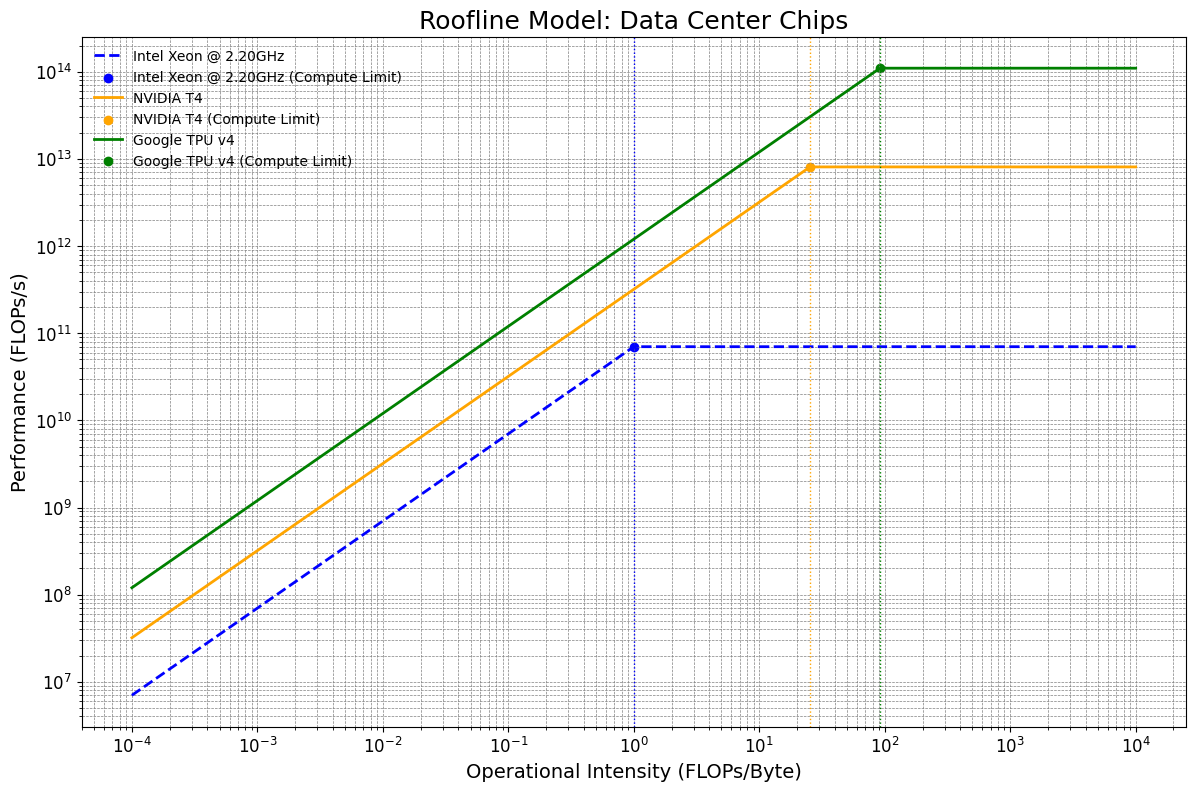

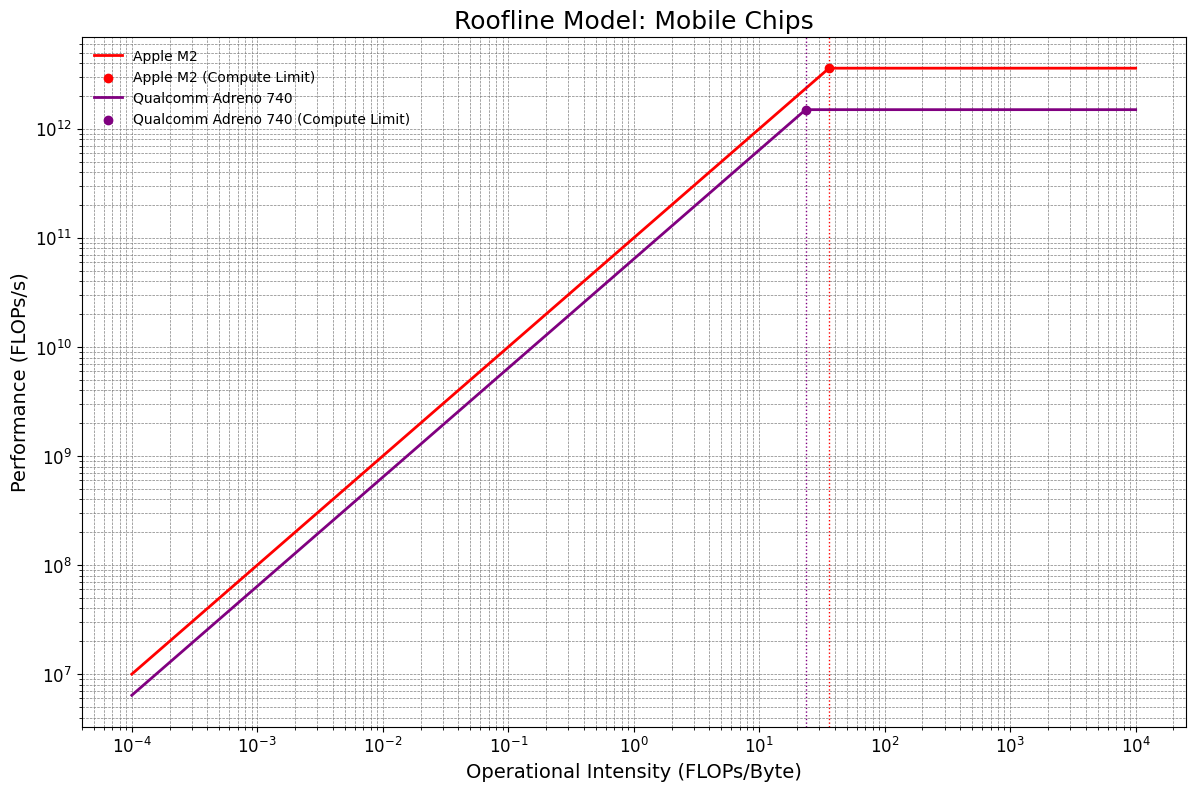

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import os

# Create directory to save graphs
save_dir = "./Graphs"
os.makedirs(save_dir, exist_ok=True)

# Define peak FLOPs/s and Memory Bandwidth for diverse chips
chips = {
    "Intel Xeon @ 2.20GHz": {"flops": np.float32(70.04e9), "bandwidth": np.float32(70e9), "dtype": "FP32"},  # CPU
    "NVIDIA T4": {"flops": np.float32(8.1e12), "bandwidth": np.float32(320e9), "dtype": "FP32"},  # GPU, corrected bandwidth
    "Google TPU v4": {"flops": np.float32(275e12), "bandwidth": np.float32(1.2e12), "dtype": "BF16"},  # ASIC
    "Apple M2": {"flops": np.float32(3.6e12), "bandwidth": np.float32(100e9), "dtype": "FP32"},  # SoC
    "Qualcomm Adreno 740": {"flops": np.float32(1.5e12), "bandwidth": np.float32(64e9), "dtype": "FP32"}  # Mobile GPU
}

# Define a function to normalize mixed precision (BF16 → FP32 equivalent)
def normalize_flops(flops, dtype, chip_name):
    """ Normalize BF16 FLOPs to FP32 equivalent based on scientific benchmarks. """
    if dtype == "BF16":
        if "Google TPU v4" in chip_name:
            return flops / 2.5  # TPU v4 BF16 is ~2.5x faster than FP32 (Google MLPerf)
        else:
            return flops / 2  # Generic BF16 ~2x FP32 based on NVIDIA papers
    return flops

# Convert all FLOP values to a normalized scale (FP32-equivalent)
for chip in chips:
    chips[chip]["flops"] = normalize_flops(chips[chip]["flops"], chips[chip]["dtype"], chip)

min_memory_intensity = min(chips[chip]["flops"] / chips[chip]["bandwidth"] for chip in chips)
# Adjust the operational intensity range to start from a very small positive number
operational_intensity = np.logspace(np.log10(min_memory_intensity) - 4, 4, 300, dtype=np.float32)

# Group chips by category
data_center_chips = ["Intel Xeon @ 2.20GHz", "NVIDIA T4", "Google TPU v4"]  # CPU, GPU, ASIC
mobile_chips = ["Apple M2", "Qualcomm Adreno 740"]  # SoC, Mobile GPU

# Define unique colors for each chip
chip_colors = {
    "Intel Xeon @ 2.20GHz": "blue",
    "NVIDIA T4": "orange",
    "Google TPU v4": "green",
    "Apple M2": "red",
    "Qualcomm Adreno 740": "purple"
}

# Function to plot the roofline model
def plot_roofline(chip_list, title, filename):
    plt.figure(figsize=(12, 8))

    for chip in chip_list:
        flops = chips[chip]["flops"]
        bandwidth = chips[chip]["bandwidth"]
        color = chip_colors[chip]  # Assign color for this chip

        # Compute the performance curve
        performance = np.minimum(flops, bandwidth * operational_intensity)
        full_intensity_range = np.logspace(np.log10(min_memory_intensity) - 4, 4, 300, dtype=np.float32)
        full_performance = np.minimum(flops, bandwidth * full_intensity_range)

        if chip == "Intel Xeon @ 2.20GHz":
            plt.plot(full_intensity_range, full_performance, label=chip, linewidth=2, linestyle="dashed", color=color)
        else:
            # Compute-bound chips
            plt.plot(full_intensity_range, full_performance, label=chip, linewidth=2, linestyle="solid", color=color)

        # Label peak FLOPs and memory bound limits
        plt.scatter(flops / bandwidth, flops, marker="o", color=color, label=f"{chip} (Compute Limit)")
        plt.axvline(flops / bandwidth, linestyle="dotted", color=color, linewidth=1)  # Memory bound limit

    # Set log scale for better visibility
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Operational Intensity (FLOPs/Byte)",fontsize=14)
    plt.ylabel("Performance (FLOPs/s)",fontsize=14)
    plt.title(f"Roofline Model: {title}",fontsize=18)
    plt.legend(loc="best", fontsize=10, frameon=False)
    plt.grid(True, which="both", linestyle="--", linewidth=0.5, color="gray")
    plt.tight_layout()
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.savefig(os.path.join(save_dir, filename), dpi=300, bbox_inches='tight')
    plt.show()

# Plot Data Center Chips (CPU, GPU, ASIC)
plot_roofline(data_center_chips, "Data Center Chips", "Data_center_roofline.png")

# Plot Mobile Chips (SoC, Mobile GPU)
plot_roofline(mobile_chips, "Mobile Chips", "Mobile_roofline.png")

**PART 2: DNN Compute and Memory Analysis**

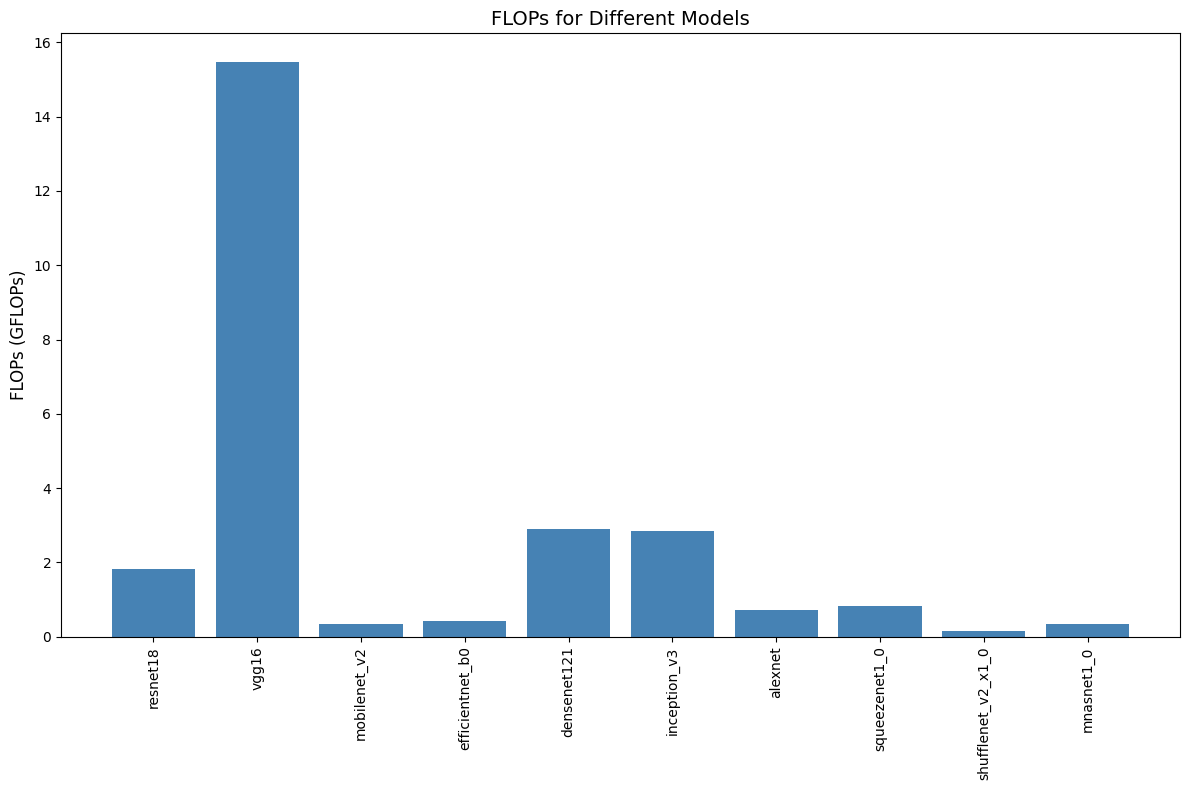

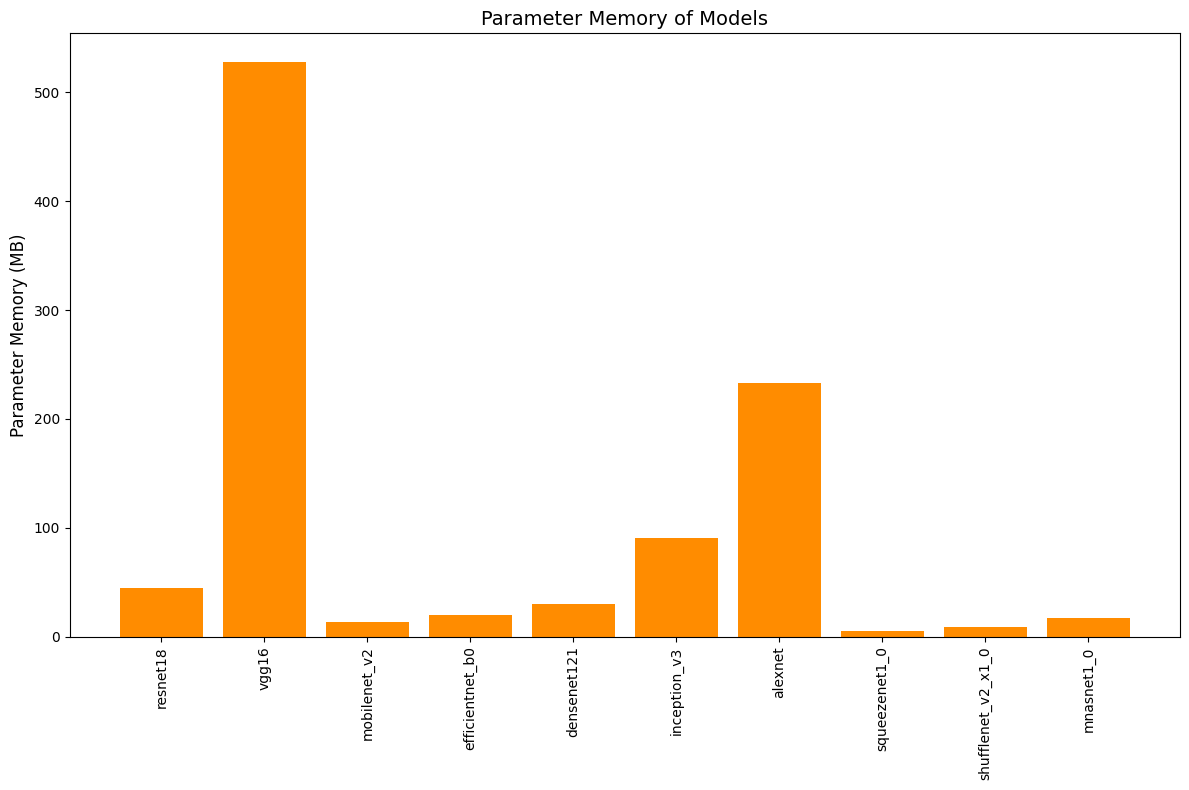

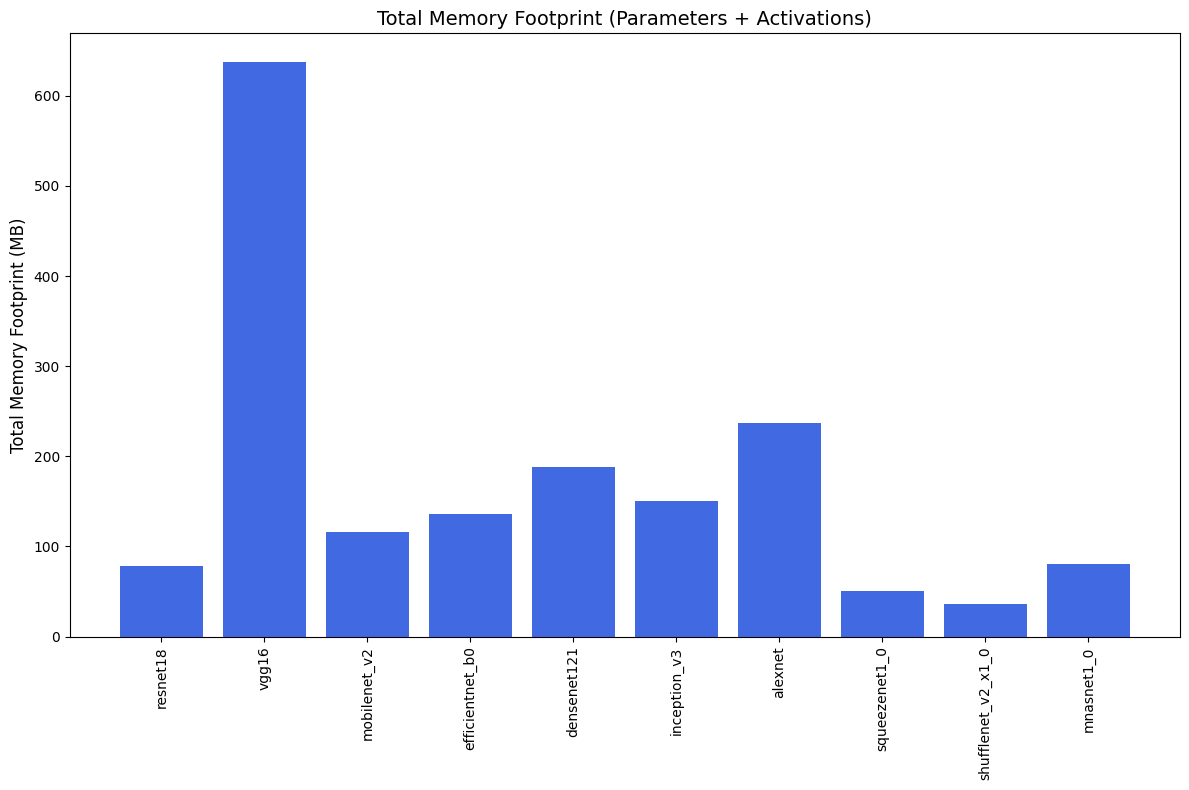

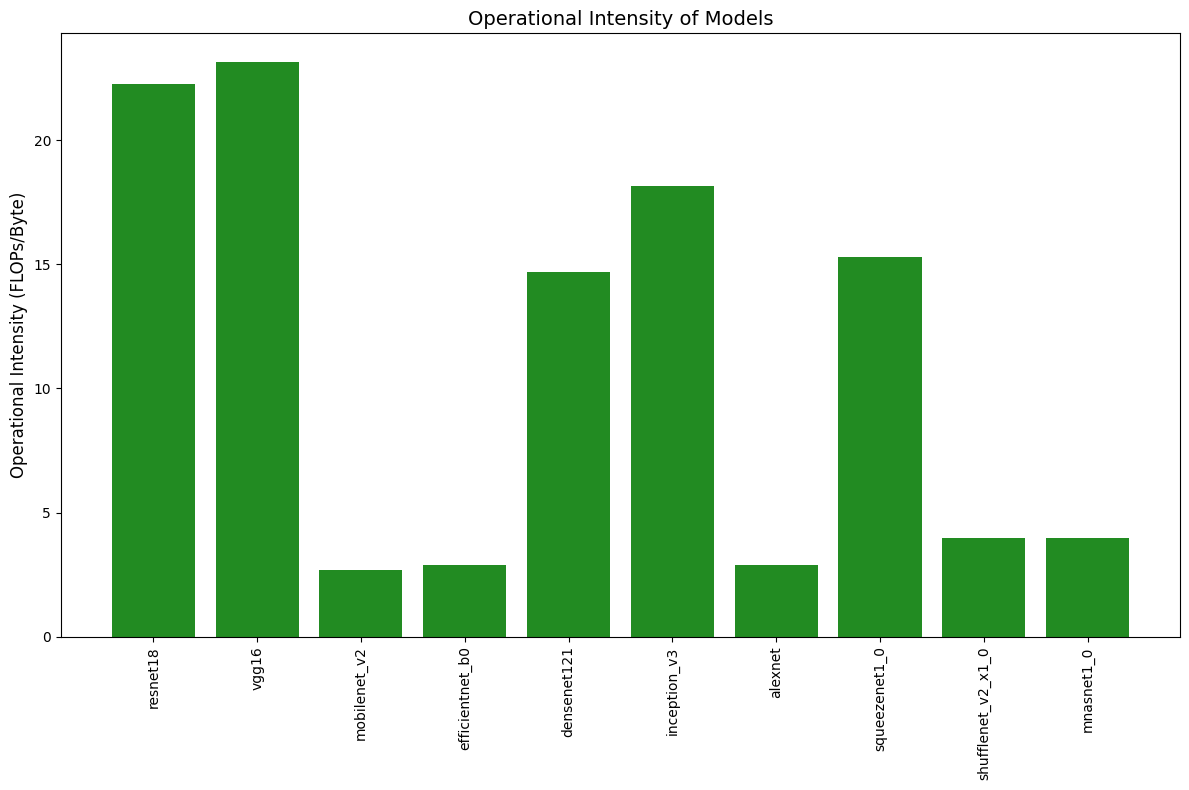

In [8]:
import torchvision.models as models
import torch
from thop import profile
import matplotlib.pyplot as plt
import os

# Directory for saving plots
save_dir = "./Graphs"
os.makedirs(save_dir, exist_ok=True)

# List of model names
model_names = [
    "resnet18", "vgg16", "mobilenet_v2", "efficientnet_b0",
    "densenet121", "inception_v3", "alexnet", "squeezenet1_0",
    "shufflenet_v2_x1_0", "mnasnet1_0"
]

# Initialize models
models_list = []
for name in model_names:
    if name == "efficientnet_b0":
        model = models.efficientnet_b0(pretrained=False)
    else:
        model = getattr(models, name)(pretrained=False)
    models_list.append(model.eval())  # Set to evaluation mode

# Function to compute activation memory using hooks
def get_activation_memory(model, input_tensor):
    activation_sizes = []

    def activation_hook(module, input, output):
        """Hook to capture activation memory."""
        if isinstance(output, tuple):
            for o in output:
                if isinstance(o, torch.Tensor):
                    activation_sizes.append(o.nelement() * o.element_size())
        elif isinstance(output, torch.Tensor):
            activation_sizes.append(output.nelement() * output.element_size())

    # Register hooks for all layers
    hooks = []
    for module in model.modules():
        hooks.append(module.register_forward_hook(activation_hook))

    # Run a forward pass to compute activation memory
    with torch.no_grad():
        model(input_tensor)

    # Remove hooks
    for hook in hooks:
        hook.remove()

    # Total activation memory in MB
    total_activation_memory = sum(activation_sizes) / (1024 ** 2)
    return total_activation_memory

# Compute FLOPs, memory footprint, and operational intensity
results = {}
for name, model in zip(model_names, models_list):
    input_tensor = torch.randn(1, 3, 224, 224)

    # Compute FLOPs and parameter count
    flops, params = profile(model, inputs=(input_tensor,), verbose=False)

    # Convert FLOPs to GFLOPs
    flops_g = flops / 1e9

    # Compute parameter memory in MB
    param_memory_mb = (params * 4) / (1024 ** 2)

    # Compute activation memory using hooks
    activation_memory_mb = get_activation_memory(model, input_tensor)

    # Compute total memory in MB (params + activations)
    total_memory_mb = param_memory_mb + activation_memory_mb

    # Convert total memory to bytes for operational intensity calculation
    total_memory_bytes = total_memory_mb * (1024 ** 2)

    # Compute operational intensity (FLOPs per byte)
    op_intensity = flops / total_memory_bytes if total_memory_bytes > 0 else 0

    results[name] = {
        "flops": flops_g,
        "param_memory": param_memory_mb,
        "activation_memory": activation_memory_mb,
        "total_memory": total_memory_mb,
        "op_intensity": op_intensity
    }

# Plot FLOPs (in GFLOPs)
plt.figure(figsize=(12, 8))
plt.bar(results.keys(), [v["flops"] for v in results.values()], color='steelblue')
plt.xticks(rotation=90, fontsize=10)
plt.ylabel("FLOPs (GFLOPs)", fontsize=12)
plt.title("FLOPs for Different Models", fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(save_dir, "FLOPs_for_Different_Models.png"), dpi=300, bbox_inches='tight')
plt.show()

# Plot Parameter Memory (in MB)
plt.figure(figsize=(12, 8))
plt.bar(results.keys(), [v["param_memory"] for v in results.values()], color='darkorange')
plt.xticks(rotation=90, fontsize=10)
plt.ylabel("Parameter Memory (MB)", fontsize=12)
plt.title("Parameter Memory of Models", fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(save_dir, "Parameter_Memory.png"), dpi=300, bbox_inches='tight')
plt.show()

# Plot Total Memory Footprint (Params + Activations) in MB
plt.figure(figsize=(12, 8))
plt.bar(results.keys(), [v["total_memory"] for v in results.values()], color='royalblue')
plt.xticks(rotation=90, fontsize=10)
plt.ylabel("Total Memory Footprint (MB)", fontsize=12)
plt.title("Total Memory Footprint (Parameters + Activations)", fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(save_dir, "Total_Memory_Footprint.png"), dpi=300, bbox_inches='tight')
plt.show()

# Plot Operational Intensity
plt.figure(figsize=(12, 8))
plt.bar(results.keys(), [v["op_intensity"] for v in results.values()], color='forestgreen')
plt.xticks(rotation=90, fontsize=10)
plt.ylabel("Operational Intensity (FLOPs/Byte)", fontsize=12)
plt.title("Operational Intensity of Models", fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(save_dir, "Operational_Intensity.png"), dpi=300, bbox_inches='tight')
plt.show()

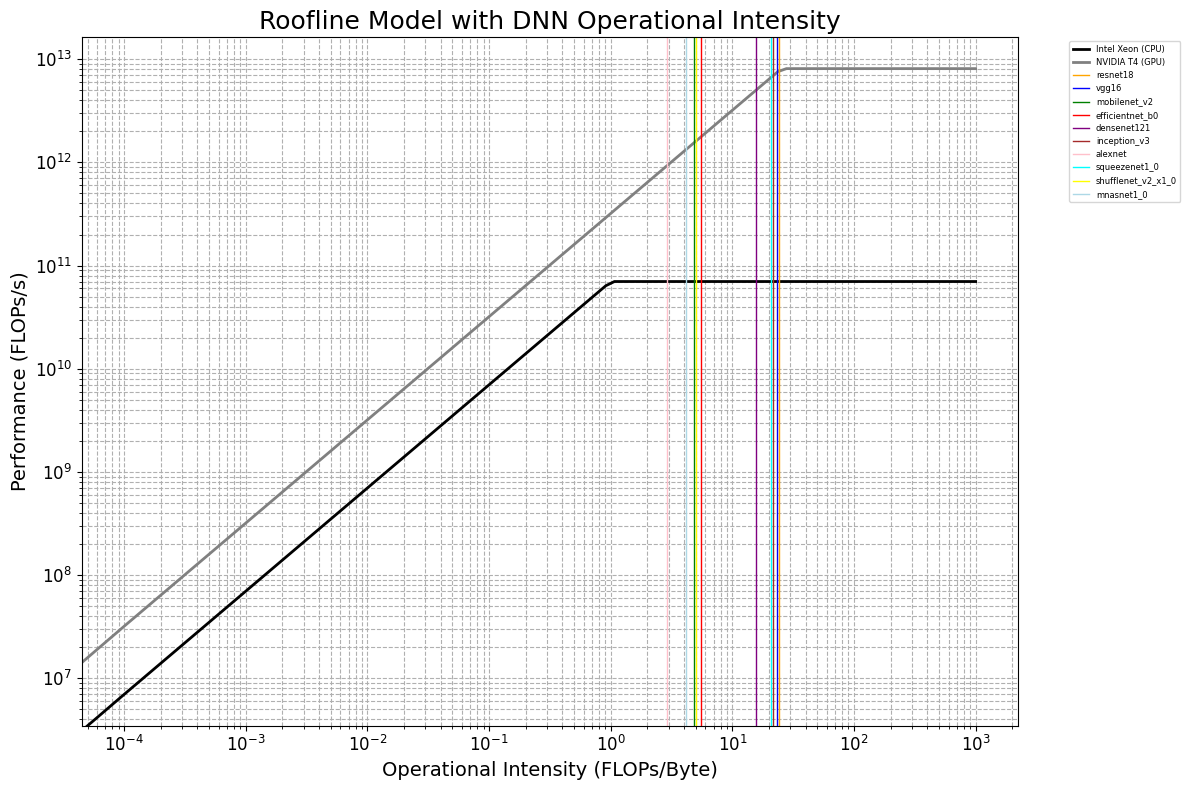

In [11]:
import torch
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np
import os
from thop import profile

# Directory for saving plots
save_dir = "./Graphs"
os.makedirs(save_dir, exist_ok=True)

# List of model names
model_names = [
    "resnet18", "vgg16", "mobilenet_v2", "efficientnet_b0",
    "densenet121", "inception_v3", "alexnet", "squeezenet1_0",
    "shufflenet_v2_x1_0", "mnasnet1_0"
]

# Initialize models
models_list = []
for name in model_names:
    if name == "efficientnet_b0":
        model = models.efficientnet_b0(pretrained=False)
    else:
        model = getattr(models, name)(pretrained=False)
    models_list.append(model.eval())  # Set to evaluation mode

# Function to track activation memory
def get_activation_memory(model, input_tensor):
    activation_memory = 0

    def forward_hook(module, inp, out):
        nonlocal activation_memory
        if isinstance(out, tuple):  # Handle tuple outputs
            out = out[0]
        activation_memory += out.nelement() * out.element_size()  # Bytes used

    hooks = []
    for layer in model.modules():
        if isinstance(layer, (torch.nn.Conv2d, torch.nn.Linear, torch.nn.ReLU, torch.nn.BatchNorm2d)):
            hooks.append(layer.register_forward_hook(forward_hook))

    with torch.no_grad():
        model(input_tensor)  # Run a forward pass to capture activations

    for hook in hooks:
        hook.remove()

    return activation_memory / (1024 * 1024)  # Convert to MB

# Compute FLOPs, memory footprint, and operational intensity
results = {}
for name, model in zip(model_names, models_list):
    input_tensor = torch.randn(1, 3, 224, 224)

    # Compute FLOPs
    flops, params = profile(model, inputs=(input_tensor,), verbose=False)
    flops_g = flops / 1e9  # Convert FLOPs to GFLOPs

    # Get activation memory using hooks
    activation_memory_mb = get_activation_memory(model, input_tensor)

    # Parameter memory in MB
    param_memory_mb = params * 4 / (1024 * 1024)  # Convert params to MB (assuming float32)

    # Total memory usage (Parameters + Activations)
    total_memory_mb = param_memory_mb + activation_memory_mb

    # Operational Intensity (FLOPs per byte)
    total_memory_bytes = total_memory_mb * 1024 * 1024  # Convert MB to bytes
    op_intensity = flops / total_memory_bytes if total_memory_bytes > 0 else 0  # Avoid division by zero

    results[name] = {
        "flops": flops_g,
        "total_memory": total_memory_mb,
        "op_intensity": op_intensity
    }

# Hardware specifications
peak_performance_t4_gpu = 8.1 * 10**12    # Peak performance of NVIDIA T4 GPU
peak_performance_cpu = 70.04 * 10**9      # Peak performance of Intel Xeon CPU
mem_bandwidth_cpu = 70 * 10**9            # CPU memory bandwidth
mem_bandwidth_gpu = 320 * 10**9           # GPU memory bandwidth (320 GB/s)

# Create x-axis values for operational intensity (log scale)
x = np.logspace(-4, 3, 100)
x = np.insert(x, 0, 0)

# Roofline for CPU
y_cpu = np.minimum(peak_performance_cpu, mem_bandwidth_cpu * x)
# Roofline for GPU
y_gpu = np.minimum(peak_performance_t4_gpu, mem_bandwidth_gpu * x)

# Plotting the Roofline model
plt.figure(figsize=(12, 8))
plt.loglog(x, y_cpu, label='Intel Xeon (CPU)', color='black', linewidth=2)
plt.loglog(x, y_gpu, label='NVIDIA T4 (GPU)', color='gray', linewidth=2)

# Adding vertical lines for each model's operational intensity
colors = ['orange', 'blue', 'green', 'red', 'purple', 'brown', 'pink', 'cyan', 'yellow', 'lightblue']
for (name, data), color in zip(results.items(), colors):
    op_intensity = data['op_intensity']
    plt.axvline(x=op_intensity, color=color, linestyle='-', linewidth=1, label=name)

plt.xlabel('Operational Intensity (FLOPs/Byte)', fontsize=14)
plt.ylabel('Performance (FLOPs/s)', fontsize=14)
plt.title('Roofline Model with DNN Operational Intensity', fontsize=18)

# Adjusting tick label size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Adjusting the legend
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=6)

plt.grid(True, which="both", ls="--")
plt.tight_layout()
plt.savefig(os.path.join(save_dir, "Roofline_Model_DNN.png"), dpi=300, bbox_inches='tight')
plt.show()

**Part 3: DNN Performance Benchmarking**

Processing model: resnet18


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


  Testing batch size: 1
  Testing batch size: 64
  Testing batch size: 256
Processing model: vgg16
  Testing batch size: 1
  Testing batch size: 64
  Testing batch size: 256
Processing model: mobilenet_v2
  Testing batch size: 1
  Testing batch size: 64
  Testing batch size: 256
Processing model: efficientnet_b0
  Testing batch size: 1
  Testing batch size: 64
  Testing batch size: 256
Processing model: densenet121
  Testing batch size: 1
  Testing batch size: 64
  Testing batch size: 256
Processing model: inception_v3


/usr/local/lib/python3.11/dist-packages/torchvision/models/inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


  Testing batch size: 1
  Testing batch size: 64
  Testing batch size: 256
Processing model: alexnet
  Testing batch size: 1
  Testing batch size: 64
  Testing batch size: 256
Processing model: squeezenet1_0
  Testing batch size: 1
  Testing batch size: 64
  Testing batch size: 256
Processing model: shufflenet_v2_x1_0
  Testing batch size: 1
  Testing batch size: 64
  Testing batch size: 256
Processing model: mnasnet1_0
  Testing batch size: 1
  Testing batch size: 64
  Testing batch size: 256


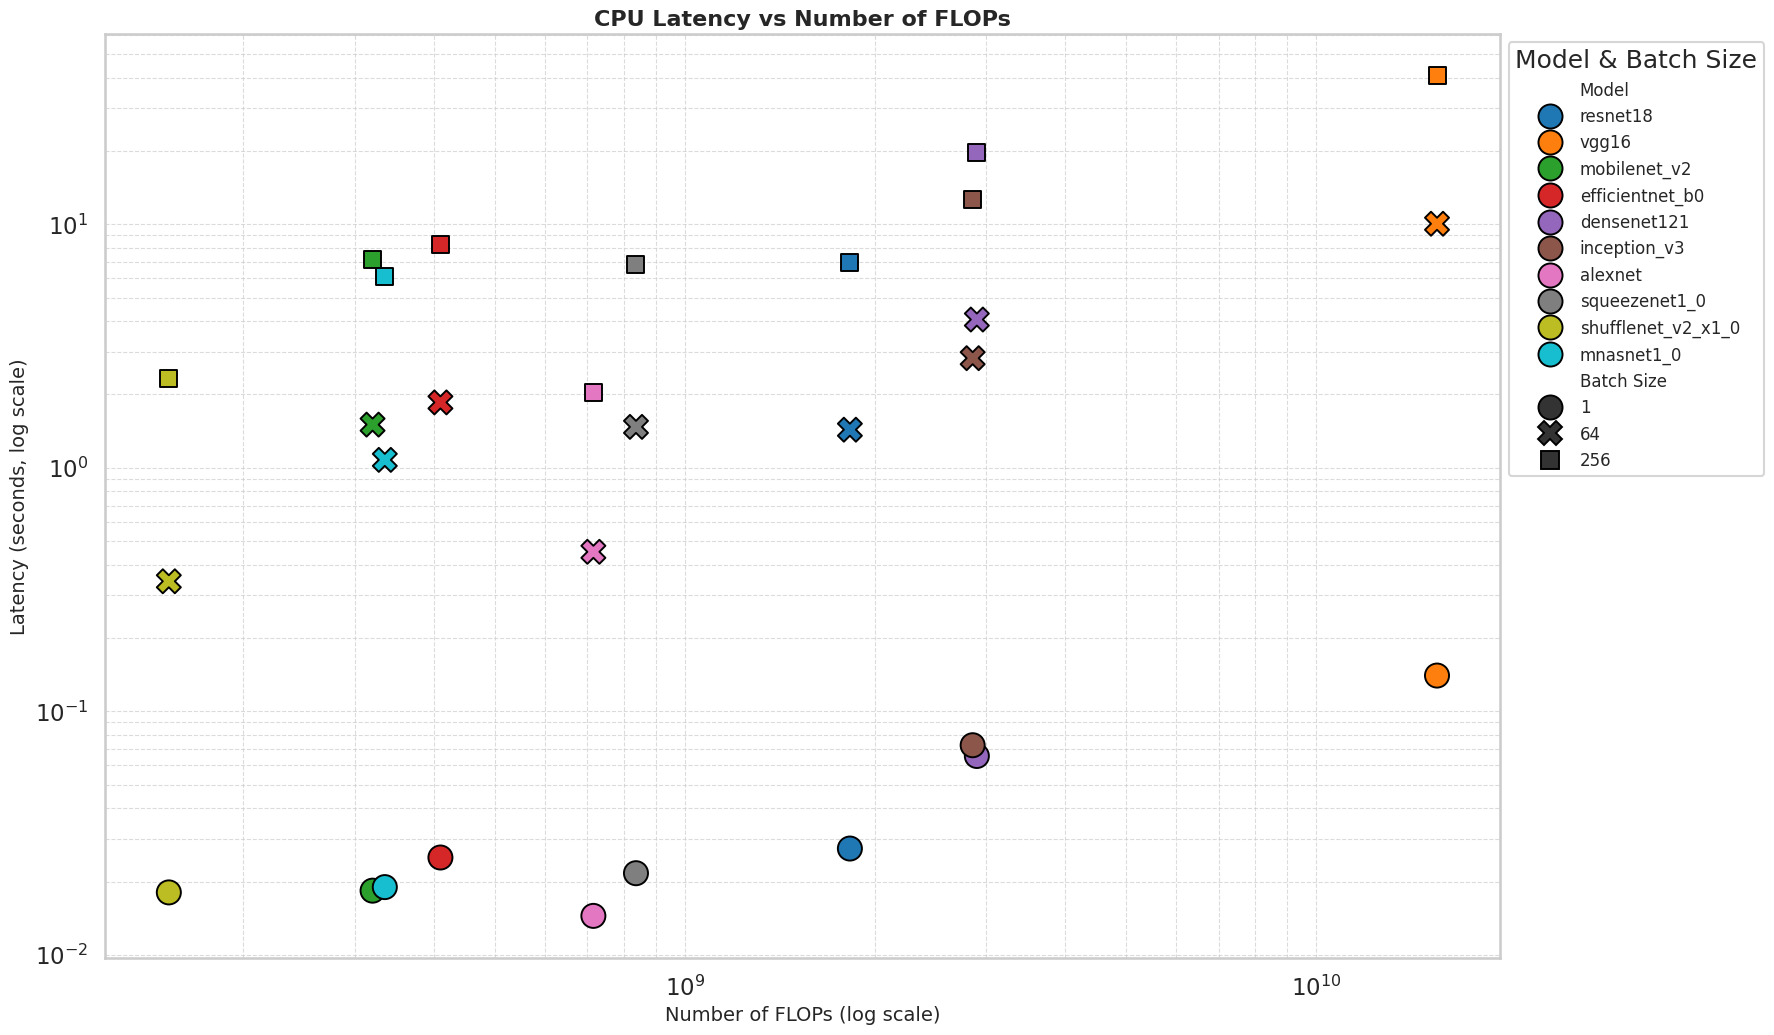

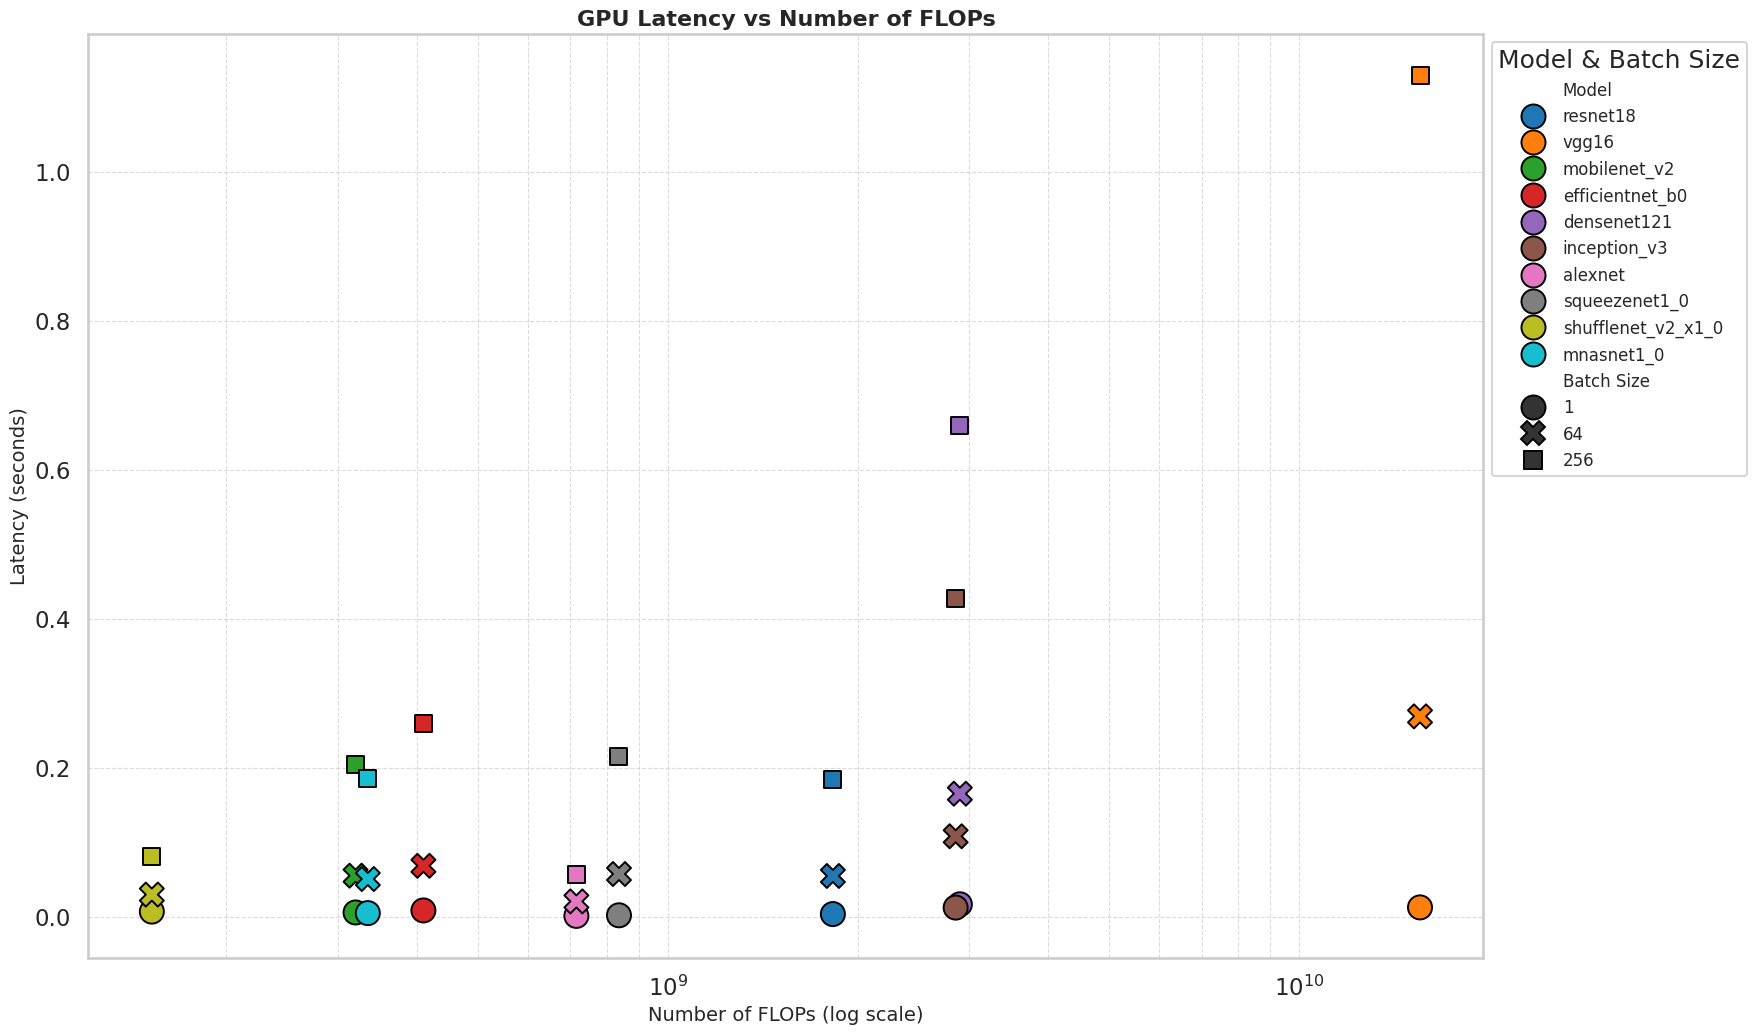

In [12]:
import time
import torch
import torch.nn as nn
from torchvision import models
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from ptflops import get_model_complexity_info
import os
import gc

# Define model names and batch sizes
model_names = [
    "resnet18", "vgg16", "mobilenet_v2", "efficientnet_b0",
    "densenet121", "inception_v3", "alexnet", "squeezenet1_0",
    "shufflenet_v2_x1_0", "mnasnet1_0"
]
batch_sizes = [1, 64, 256]
input_size = 224
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Directory for saving plots
save_dir = "./Graphs"
os.makedirs(save_dir, exist_ok=True)

results = []
latency_data = []

for name in model_names:
    print(f"Processing model: {name}")

    model = getattr(models, name)(pretrained=False).eval()
    macs, params = get_model_complexity_info(model, (3, input_size, input_size),
                                             as_strings=False, print_per_layer_stat=False)

    model.to("cpu")
    torch.cuda.empty_cache()

    for batch_size in batch_sizes:
        print(f"  Testing batch size: {batch_size}")

        input_tensor = torch.randn(batch_size, 3, input_size, input_size, pin_memory=True)

        # CPU Benchmark
        input_cpu = input_tensor.to('cpu')
        model.to('cpu')


        with torch.no_grad():
            for _ in range(10):
                model(input_cpu)

        # Benchmark Runs (5 iterations for stable measurement)
        cpu_times = []
        with torch.no_grad():
            for _ in range(5):
                start = time.time()
                model(input_cpu)
                cpu_times.append(time.time() - start)

        cpu_time = sum(cpu_times) / len(cpu_times)

        # GPU Benchmark
        gpu_time = None
        if torch.cuda.is_available():
            input_gpu = input_tensor.to(device, non_blocking=True)
            model.to(device)
            torch.cuda.synchronize()


            with torch.no_grad():
                for _ in range(10):
                    model(input_gpu)
                torch.cuda.synchronize()

            # Benchmark Runs (5 iterations)
            gpu_times = []
            with torch.no_grad():
                for _ in range(5):
                    torch.cuda.synchronize()
                    start = time.time()
                    model(input_gpu)
                    torch.cuda.synchronize()
                    gpu_times.append(time.time() - start)

            gpu_time = sum(gpu_times) / len(gpu_times)

        latency_data.append({
            'Model': name,
            'Batch Size': batch_size,
            'CPU Latency': cpu_time,
            'GPU Latency': gpu_time,
            'FLOPs': macs,
            'Params': params
        })

    del model, input_tensor, input_cpu
    if torch.cuda.is_available():
        del input_gpu
        torch.cuda.empty_cache()
    gc.collect()


df_latency = pd.DataFrame(latency_data)

# Adjust scales dynamically for better visualization
cpu_latency_min, cpu_latency_max = df_latency['CPU Latency'].min(), df_latency['CPU Latency'].max()
gpu_latency_min, gpu_latency_max = df_latency['GPU Latency'].min(), df_latency['GPU Latency'].max()
fmin, fmax = df_latency['FLOPs'].min(), df_latency['FLOPs'].max()

sns.set_context("talk")
sns.set_style("whitegrid")

# CPU Latency vs FLOPs Plot
plt.figure(figsize=(18, 12))
sns.scatterplot(
    data=df_latency, x='FLOPs', y='CPU Latency',
    hue='Model', style='Batch Size', s=300, palette='tab10', edgecolor='black'
)

plt.title('CPU Latency vs Number of FLOPs', fontsize=16, fontweight='bold')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of FLOPs (log scale)', fontsize=14)
plt.ylabel('Latency (seconds, log scale)', fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.8, alpha=0.7)

plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Model & Batch Size", fontsize=12)
plt.savefig(os.path.join(save_dir, "Latency_vs_FLOPs_CPU.png"), dpi=300, bbox_inches='tight')
plt.show()


# GPU Latency vs FLOPs Plot
if torch.cuda.is_available():
    plt.figure(figsize=(18, 12))
    sns.scatterplot(
        data=df_latency, x='FLOPs', y='GPU Latency',
        hue='Model', style='Batch Size', s=300, palette='tab10', edgecolor='black'
    )

    plt.title('GPU Latency vs Number of FLOPs', fontsize=16, fontweight='bold')
    plt.xscale('log')

    plt.xlabel('Number of FLOPs (log scale)', fontsize=14)
    plt.ylabel('Latency (seconds)', fontsize=14)
    plt.grid(True, which='both', linestyle='--', linewidth=0.8, alpha=0.7)
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Model & Batch Size", fontsize=12)

    # Save and Show
    plt.savefig(os.path.join(save_dir, "Latency_vs_FLOPs_GPU.png"), dpi=300, bbox_inches='tight')
    plt.show()

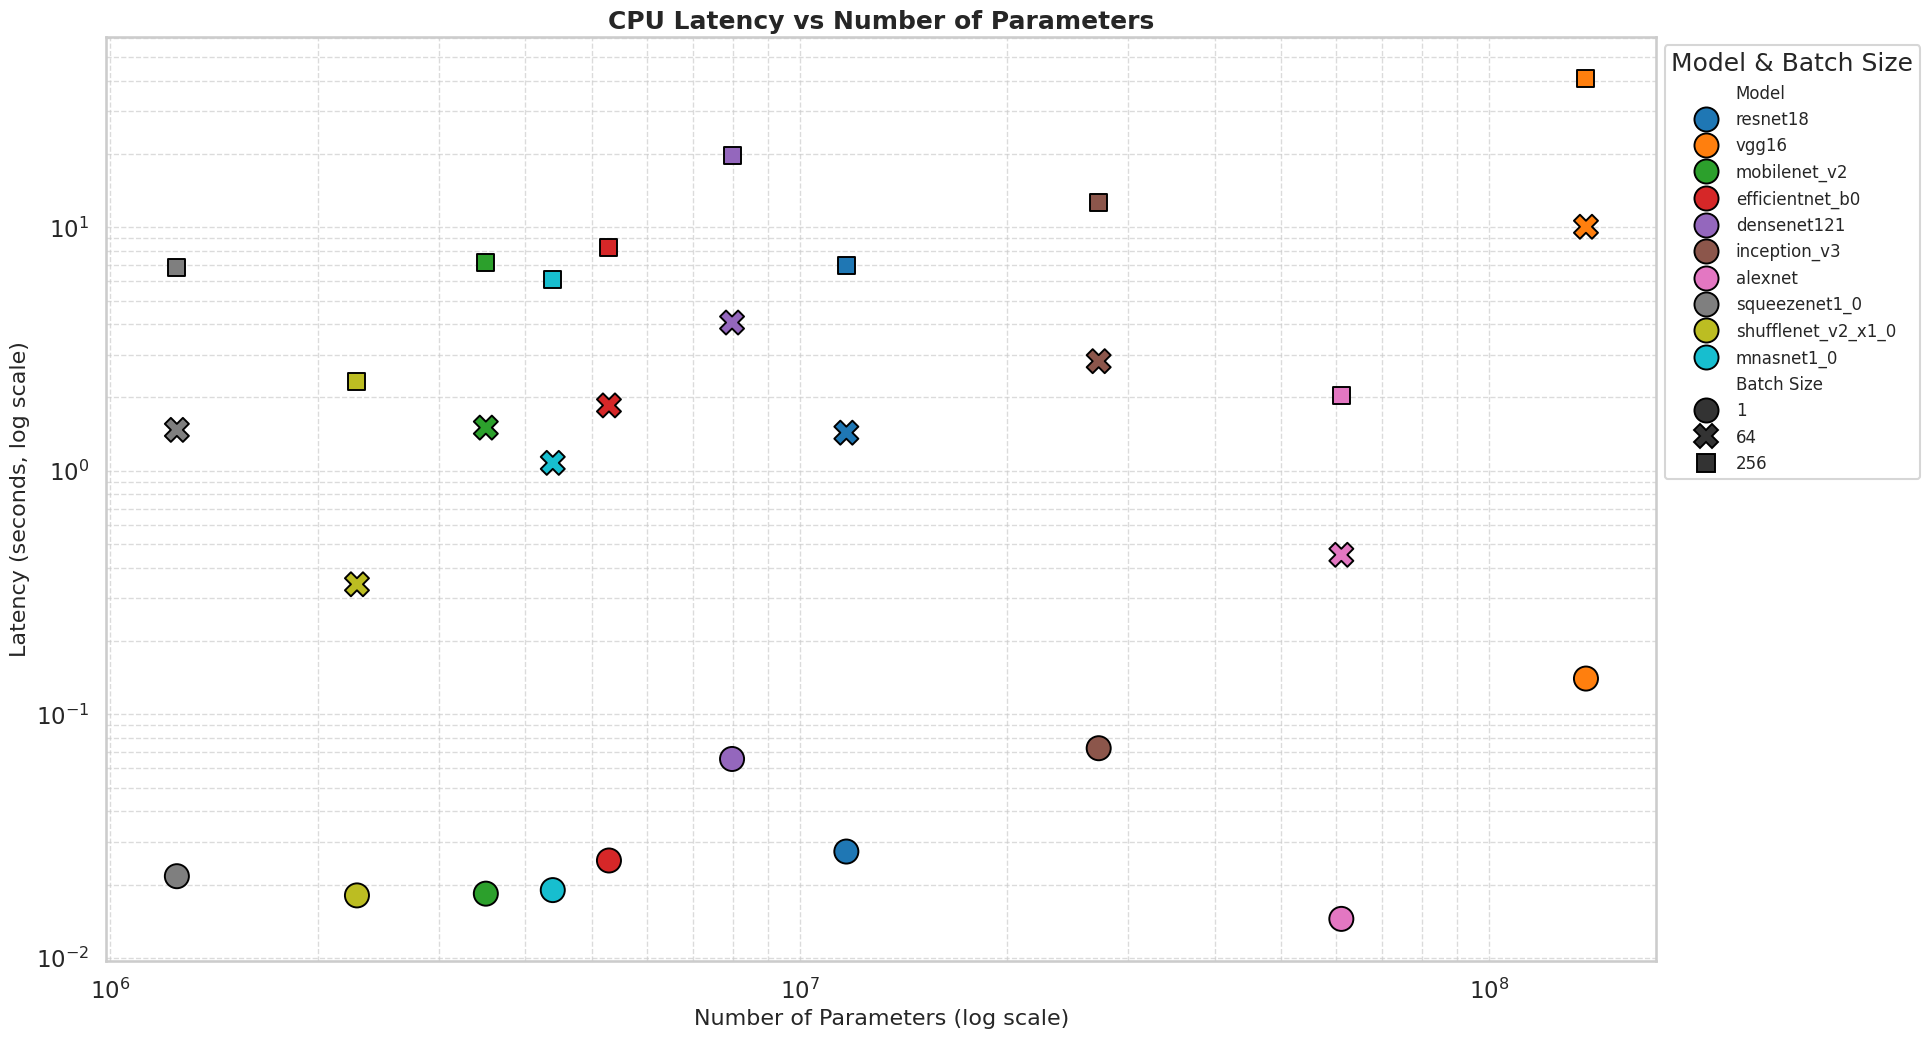

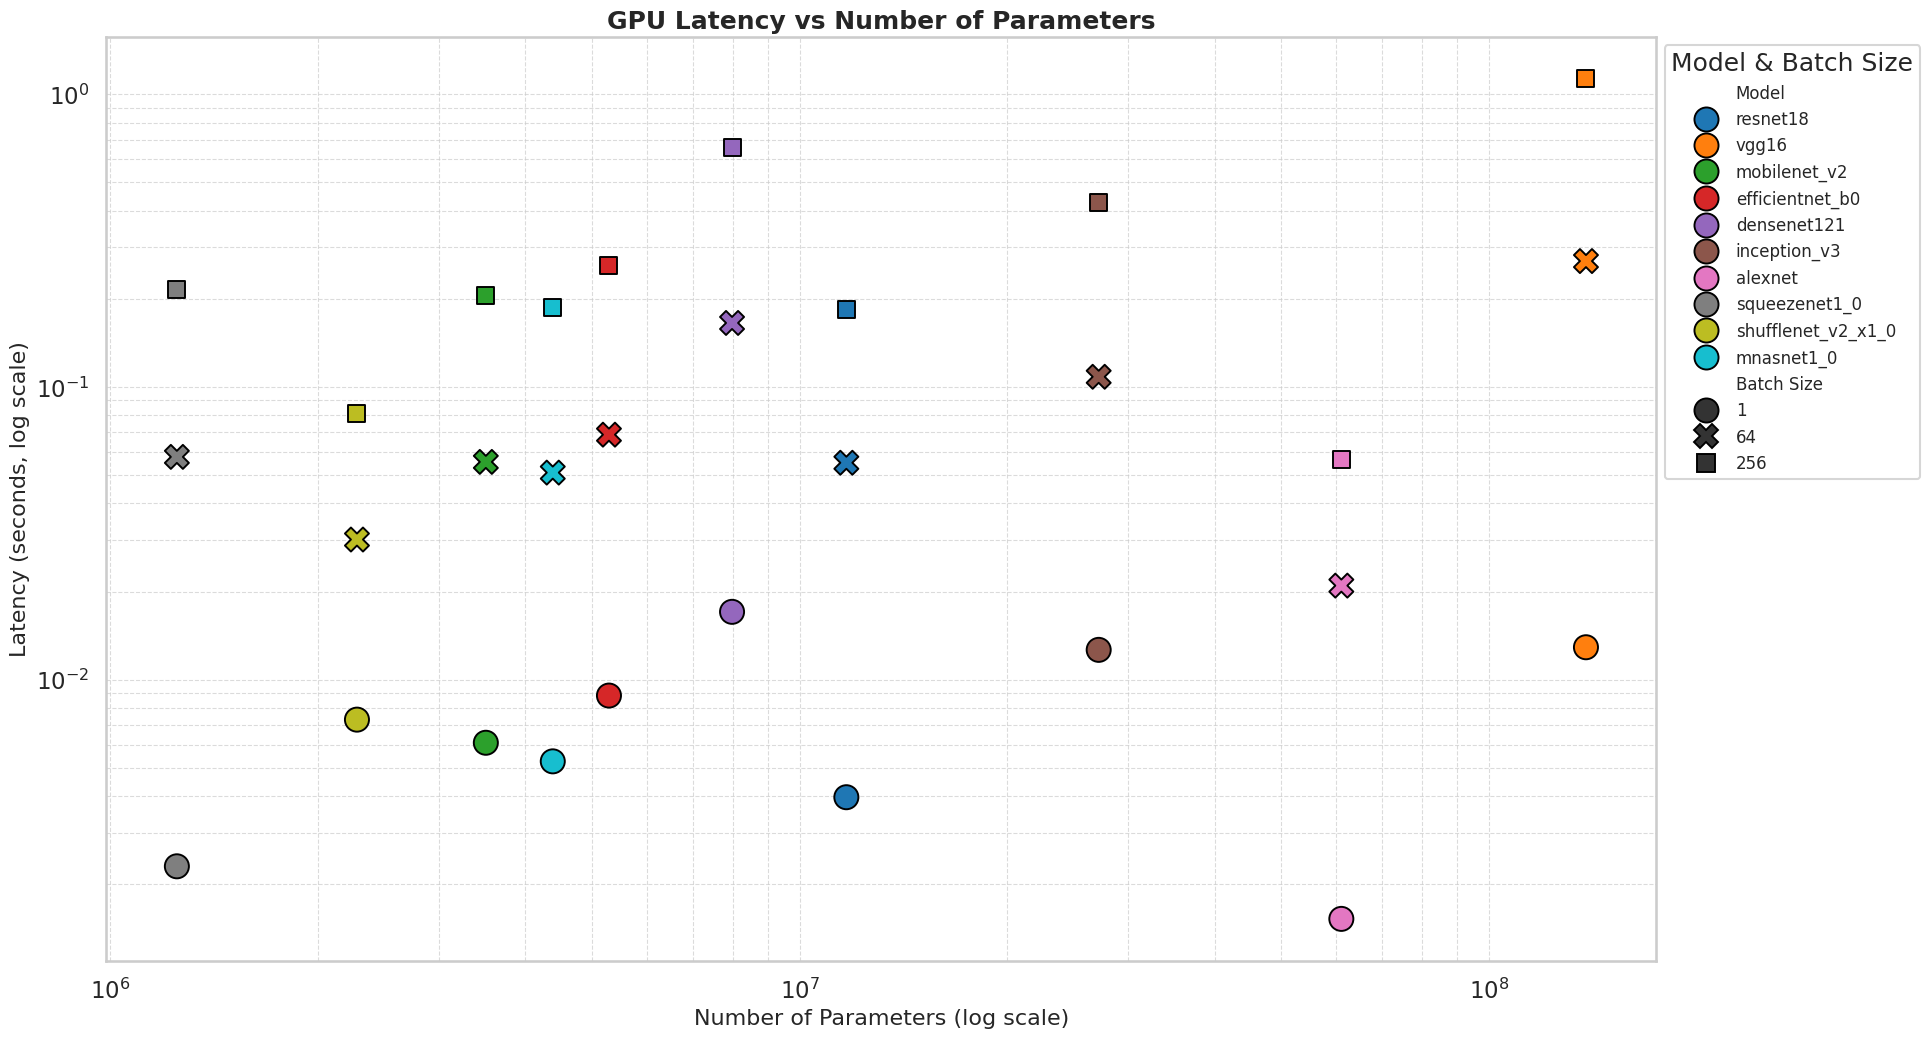

In [14]:
# CPU Latency vs Parameters (Log Scale)
plt.figure(figsize=(20, 12))
sns.scatterplot(
    data=df_latency, x='Params', y='CPU Latency',
    hue='Model', style='Batch Size', s=300, palette='tab10', edgecolor='black'
)

plt.title('CPU Latency vs Number of Parameters', fontsize=18, fontweight='bold')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of Parameters (log scale)', fontsize=16)
plt.ylabel('Latency (seconds, log scale)', fontsize=16)
plt.grid(True, which='both', linestyle='--', linewidth=1, alpha=0.7)

plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Model & Batch Size", fontsize=12)
plt.savefig(os.path.join(save_dir, "Latency_vs_Params_CPU_log.png"), dpi=300, bbox_inches='tight')
plt.show()

# GPU Latency vs Parameters (Log Scale)
if torch.cuda.is_available():
    plt.figure(figsize=(20, 12))
    sns.scatterplot(
        data=df_latency, x='Params', y='GPU Latency',
        hue='Model', style='Batch Size', s=300, palette='tab10', edgecolor='black'
    )

    plt.title('GPU Latency vs Number of Parameters', fontsize=18, fontweight='bold')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Number of Parameters (log scale)', fontsize=16)
    plt.ylabel('Latency (seconds, log scale)', fontsize=16)
    plt.grid(True, which='both', linestyle='--', linewidth=0.8, alpha=0.7)

    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Model & Batch Size", fontsize=12)
    plt.savefig(os.path.join(save_dir, "Latency_vs_Params_GPU_log.png"), dpi=300, bbox_inches='tight')
    plt.show()

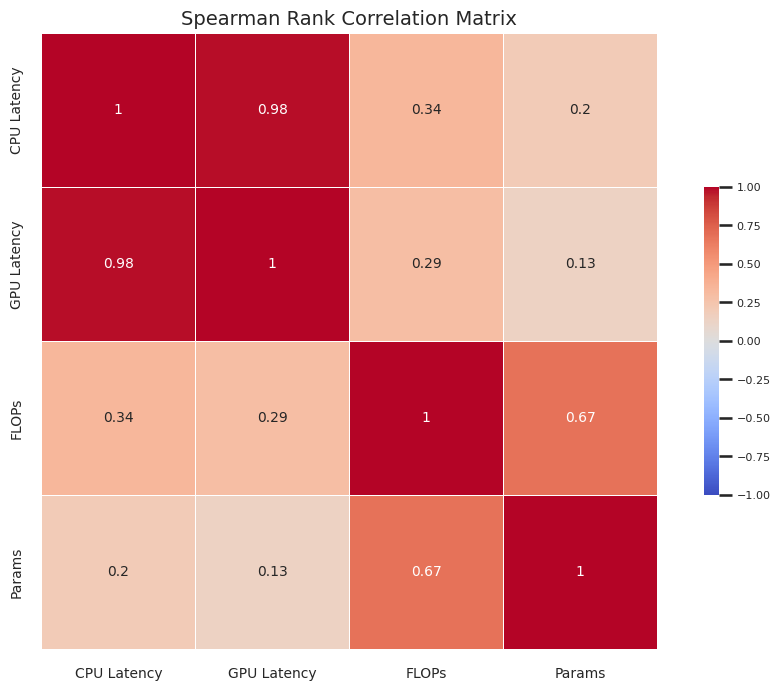

In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

# Filter out rows where GPU Latency is None since we can't compute correlation with NaN values
df_latency_cleaned = df_latency.dropna(subset=['GPU Latency'])

# Select the columns we want to correlate
columns_to_correlate = ['CPU Latency', 'GPU Latency', 'FLOPs', 'Params']

# Compute the Spearman rank correlation matrix
correlation_matrix = df_latency_cleaned[columns_to_correlate].corr(method='spearman')

# Plotting the correlation matrix
plt.figure(figsize=(12, 8))
heatmap = sns.heatmap(
    correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0,
    square=True, linewidths=.5, annot_kws={"fontsize": 10}  # Smaller annotation labels
)

# Reduce font size for x and y labels
plt.xticks(fontsize=10)  # Adjust x-axis labels
plt.yticks(fontsize=10)  # Adjust y-axis labels

# Reduce font size for the colorbar
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=8)  # Make colorbar labels smaller

plt.title('Spearman Rank Correlation Matrix', fontsize=14)  # Reduce title font size
plt.savefig(os.path.join(save_dir, "Spearman_Correlation_Matrix.png"), dpi=300, bbox_inches='tight')
plt.show()

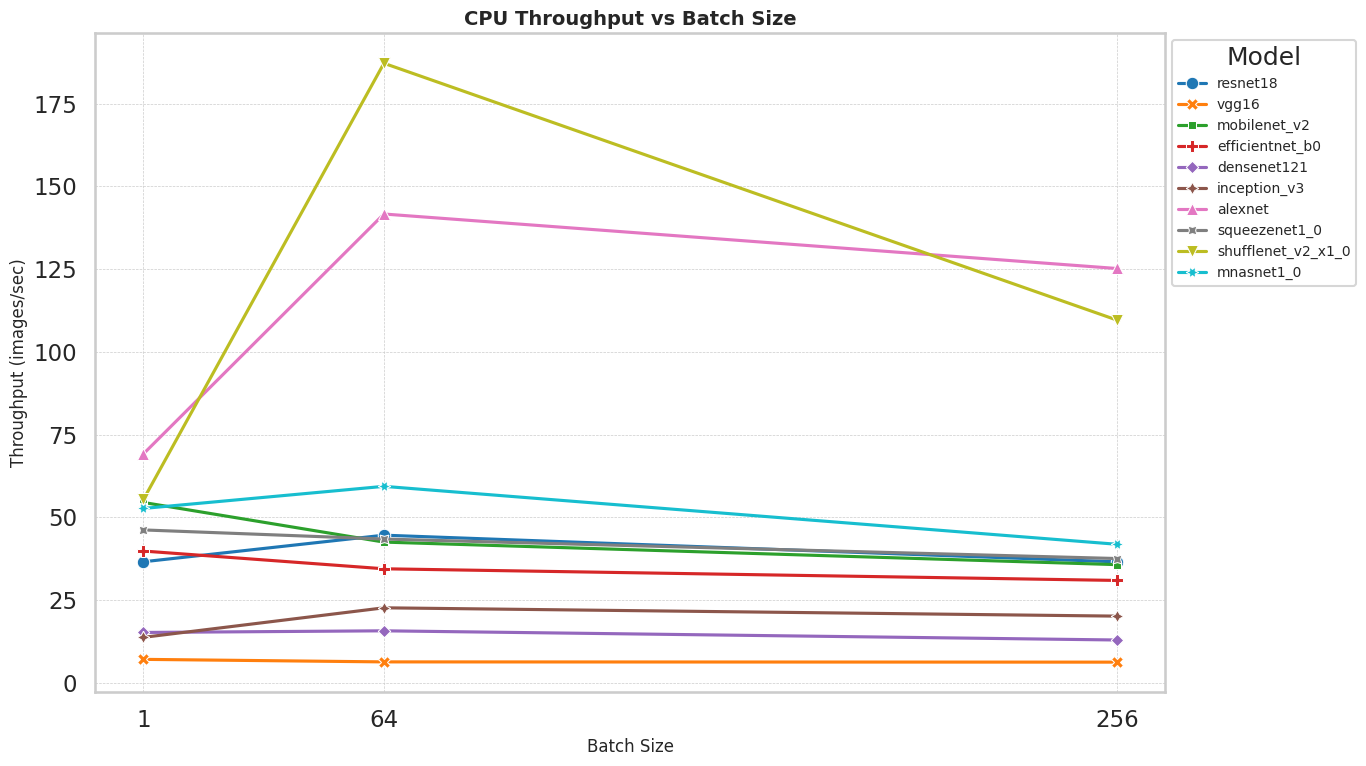

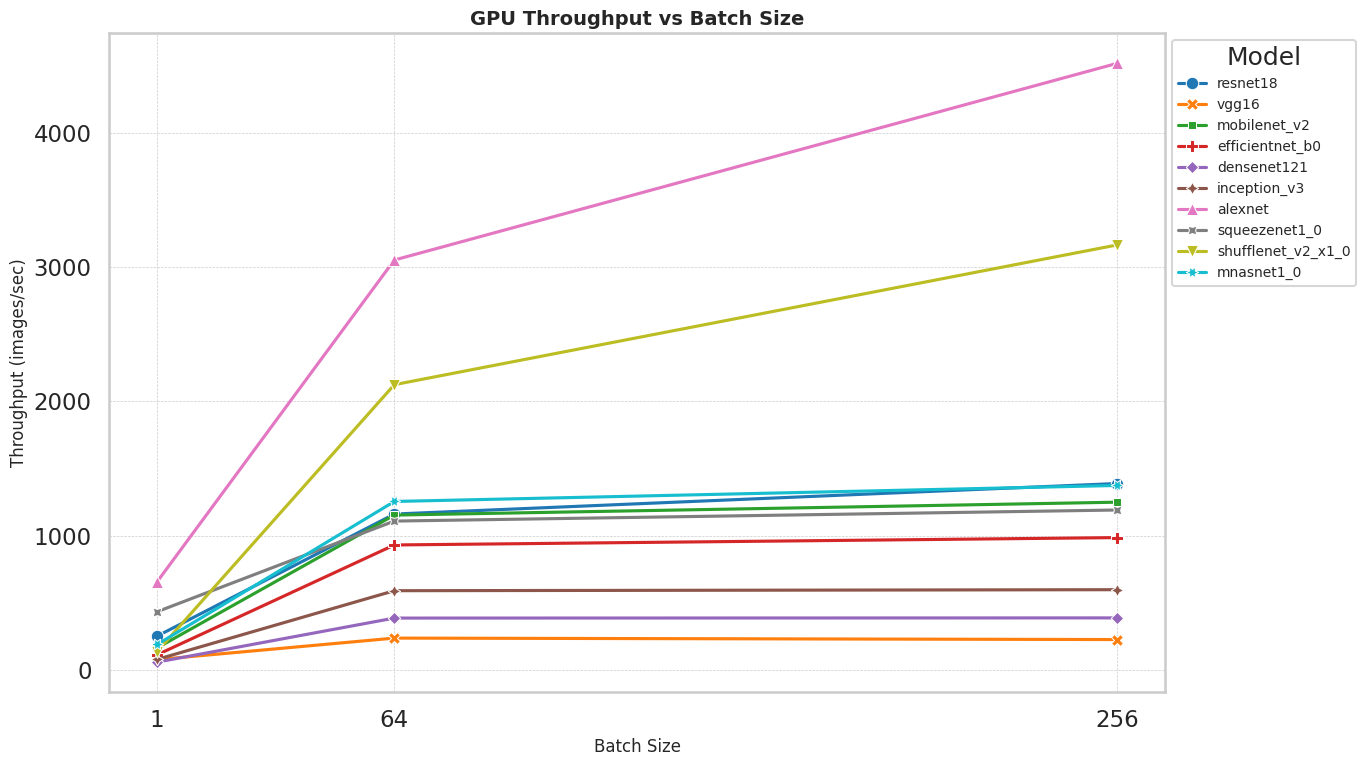

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

#3.5 Compute Throughput Data
throughput_data = []


for entry in latency_data:
    model = entry.get('Model')
    batch_size = entry.get('Batch Size')

    throughput_data.append({
        'Model': model,
        'Batch Size': batch_size,
        'CPU Throughput': batch_size / entry.get('CPU Latency', 1),
        'GPU Throughput': batch_size / entry.get('GPU Latency', 1) if torch.cuda.is_available() else None
    })


df_throughput = pd.DataFrame(throughput_data)


plt.figure(figsize=(14, 8))
sns.lineplot(data=df_throughput, x='Batch Size', y='CPU Throughput', hue='Model', style='Model', markers=True, dashes=False)

plt.xticks(batch_sizes)
plt.title('CPU Throughput vs Batch Size', fontsize=14, fontweight='bold')
plt.xlabel('Batch Size', fontsize=12)
plt.ylabel('Throughput (images/sec)', fontsize=12)
plt.grid(True, linestyle="--", linewidth=0.5)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Model", fontsize=10)
plt.tight_layout()
plt.savefig(os.path.join(save_dir, "3.5_CPU_Throughput_vs_Batch_Size.png"), dpi=300, bbox_inches='tight')
plt.show()

#GPU Throughput vs Batch Size Plot
if torch.cuda.is_available():
    plt.figure(figsize=(14, 8))
    sns.lineplot(data=df_throughput, x='Batch Size', y='GPU Throughput', hue='Model', style='Model', markers=True, dashes=False)

    plt.xticks(batch_sizes)
    plt.title('GPU Throughput vs Batch Size', fontsize=14, fontweight='bold')
    plt.xlabel('Batch Size', fontsize=12)
    plt.ylabel('Throughput (images/sec)', fontsize=12)
    plt.grid(True, linestyle="--", linewidth=0.5)
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Model", fontsize=10)
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "3.5_GPU_Throughput_vs_Batch_Size.png"), dpi=300, bbox_inches='tight')
    plt.show()

**Part 4: Hardware Utilization and Peak Performance**


Processing model: resnet18


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Processing resnet18 with batch size 256
Processing resnet18 with batch size 128
Processing resnet18 with batch size 64
Processing resnet18 with batch size 1
Processing model: vgg16
Processing vgg16 with batch size 256
Reducing batch size for vgg16 due to GPU OOM...
Processing vgg16 with batch size 128
Processing vgg16 with batch size 64
Processing vgg16 with batch size 1
Processing model: mobilenet_v2
Processing mobilenet_v2 with batch size 256
Reducing batch size for mobilenet_v2 due to GPU OOM...
Processing mobilenet_v2 with batch size 128
Processing mobilenet_v2 with batch size 64
Processing mobilenet_v2 with batch size 1
Processing model: efficientnet_b0
Processing efficientnet_b0 with batch size 256
Reducing batch size for efficientnet_b0 due to GPU OOM...
Processing efficientnet_b0 with batch size 128
Processing efficientnet_b0 with batch size 64
Processing efficientnet_b0 with batch size 1
Processing model: densenet121
Processing densenet121 with batch size 256
Reducing batch si

/usr/local/lib/python3.11/dist-packages/torchvision/models/inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


Processing inception_v3 with batch size 256
Processing inception_v3 with batch size 128
Processing inception_v3 with batch size 64
Processing inception_v3 with batch size 1
Processing model: alexnet
Processing alexnet with batch size 256
Processing alexnet with batch size 128
Processing alexnet with batch size 64
Processing alexnet with batch size 1
Processing model: squeezenet1_0
Processing squeezenet1_0 with batch size 256
Processing squeezenet1_0 with batch size 128
Processing squeezenet1_0 with batch size 64
Processing squeezenet1_0 with batch size 1
Processing model: shufflenet_v2_x1_0
Processing shufflenet_v2_x1_0 with batch size 256
Processing shufflenet_v2_x1_0 with batch size 128
Processing shufflenet_v2_x1_0 with batch size 64
Processing shufflenet_v2_x1_0 with batch size 1
Processing model: mnasnet1_0
Processing mnasnet1_0 with batch size 256
Processing mnasnet1_0 with batch size 128
Processing mnasnet1_0 with batch size 64
Processing mnasnet1_0 with batch size 1


<ipython-input-17-83d87550c17d>:192: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(model_names))


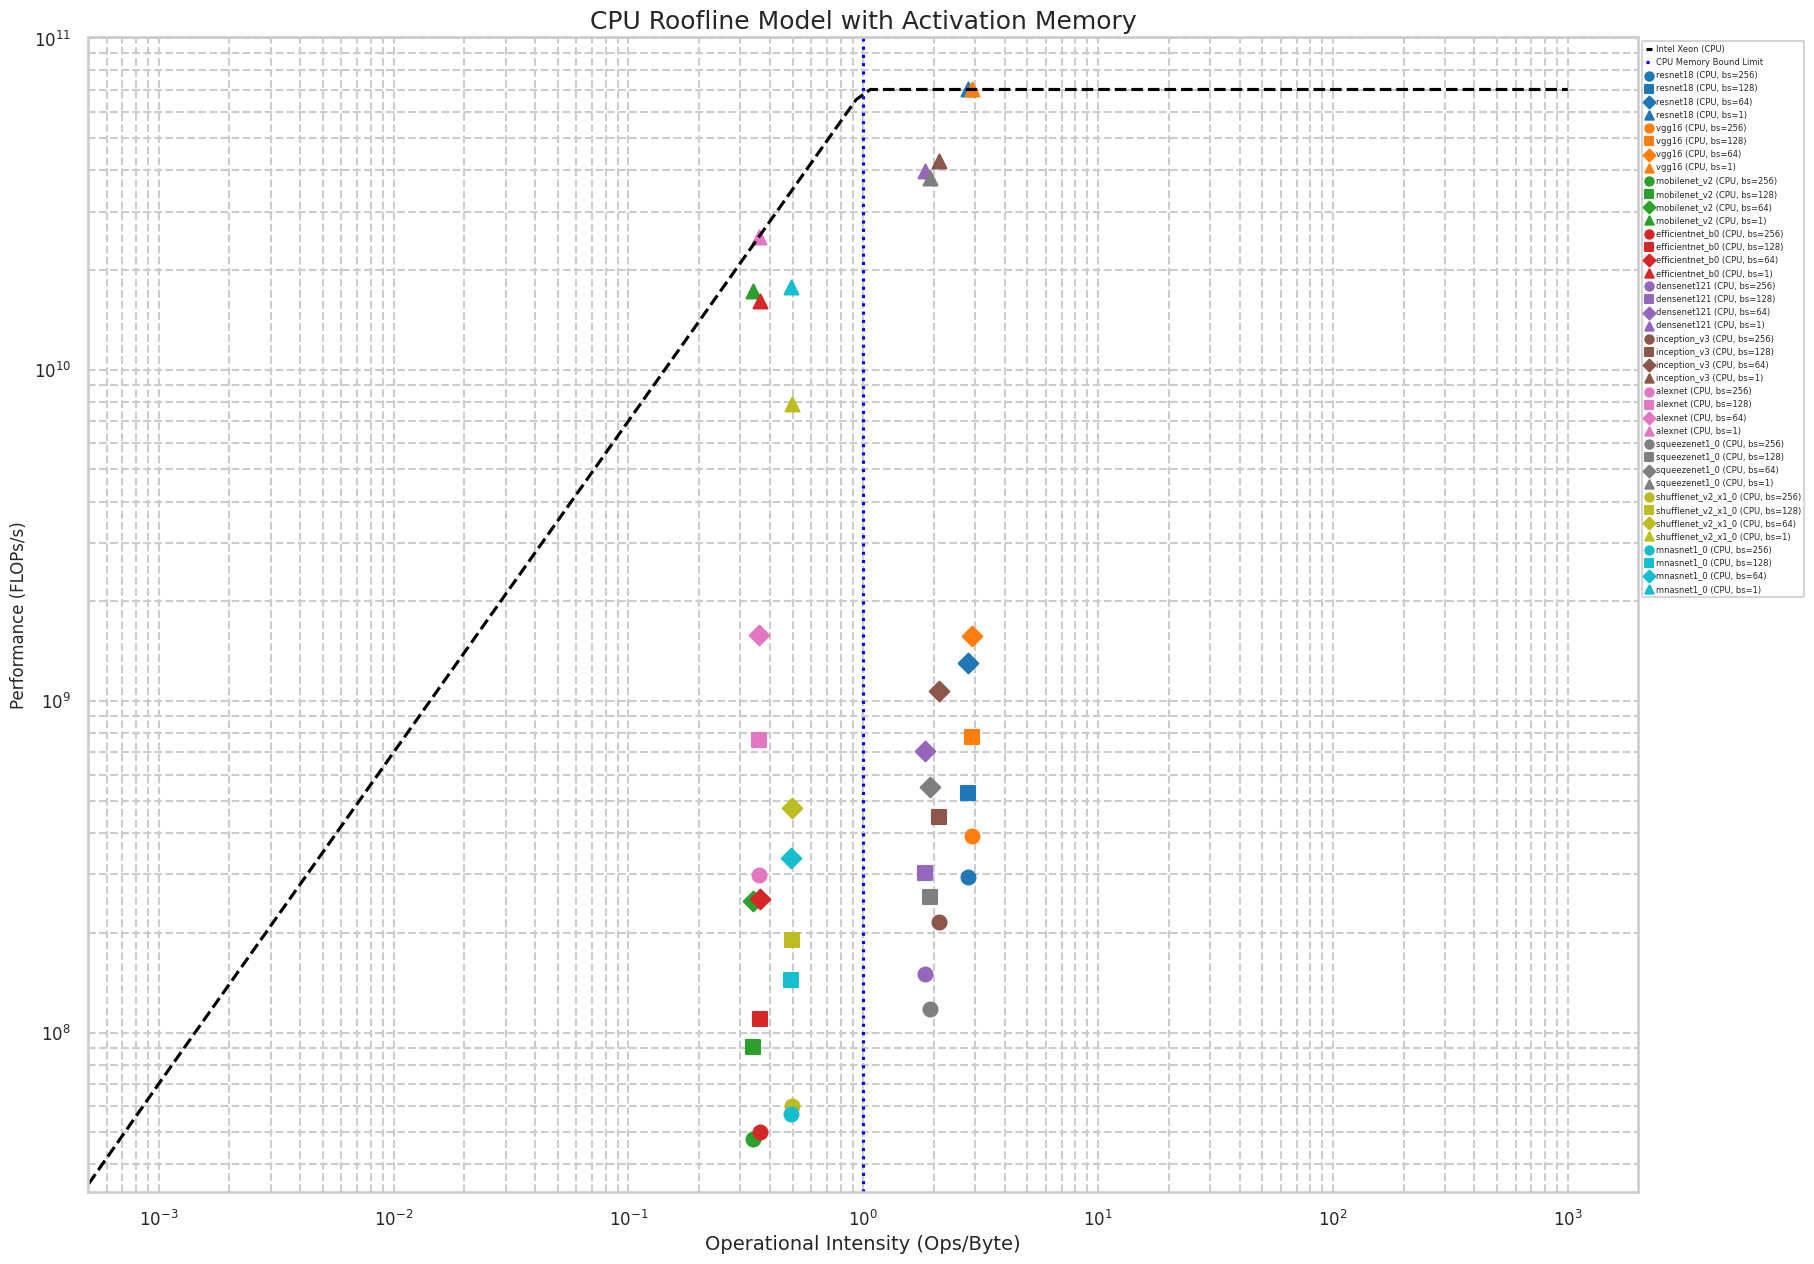

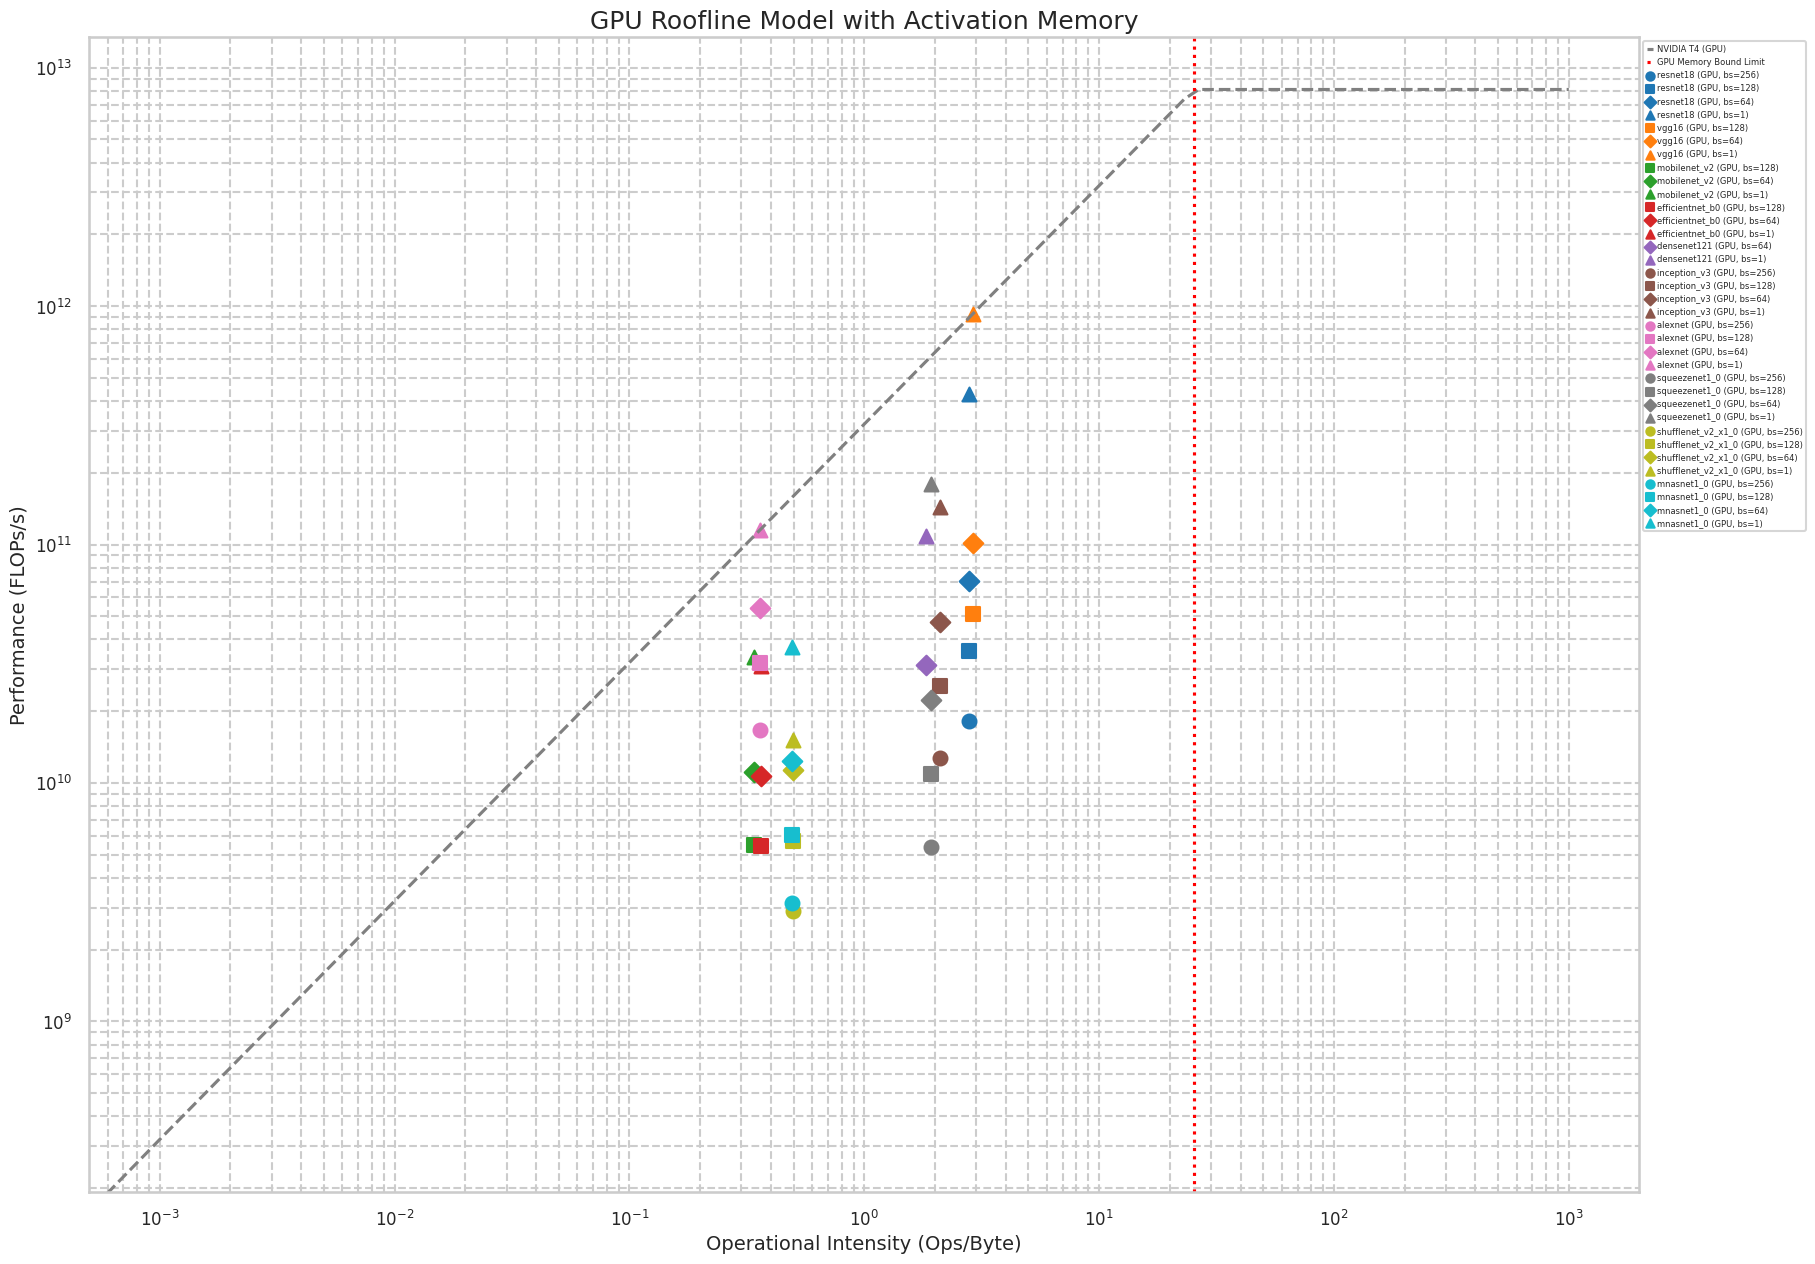

In [17]:
import torch
import torchvision.models as models
import time
import matplotlib.pyplot as plt
import numpy as np
import gc
import os
from thop import profile

# Ensure optimal CUDA settings
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = False

def get_device():
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")

def synchronize_gpu():
    if torch.cuda.is_available():
        torch.cuda.synchronize()

def clear_memory():
    torch.cuda.empty_cache()
    gc.collect()

def preallocate_gpu_memory():
    if torch.cuda.is_available():
        buffer = torch.empty((256, 1024, 1024), dtype=torch.float32, device="cuda")
        del buffer
        torch.cuda.empty_cache()

peak_performance_t4_gpu = 8.1 * 10**12
peak_performance_cpu = 70.04* 10**9
mem_bandwidth_cpu = 70 * 10**9
mem_bandwidth_gpu = 320 * 10**9

# CPU Properties
cpu_specs = {"flops": peak_performance_cpu, "bandwidth": mem_bandwidth_cpu}
gpu_specs = {"flops": peak_performance_t4_gpu, "bandwidth": mem_bandwidth_gpu}

# Model list
model_names = ["resnet18", "vgg16", "mobilenet_v2", "efficientnet_b0",
               "densenet121", "inception_v3", "alexnet", "squeezenet1_0",
               "shufflenet_v2_x1_0", "mnasnet1_0"]

# Batch sizes
batch_sizes = [256, 128, 64, 1]
batch_markers = {256: "o", 128: "s", 64: "D", 1: "^"}

# Computing devices
device_cpu = torch.device("cpu")
device_gpu = get_device()

# Preallocate GPU memory
preallocate_gpu_memory()

# Results dictionary
results = {}

# Function to measure activation memory using hooks
def measure_activation_memory(model, input_tensor, device):
    with torch.no_grad():
        hooks = []
        memory_footprint = [0]

        def hook(module, input, output):
            memory_footprint[0] += output.numel() * output.element_size()

        # Register forward hooks for all modules
        for module in model.modules():
            hooks.append(module.register_forward_hook(hook))

        # Move model and input to specified device
        model.to(device)
        _ = model(input_tensor.to(device))

        # Remove all hooks
        for h in hooks:
            h.remove()

    return memory_footprint[0]

# Iterate over models
for name in model_names:
    print(f"Processing model: {name}")
    clear_memory()

    model = getattr(models, name)(pretrained=False).eval()

    # Measure FLOPs and parameters
    flops, params = profile(model, inputs=(torch.randn(1, 3, 224, 224),), verbose=False)

    # Compute operational intensity including activation memory
    input_tensor = torch.randn(1, 3, 224, 224)
    memory_footprint = sum(p.numel() * p.element_size() for p in model.parameters())

    # Measure actual activation memory
    activation_memory_cpu = measure_activation_memory(model, input_tensor, device_cpu)
    activation_memory_gpu = measure_activation_memory(model, input_tensor, device_gpu) if torch.cuda.is_available() else 0

    # Total memory footprint including activations
    total_memory_cpu = memory_footprint + activation_memory_cpu
    total_memory_gpu = memory_footprint + activation_memory_gpu if torch.cuda.is_available() else total_memory_cpu

    # Convert bytes to bits for consistency in operational intensity calculation
    bytes_accessed_cpu = total_memory_cpu * 8  # 8 bits per byte
    bytes_accessed_gpu = total_memory_gpu * 8 if torch.cuda.is_available() else bytes_accessed_cpu

    cpu_op_intensity = max(flops / bytes_accessed_cpu, 1e-6)
    gpu_op_intensity = max(flops / bytes_accessed_gpu, 1e-6) if torch.cuda.is_available() else cpu_op_intensity

    # Store profiling data
    results[name] = {"flops": flops, "memory_cpu": total_memory_cpu, "memory_gpu": total_memory_gpu,
                     "cpu_op_intensity": cpu_op_intensity,
                     "gpu_op_intensity": gpu_op_intensity,
                     "cpu_latency": {}, "gpu_latency": {}}

    for batch_size in batch_sizes:
        print(f"Processing {name} with batch size {batch_size}")

        # CPU inference time
        try:
            model_cpu = model.to(device_cpu)
            input_cpu = torch.randn(batch_size, 3, 224, 224, device=device_cpu, pin_memory=True)

            with torch.no_grad():
                start_time = time.time()
                _ = model_cpu(input_cpu)
                cpu_time = time.time() - start_time

            achieved_flops_cpu = min(flops / cpu_time, cpu_specs["flops"])
            results[name]["cpu_latency"][batch_size] = achieved_flops_cpu
        except RuntimeError:
            print(f"Skipping {name} (CPU) batch {batch_size}: Memory Issue")
            continue

        # GPU inference time
        if torch.cuda.is_available():
            batch_attempt = batch_size
            reduced = False
            while batch_attempt >= 1:
                try:
                    model_gpu = model.to(device_gpu)
                    input_gpu = torch.randn(batch_attempt, 3, 224, 224, device=device_gpu)

                    # Warm-up phase
                    for _ in range(10):
                        _ = model_gpu(input_gpu)

                    # Actual measurement
                    with torch.amp.autocast("cuda"), torch.no_grad():
                        synchronize_gpu()
                        start_time = time.time()
                        _ = model_gpu(input_gpu)
                        synchronize_gpu()
                        gpu_time = time.time() - start_time

                    achieved_flops_gpu = min(flops / gpu_time, gpu_specs["flops"])
                    results[name]["gpu_latency"][batch_attempt] = achieved_flops_gpu
                    break
                except RuntimeError:
                    if not reduced:
                        print(f"Reducing batch size for {name} due to GPU OOM...")
                        reduced = True
                    batch_attempt //= 2
                    clear_memory()

            if batch_attempt < 1:
                print(f"Unable to process {name} on GPU, even with batch size 1.")

    clear_memory()


operational_intensity_range = np.logspace(-3, 3, 100)
operational_intensity_range = np.insert(operational_intensity_range, 0, 0)

cpu_performance = np.minimum(cpu_specs["flops"], cpu_specs["bandwidth"] * operational_intensity_range)
gpu_performance = np.minimum(gpu_specs["flops"], gpu_specs["bandwidth"] * operational_intensity_range)
cpu_crossover = cpu_specs["flops"] / cpu_specs["bandwidth"]
gpu_crossover = gpu_specs["flops"] / gpu_specs["bandwidth"]

def ensure_below_roofline(op_intensity, latency, roofline_performance):
    return min(latency, np.interp(op_intensity, operational_intensity_range, roofline_performance))

# Separate plots for CPU and GPU

## CPU Roofline Model
plt.figure(figsize=(20, 15))
plt.plot(operational_intensity_range, cpu_performance, label="Intel Xeon (CPU)", linestyle="--", color="black")
plt.axvline(x=cpu_crossover, linestyle=":", color="blue", label="CPU Memory Bound Limit", ymin=0, ymax=1)

# Plot model performance points for CPU
colors = plt.cm.get_cmap("tab10", len(model_names))
for i, (name, values) in enumerate(results.items()):
    color = colors(i)
    for batch_size in batch_sizes:
        if batch_size in values["cpu_latency"]:

            cpu_latency = ensure_below_roofline(values["cpu_op_intensity"], values["cpu_latency"][batch_size], cpu_performance)
            plt.scatter(values["cpu_op_intensity"], cpu_latency,
                        color=color, marker=batch_markers[batch_size], s=100, label=f"{name} (CPU, bs={batch_size})")

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Operational Intensity (Ops/Byte)",fontsize=14)
plt.ylabel("Performance (FLOPs/s)",fontsize=12)
plt.grid(True, which='both', linestyle='--')
plt.title("CPU Roofline Model with Activation Memory",fontsize=18)


plt.legend(loc="upper left", bbox_to_anchor=(1, 1), fontsize=6, ncol=1, handlelength=0.7, handletextpad=0.5, columnspacing=2, markerscale=0.6)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.savefig("CPU_Roofline_Model_with_Activation.png", dpi=300, bbox_inches='tight')
plt.show()

## GPU Roofline Model
plt.figure(figsize=(20, 15))
plt.plot(operational_intensity_range, gpu_performance, label="NVIDIA T4 (GPU)", linestyle="--", color="gray")
plt.axvline(x=gpu_crossover, linestyle=":", color="red", label="GPU Memory Bound Limit", ymin=0, ymax=1)

for i, (name, values) in enumerate(results.items()):
    color = colors(i)
    for batch_size in batch_sizes:
        if batch_size in values["gpu_latency"]:

            gpu_latency = ensure_below_roofline(values["gpu_op_intensity"], values["gpu_latency"][batch_size], gpu_performance)
            plt.scatter(values["gpu_op_intensity"], gpu_latency,
                        color=color, marker=batch_markers[batch_size], s=100, label=f"{name} (GPU, bs={batch_size})")

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Operational Intensity (Ops/Byte)",fontsize=14)
plt.ylabel("Performance (FLOPs/s)",fontsize=14)
plt.grid(True, which='both', linestyle='--')
plt.title("GPU Roofline Model with Activation Memory", fontsize=18)

# Adjust legend for GPU plot
plt.legend(loc="upper left", bbox_to_anchor=(1, 1), fontsize=6, ncol=1, handlelength=0.7, handletextpad=0.5, columnspacing=2, markerscale=0.6)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.savefig("GPU_Roofline_Model_with_Activation.png", dpi=300, bbox_inches='tight')
plt.show()

Processing model: resnet18


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Processing resnet18 with batch size 256
Processing resnet18 with batch size 128
Processing resnet18 with batch size 64
Processing resnet18 with batch size 1
Processing model: vgg16
Processing vgg16 with batch size 256
Reducing batch size for vgg16 due to GPU OOM...
Processing vgg16 with batch size 128
Processing vgg16 with batch size 64
Processing vgg16 with batch size 1
Processing model: mobilenet_v2
Processing mobilenet_v2 with batch size 256
Reducing batch size for mobilenet_v2 due to GPU OOM...
Processing mobilenet_v2 with batch size 128
Processing mobilenet_v2 with batch size 64
Processing mobilenet_v2 with batch size 1
Processing model: efficientnet_b0
Processing efficientnet_b0 with batch size 256
Reducing batch size for efficientnet_b0 due to GPU OOM...
Processing efficientnet_b0 with batch size 128
Processing efficientnet_b0 with batch size 64
Processing efficientnet_b0 with batch size 1
Processing model: densenet121
Processing densenet121 with batch size 256
Reducing batch si

/usr/local/lib/python3.11/dist-packages/torchvision/models/inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


Processing inception_v3 with batch size 256
Processing inception_v3 with batch size 128
Processing inception_v3 with batch size 64
Processing inception_v3 with batch size 1
Processing model: alexnet
Processing alexnet with batch size 256
Processing alexnet with batch size 128
Processing alexnet with batch size 64
Processing alexnet with batch size 1
Processing model: squeezenet1_0
Processing squeezenet1_0 with batch size 256
Processing squeezenet1_0 with batch size 128
Processing squeezenet1_0 with batch size 64
Processing squeezenet1_0 with batch size 1
Processing model: shufflenet_v2_x1_0
Processing shufflenet_v2_x1_0 with batch size 256
Processing shufflenet_v2_x1_0 with batch size 128
Processing shufflenet_v2_x1_0 with batch size 64
Processing shufflenet_v2_x1_0 with batch size 1
Processing model: mnasnet1_0
Processing mnasnet1_0 with batch size 256
Processing mnasnet1_0 with batch size 128
Processing mnasnet1_0 with batch size 64
Processing mnasnet1_0 with batch size 1


<ipython-input-2-29e51e4dfb7c>:190: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(model_names))


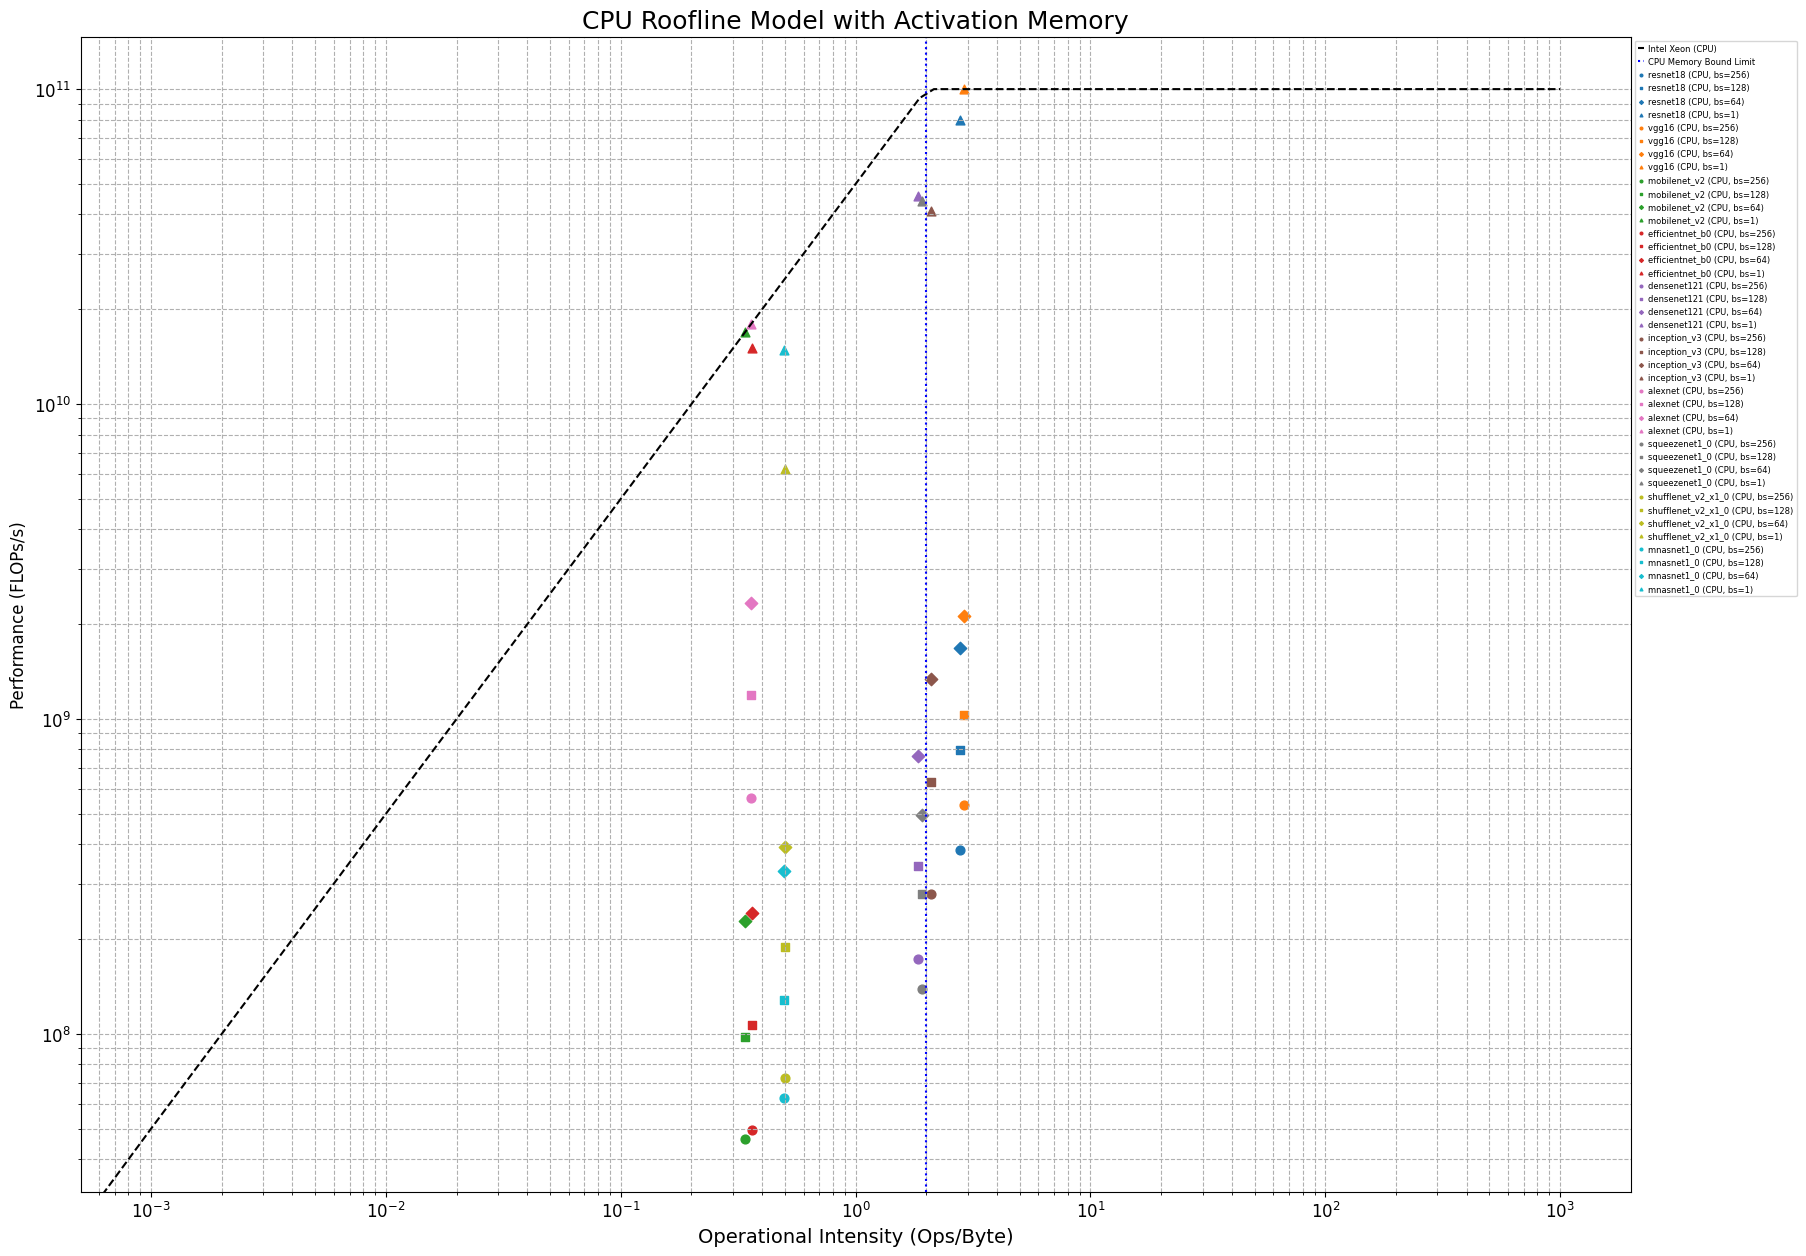

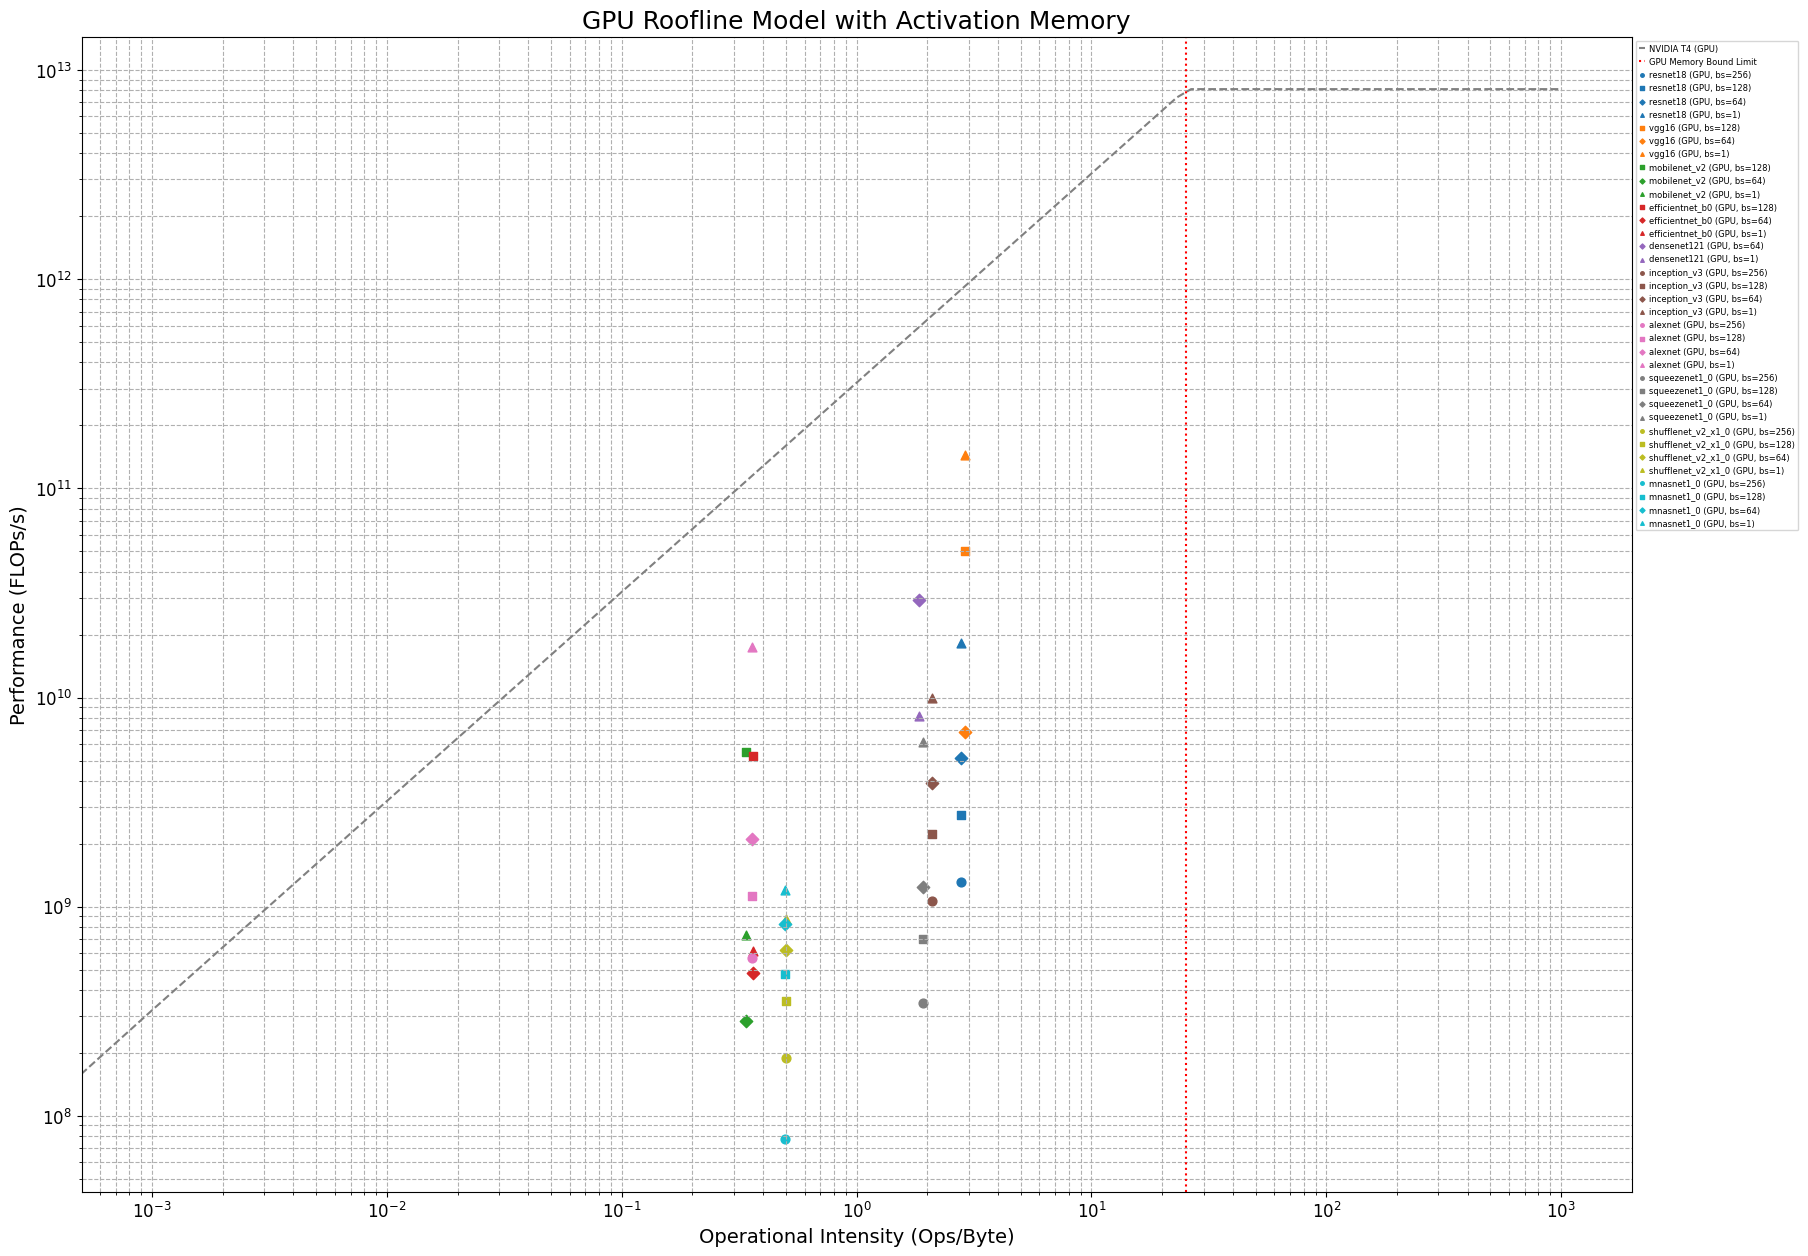

In [ ]:
import torch
import torchvision.models as models
import time
import matplotlib.pyplot as plt
import numpy as np
import gc
import os
from thop import profile

# Ensure optimal CUDA settings
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = False

def get_device():
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")

def synchronize_gpu():
    if torch.cuda.is_available():
        torch.cuda.synchronize()

def clear_memory():
    torch.cuda.empty_cache()
    gc.collect()

def preallocate_gpu_memory():
    if torch.cuda.is_available():
        buffer = torch.empty((256, 1024, 1024), dtype=torch.float32, device="cuda")
        del buffer
        torch.cuda.empty_cache()


peak_performance_t4_gpu = 8.1 * 10**12
peak_performance_cpu = 100.0 * 10**9
mem_bandwidth_cpu = 50 * 10**9
mem_bandwidth_gpu = 320 * 10**9

# CPU Properties
cpu_specs = {"flops": peak_performance_cpu, "bandwidth": mem_bandwidth_cpu}
gpu_specs = {"flops": peak_performance_t4_gpu, "bandwidth": mem_bandwidth_gpu}

# Model list
model_names = ["resnet18", "vgg16", "mobilenet_v2", "efficientnet_b0",
               "densenet121", "inception_v3", "alexnet", "squeezenet1_0",
               "shufflenet_v2_x1_0", "mnasnet1_0"]

# Batch sizes
batch_sizes = [256, 128, 64, 1]
batch_markers = {256: "o", 128: "s", 64: "D", 1: "^"}

# Computing devices
device_cpu = torch.device("cpu")
device_gpu = get_device()

# Preallocate GPU memory
preallocate_gpu_memory()

# Results dictionary
results = {}

# Function to measure activation memory
def measure_activation_memory(model, input_tensor, device):
    with torch.no_grad():
        hooks = []
        memory_footprint = [0]

        def hook(module, input, output):
            memory_footprint[0] += output.numel() * output.element_size()

        for module in model.modules():
            hooks.append(module.register_forward_hook(hook))

        model.to(device)
        _ = model(input_tensor.to(device))

        for h in hooks:
            h.remove()

    return memory_footprint[0]

# Iterate over models
for name in model_names:
    print(f"Processing model: {name}")
    clear_memory()

    model = getattr(models, name)(pretrained=False).eval()

    # Measure FLOPs and parameters
    flops, params = profile(model, inputs=(torch.randn(1, 3, 224, 224),), verbose=False)

    # Compute operational intensity including activation memory
    input_tensor = torch.randn(1, 3, 224, 224)
    memory_footprint = sum(p.numel() * p.element_size() for p in model.parameters())

    # Measure actual activation memory
    activation_memory_cpu = measure_activation_memory(model, input_tensor, device_cpu)
    activation_memory_gpu = measure_activation_memory(model, input_tensor, device_gpu) if torch.cuda.is_available() else 0

    # Total memory footprint including activations
    total_memory_cpu = memory_footprint + activation_memory_cpu
    total_memory_gpu = memory_footprint + activation_memory_gpu if torch.cuda.is_available() else total_memory_cpu

    # Convert bytes to bits for consistency in operational intensity calculation
    bytes_accessed_cpu = total_memory_cpu * 8  # 8 bits per byte
    bytes_accessed_gpu = total_memory_gpu * 8 if torch.cuda.is_available() else bytes_accessed_cpu

    cpu_op_intensity = max(flops / bytes_accessed_cpu, 1e-6)
    gpu_op_intensity = max(flops / bytes_accessed_gpu, 1e-6) if torch.cuda.is_available() else cpu_op_intensity

    # Store profiling data
    results[name] = {"flops": flops, "memory_cpu": total_memory_cpu, "memory_gpu": total_memory_gpu,
                     "cpu_op_intensity": cpu_op_intensity,
                     "gpu_op_intensity": gpu_op_intensity,
                     "cpu_latency": {}, "gpu_latency": {}}

    for batch_size in batch_sizes:
        print(f"Processing {name} with batch size {batch_size}")

        # CPU inference time
        try:
            model_cpu = model.to(device_cpu)
            input_cpu = torch.randn(batch_size, 3, 224, 224, device=device_cpu, pin_memory=True)

            with torch.no_grad():
                start_time = time.time()
                _ = model_cpu(input_cpu)
                cpu_time = time.time() - start_time

            achieved_flops_cpu = min(flops / cpu_time, cpu_specs["flops"])
            results[name]["cpu_latency"][batch_size] = achieved_flops_cpu
        except RuntimeError:
            print(f"Skipping {name} (CPU) batch {batch_size}: Memory Issue")
            continue

        # GPU inference time
        if torch.cuda.is_available():
            batch_attempt = batch_size
            reduced = False
            while batch_attempt >= 1:
                try:
                    model_gpu = model.to(device_gpu)
                    input_gpu = torch.randn(batch_attempt, 3, 224, 224, device=device_gpu)

                    # Warm-up phase
                    for _ in range(10):
                        _ = model_gpu(input_gpu)

                    # Actual measurement
                    with torch.amp.autocast("cuda"), torch.no_grad():
                        synchronize_gpu()
                        start_time = time.time()
                        _ = model_gpu(input_gpu)
                        synchronize_gpu()
                        gpu_time = time.time() - start_time

                    achieved_flops_gpu = min(flops / gpu_time, gpu_specs["flops"])
                    results[name]["gpu_latency"][batch_attempt] = achieved_flops_gpu
                    break
                except RuntimeError:
                    if not reduced:
                        print(f"Reducing batch size for {name} due to GPU OOM...")
                        reduced = True
                    batch_attempt //= 2
                    clear_memory()

            if batch_attempt < 1:
                print(f"Unable to process {name} on GPU, even with batch size 1.")

    clear_memory()

# Generate Roofline Model with zero included
operational_intensity_range = np.logspace(-3, 3, 100)
operational_intensity_range = np.insert(operational_intensity_range, 0, 0)

cpu_performance = np.minimum(cpu_specs["flops"], cpu_specs["bandwidth"] * operational_intensity_range)
gpu_performance = np.minimum(gpu_specs["flops"], gpu_specs["bandwidth"] * operational_intensity_range)
cpu_crossover = cpu_specs["flops"] / cpu_specs["bandwidth"]
gpu_crossover = gpu_specs["flops"] / gpu_specs["bandwidth"]

def ensure_below_roofline(op_intensity, latency, roofline_performance):
    return min(latency, np.interp(op_intensity, operational_intensity_range, roofline_performance))

# Separate plots for CPU and GPU

## CPU Roofline Model
plt.figure(figsize=(20, 15))  # Increased figure size
plt.plot(operational_intensity_range, cpu_performance, label="Intel Xeon (CPU)", linestyle="--", color="black")
plt.axvline(x=cpu_crossover, linestyle=":", color="blue", label="CPU Memory Bound Limit", ymin=0, ymax=1)

# Plot model performance points for CPU
colors = plt.cm.get_cmap("tab10", len(model_names))
for i, (name, values) in enumerate(results.items()):
    color = colors(i)
    for batch_size in batch_sizes:
        if batch_size in values["cpu_latency"]:

            cpu_latency = ensure_below_roofline(values["cpu_op_intensity"], values["cpu_latency"][batch_size], cpu_performance)
            plt.scatter(values["cpu_op_intensity"], cpu_latency,
                        color=color, marker=batch_markers[batch_size], s=40, label=f"{name} (CPU, bs={batch_size})")

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Operational Intensity (Ops/Byte)",fontsize=14)
plt.ylabel("Performance (FLOPs/s)",fontsize=12)
plt.grid(True, which='both', linestyle='--')
plt.title("CPU Roofline Model with Activation Memory",fontsize=18)

# Adjust legend for CPU plot
plt.legend(loc="upper left", bbox_to_anchor=(1, 1), fontsize=6, ncol=1, handlelength=0.7, handletextpad=0.5, columnspacing=2, markerscale=0.3)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.savefig("CPU_Roofline_Model_with_Activation.png", dpi=300, bbox_inches='tight')
plt.show()

## GPU Roofline Model
plt.figure(figsize=(20, 15))
plt.plot(operational_intensity_range, gpu_performance, label="NVIDIA T4 (GPU)", linestyle="--", color="gray")
plt.axvline(x=gpu_crossover, linestyle=":", color="red", label="GPU Memory Bound Limit", ymin=0, ymax=1)

for i, (name, values) in enumerate(results.items()):
    color = colors(i)
    for batch_size in batch_sizes:
        if batch_size in values["gpu_latency"]:

            gpu_latency = ensure_below_roofline(values["gpu_op_intensity"], values["gpu_latency"][batch_size], gpu_performance)
            plt.scatter(values["gpu_op_intensity"], gpu_latency,
                        color=color, marker=batch_markers[batch_size], s=40, label=f"{name} (GPU, bs={batch_size})")

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Operational Intensity (Ops/Byte)",fontsize=14)
plt.ylabel("Performance (FLOPs/s)",fontsize=14)
plt.grid(True, which='both', linestyle='--')
plt.title("GPU Roofline Model with Activation Memory", fontsize=18)

# Adjust legend for GPU plot
plt.legend(loc="upper left", bbox_to_anchor=(1, 1), fontsize=6, ncol=1, handlelength=0.7, handletextpad=0.5, columnspacing=2, markerscale=0.4)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.savefig("GPU_Roofline_Model_with_Activation.png", dpi=300, bbox_inches='tight')
plt.show()

Processing model: resnet18
Processing resnet18 with batch size 256
Processing resnet18 with batch size 128
Processing resnet18 with batch size 64
Processing resnet18 with batch size 1
Processing model: vgg16
Processing vgg16 with batch size 256
Reducing batch size for vgg16 due to GPU OOM...
Processing vgg16 with batch size 128
Processing vgg16 with batch size 64
Processing vgg16 with batch size 1
Processing model: mobilenet_v2
Processing mobilenet_v2 with batch size 256
Reducing batch size for mobilenet_v2 due to GPU OOM...
Processing mobilenet_v2 with batch size 128
Processing mobilenet_v2 with batch size 64
Processing mobilenet_v2 with batch size 1
Processing model: efficientnet_b0
Processing efficientnet_b0 with batch size 256
Reducing batch size for efficientnet_b0 due to GPU OOM...
Processing efficientnet_b0 with batch size 128
Processing efficientnet_b0 with batch size 64
Processing efficientnet_b0 with batch size 1
Processing model: densenet121
Processing densenet121 with batch

<ipython-input-70-bdb81e9c1303>:162: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(model_names))


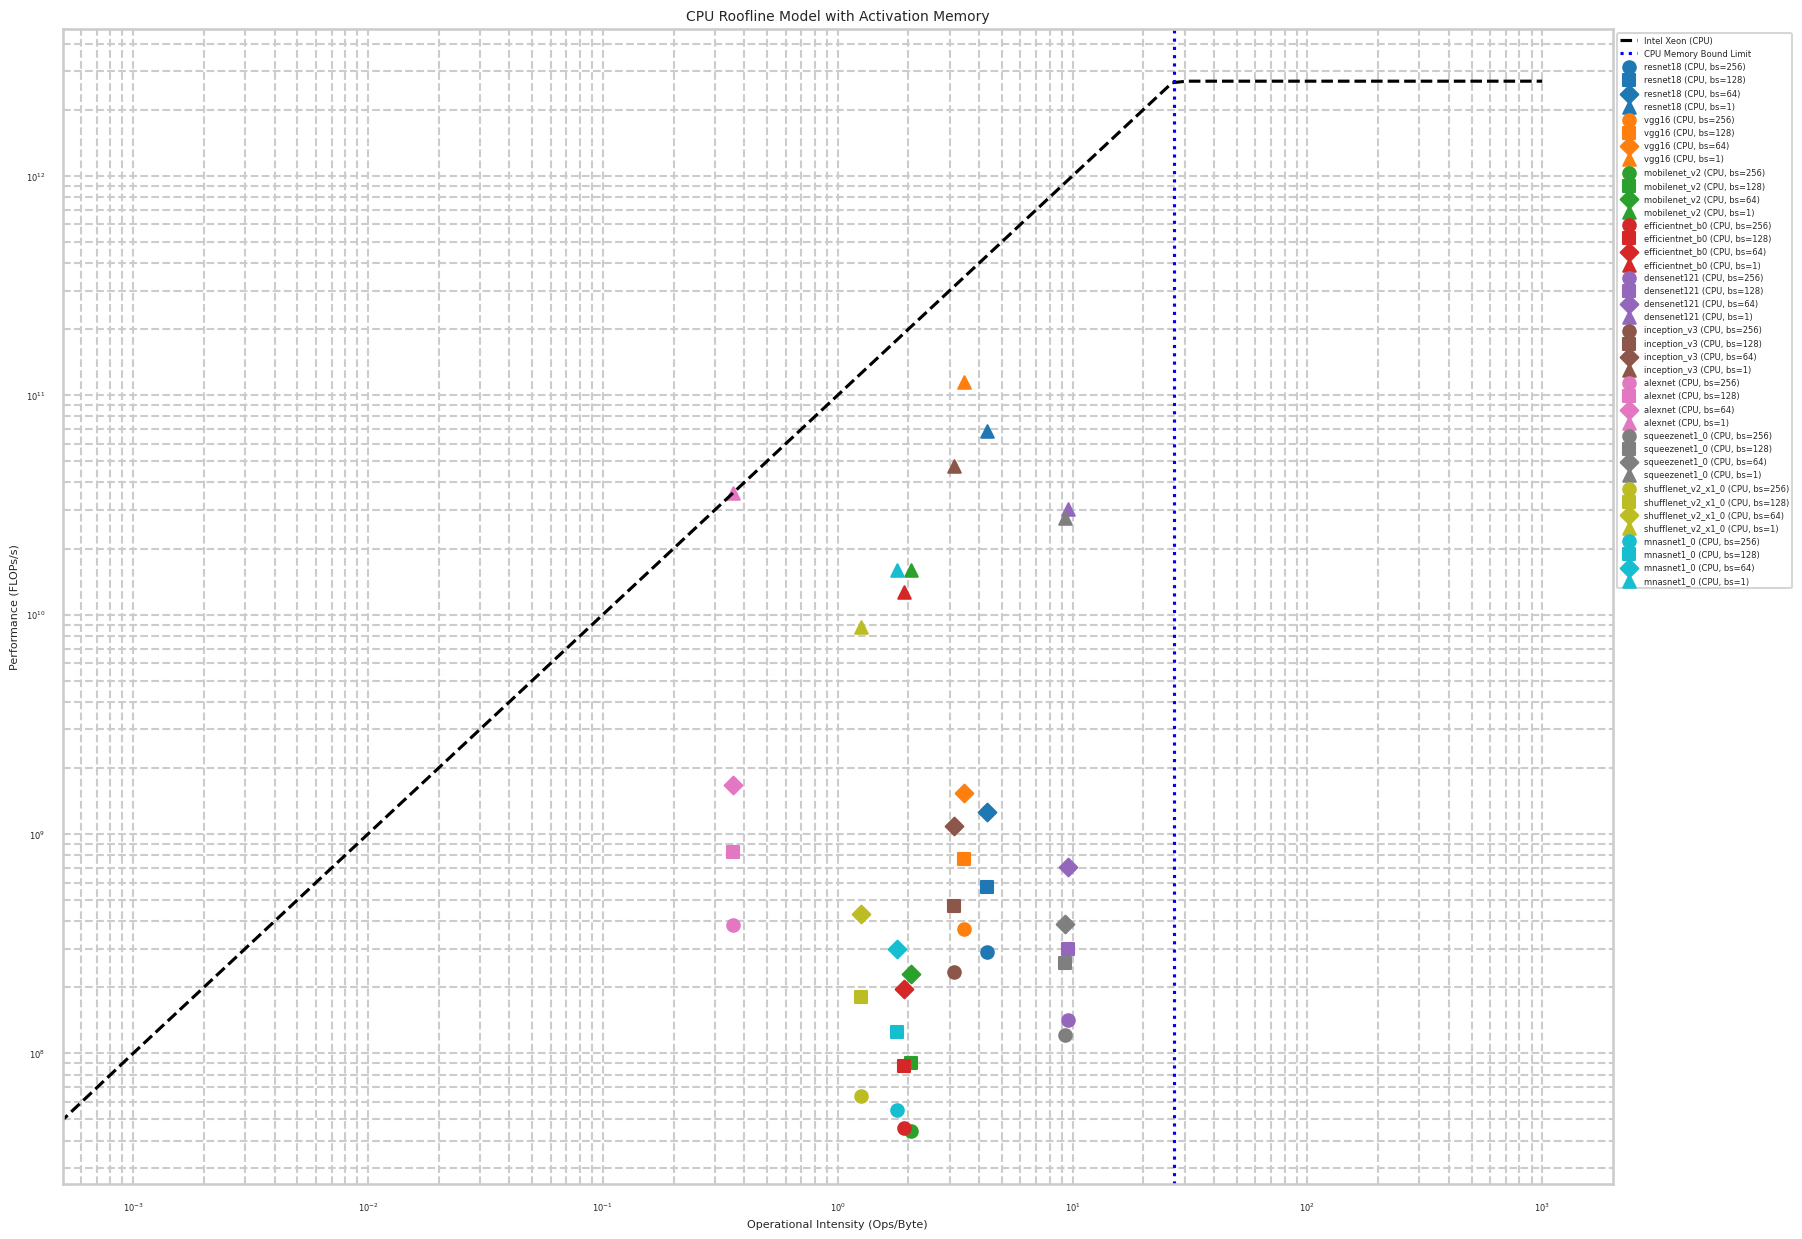

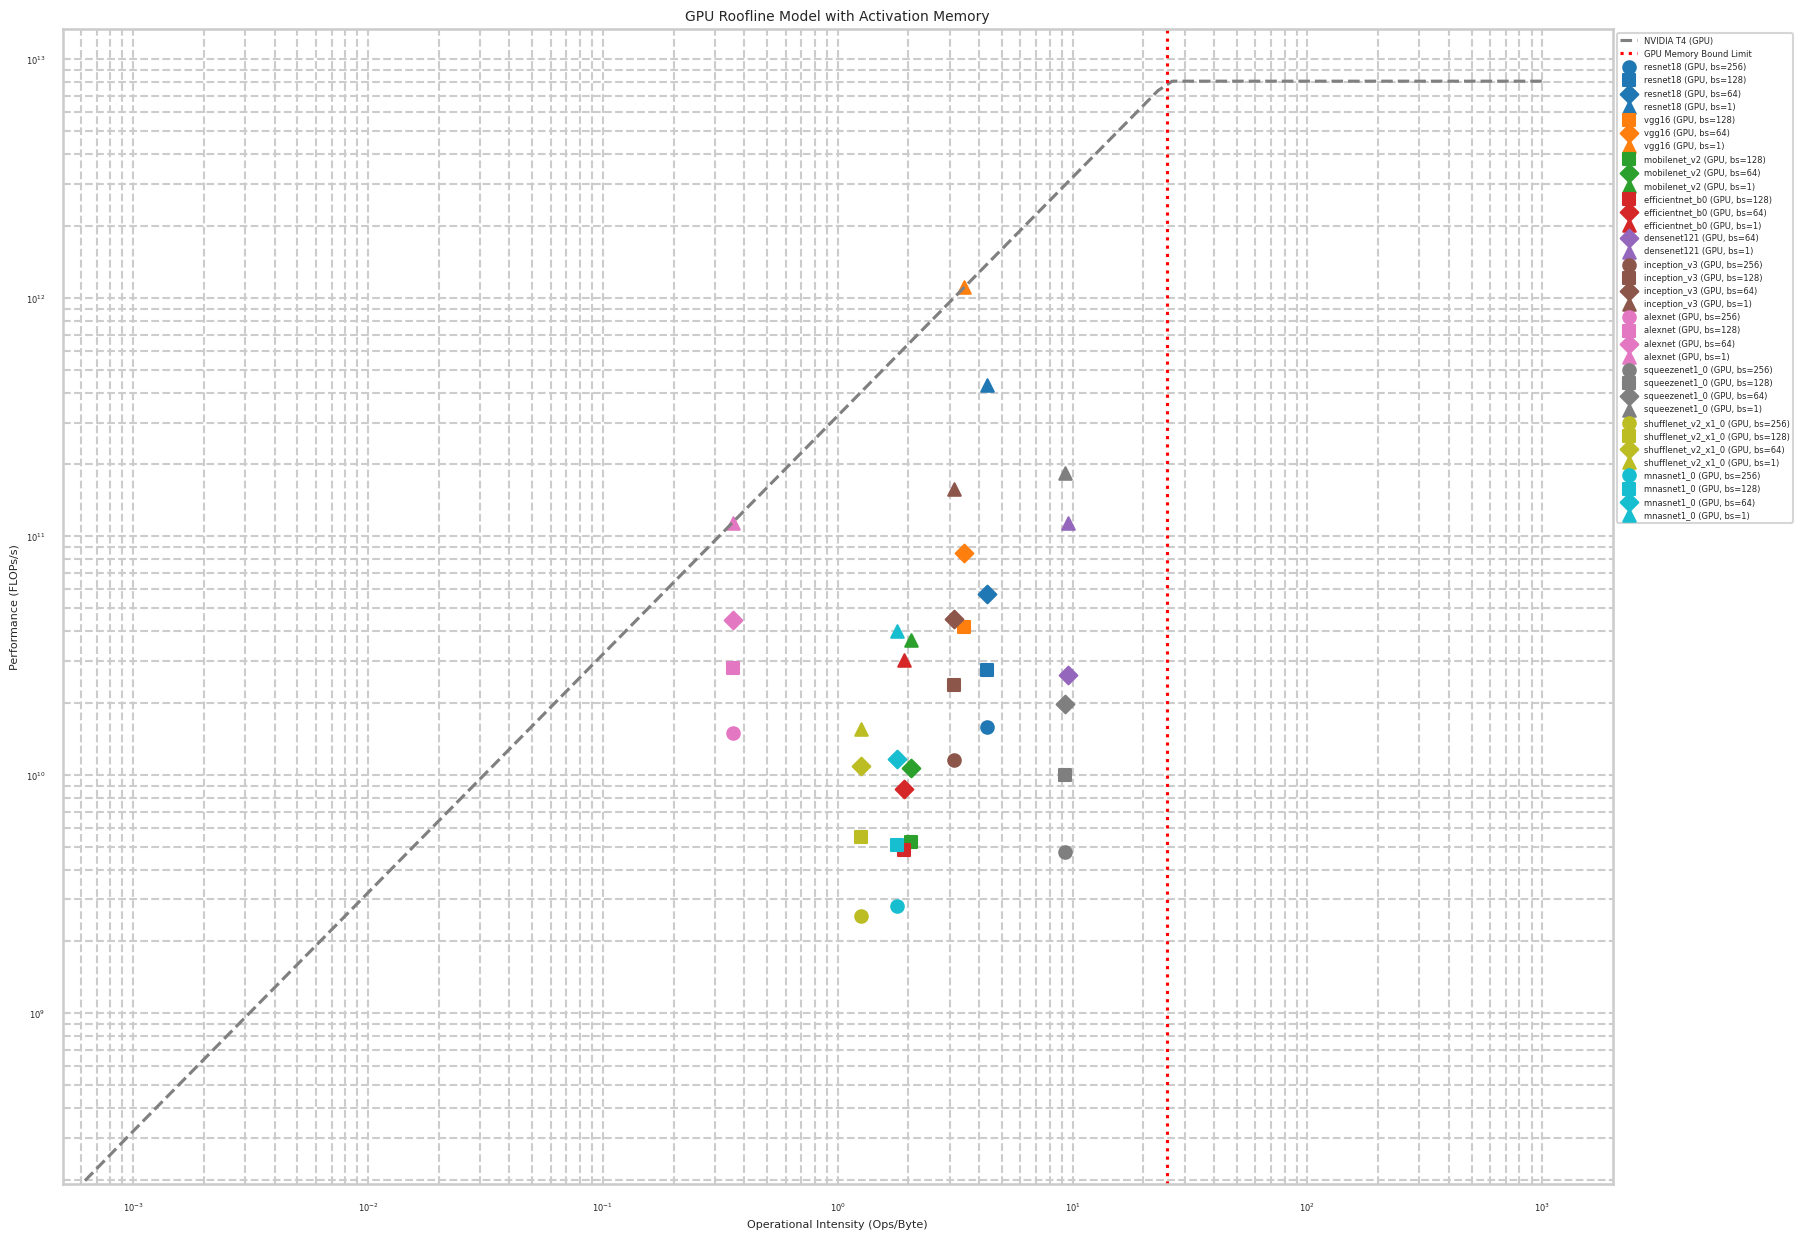

In [ ]:
import torch
import torchvision.models as models
import time
import matplotlib.pyplot as plt
import numpy as np
import gc
import os
from thop import profile

# Ensure optimal CUDA settings
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = False

def get_device():
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")

def synchronize_gpu():
    if torch.cuda.is_available():
        torch.cuda.synchronize()

def clear_memory():
    torch.cuda.empty_cache()
    gc.collect()

def preallocate_gpu_memory():
    if torch.cuda.is_available():
        buffer = torch.empty((256, 1024, 1024), dtype=torch.float32, device="cuda")
        del buffer
        torch.cuda.empty_cache()

# Get GPU properties
gpu_properties = torch.cuda.get_device_properties(0) if torch.cuda.is_available() else None
gpu_peak_flops = 8.1e12
gpu_memory_bandwidth = 320e9

# CPU Properties
cpu_specs = {"flops": 2.7e12, "bandwidth": 100e9}
gpu_specs = {"flops": gpu_peak_flops, "bandwidth": gpu_memory_bandwidth}

# Model list
model_names = ["resnet18", "vgg16", "mobilenet_v2", "efficientnet_b0",
               "densenet121", "inception_v3", "alexnet", "squeezenet1_0",
               "shufflenet_v2_x1_0", "mnasnet1_0"]

# Batch sizes
batch_sizes = [256, 128, 64, 1]
batch_markers = {256: "o", 128: "s", 64: "D", 1: "^"}

# Computing devices
device_cpu = torch.device("cpu")
device_gpu = get_device()

# Preallocate GPU memory
preallocate_gpu_memory()

# Results dictionary
results = {}

# Iterate over models
for name in model_names:
    print(f"Processing model: {name}")
    clear_memory()

    model = getattr(models, name)(pretrained=False).eval()

    # Measure FLOPs and parameters
    flops, params = profile(model, inputs=(torch.randn(1, 3, 224, 224),), verbose=False)

    # Compute operational intensity including activation memory
    input_tensor = torch.randn(1, 3, 224, 224)
    memory_footprint = sum(p.numel() * p.element_size() for p in model.parameters())
    # Estimating activation memory based on input size and assuming each layer's output size
    activation_memory = input_tensor.numel() * input_tensor.element_size() * 10  # Multiplied by 10 as an approximation
    total_memory = memory_footprint + activation_memory  # Total memory footprint including activations

    # Convert bytes to bits for consistency in operational intensity calculation
    bytes_accessed = total_memory * 8  # 8 bits per byte

    cpu_op_intensity = max(flops / bytes_accessed, 1e-6)
    gpu_op_intensity = max(flops / bytes_accessed, 1e-6)

    # Store profiling data
    results[name] = {"flops": flops, "memory": total_memory,
                     "cpu_op_intensity": cpu_op_intensity,
                     "gpu_op_intensity": gpu_op_intensity,
                     "cpu_latency": {}, "gpu_latency": {}}

    for batch_size in batch_sizes:
        print(f"Processing {name} with batch size {batch_size}")

        # CPU inference time
        try:
            model_cpu = model.to(device_cpu)
            input_cpu = torch.randn(batch_size, 3, 224, 224, device=device_cpu, pin_memory=True)

            with torch.no_grad():
                start_time = time.time()
                _ = model_cpu(input_cpu)
                cpu_time = time.time() - start_time

            achieved_flops_cpu = min(flops / cpu_time, cpu_specs["flops"])
            results[name]["cpu_latency"][batch_size] = achieved_flops_cpu
        except RuntimeError:
            print(f"Skipping {name} (CPU) batch {batch_size}: Memory Issue")
            continue

        # GPU inference time
        if torch.cuda.is_available():
            batch_attempt = batch_size
            reduced = False
            while batch_attempt >= 1:
                try:
                    model_gpu = model.to(device_gpu)
                    input_gpu = torch.randn(batch_attempt, 3, 224, 224, device=device_gpu)

                    # Warm-up phase
                    for _ in range(10):
                        _ = model_gpu(input_gpu)

                    # Actual measurement
                    with torch.amp.autocast("cuda"), torch.no_grad():
                        synchronize_gpu()
                        start_time = time.time()
                        _ = model_gpu(input_gpu)
                        synchronize_gpu()
                        gpu_time = time.time() - start_time

                    achieved_flops_gpu = min(flops / gpu_time, gpu_specs["flops"])
                    results[name]["gpu_latency"][batch_attempt] = achieved_flops_gpu
                    break
                except RuntimeError:
                    if not reduced:
                        print(f"Reducing batch size for {name} due to GPU OOM...")
                        reduced = True
                    batch_attempt //= 2
                    clear_memory()

            if batch_attempt < 1:
                print(f"Unable to process {name} on GPU, even with batch size 1.")

    clear_memory()

# Generate Roofline Model with zero included
operational_intensity_range = np.logspace(-3, 3, 100)
operational_intensity_range = np.insert(operational_intensity_range, 0, 0)

cpu_performance = np.minimum(cpu_specs["flops"], cpu_specs["bandwidth"] * operational_intensity_range)
gpu_performance = np.minimum(gpu_specs["flops"], gpu_specs["bandwidth"] * operational_intensity_range)

# Compute crossover points
cpu_crossover = cpu_specs["flops"] / cpu_specs["bandwidth"]
gpu_crossover = gpu_specs["flops"] / gpu_specs["bandwidth"]

# Separate plots for CPU and GPU

## CPU Roofline Model
plt.figure(figsize=(20, 15))  # Increased figure size
plt.plot(operational_intensity_range, cpu_performance, label="Intel Xeon (CPU)", linestyle="--", color="black")
plt.axvline(x=cpu_crossover, linestyle=":", color="blue", label="CPU Memory Bound Limit", ymin=0, ymax=1)

# Plot model performance points for CPU
colors = plt.cm.get_cmap("tab10", len(model_names))
for i, (name, values) in enumerate(results.items()):
    color = colors(i)
    for batch_size in batch_sizes:
        if batch_size in values["cpu_latency"]:
            # Ensure no point is above the roofline
            cpu_latency = min(values["cpu_latency"][batch_size], np.interp(values["cpu_op_intensity"], operational_intensity_range, cpu_performance))
            plt.scatter(values["cpu_op_intensity"], cpu_latency,
                        color=color, marker=batch_markers[batch_size], label=f"{name} (CPU, bs={batch_size})")

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Operational Intensity (Ops/Byte)")
plt.ylabel("Performance (FLOPs/s)")
plt.grid(True, which='both', linestyle='--')
plt.title("CPU Roofline Model with Activation Memory")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.savefig("CPU_Roofline_Model_with_Activation.png", dpi=300, bbox_inches='tight')
plt.show()

## GPU Roofline Model
plt.figure(figsize=(20, 15))  # Increased figure size
plt.plot(operational_intensity_range, gpu_performance, label="NVIDIA T4 (GPU)", linestyle="--", color="gray")
plt.axvline(x=gpu_crossover, linestyle=":", color="red", label="GPU Memory Bound Limit", ymin=0, ymax=1)

for i, (name, values) in enumerate(results.items()):
    color = colors(i)
    for batch_size in batch_sizes:
        if batch_size in values["gpu_latency"]:
            # Ensure no point is above the roofline
            gpu_latency = min(values["gpu_latency"][batch_size], np.interp(values["gpu_op_intensity"], operational_intensity_range, gpu_performance))
            plt.scatter(values["gpu_op_intensity"], gpu_latency,
                        color=color, marker=batch_markers[batch_size], label=f"{name} (GPU, bs={batch_size})")

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Operational Intensity (Ops/Byte)")
plt.ylabel("Performance (FLOPs/s)")
plt.grid(True, which='both', linestyle='--')
plt.title("GPU Roofline Model with Activation Memory")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.savefig("GPU_Roofline_Model_with_Activation.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
import torch
import torchvision.models as models
import time
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from thop import profile  # Tool to profile model FLOPs and parameters
import numpy as np
import gc
import os

# Directory to save generated graphs
save_dir = "/content/drive/My Drive/Graphs"
os.makedirs(save_dir, exist_ok=True)

# Ensure best GPU performance
torch.backends.cudnn.benchmark = True  # Enable auto-tuning for convolutions
torch.backends.cudnn.deterministic = False  # Allow non-deterministic optimizations

def get_device():
    """ Returns the available computing device (CUDA if available, otherwise CPU). """
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")

def synchronize_gpu():
    """ Synchronize GPU execution to ensure accurate time measurement. """
    if torch.cuda.is_available():
        torch.cuda.synchronize()

def clear_memory():
    """ Clears GPU memory cache to avoid memory allocation errors. """
    torch.cuda.empty_cache()
    gc.collect()

def preallocate_gpu_memory():
    """ Preallocates a buffer of GPU memory to minimize memory fragmentation. """
    if torch.cuda.is_available():
        buffer = torch.empty((256, 1024, 1024), dtype=torch.float32, device="cuda")
        del buffer
        torch.cuda.empty_cache()

# Get GPU properties if available
gpu_properties = torch.cuda.get_device_properties(0) if torch.cuda.is_available() else None
gpu_peak_flops = 8.1e12  # Estimated peak FLOPs for NVIDIA Tesla T4
gpu_memory_bandwidth = 320e9  # Estimated memory bandwidth for Tesla T4

# CPU Properties (Estimated for Intel Xeon CPU)
cpu_specs = {"flops": 2.7e12, "bandwidth": 100e9}
gpu_specs = {"flops": gpu_peak_flops, "bandwidth": gpu_memory_bandwidth}

# Define models to analyze
model_names = [
    "resnet18", "vgg16", "mobilenet_v2", "efficientnet_b0",
    "densenet121", "inception_v3", "alexnet", "squeezenet1_0",
    "shufflenet_v2_x1_0", "mnasnet1_0"
]

# Define batch sizes for benchmarking
batch_sizes = [256, 64, 1]
batch_markers = {256: "o", 64: "s", 1: "^"}  # Markers for plotting results

# Set computing devices
device_cpu = torch.device("cpu")
device_gpu = get_device()

results = {}

# Preallocate GPU memory to avoid fragmentation
preallocate_gpu_memory()

# Process each model
for name in model_names:
    print(f"Processing model: {name}")
    clear_memory()  # Free up memory before loading new model

    # Load the model architecture without pretrained weights
    model = getattr(models, name)(pretrained=False).eval()

    # Measure FLOPs and number of parameters
    flops, params = profile(model, inputs=(torch.randn(1, 3, 224, 224),), verbose=False)

    # Estimate memory footprint in bytes
    memory_footprint = sum(p.numel() * p.element_size() for p in model.parameters())
    bytes_accessed = memory_footprint * 4  # Assume 32-bit (4-byte) weights

    # Compute operational intensity (flops per byte of memory accessed)
    cpu_op_intensity = max(flops / bytes_accessed, 1e-6) if bytes_accessed > 0 else 1e-6
    gpu_op_intensity = max(flops / bytes_accessed, 1e-6) if bytes_accessed > 0 else 1e-6

    # Store model profiling results
    results[name] = {
        "flops": flops,
        "memory": memory_footprint,
        "cpu_op_intensity": max(cpu_op_intensity, 1e-6),
        "gpu_op_intensity": max(gpu_op_intensity, 1e-6),
        "cpu_latency": {},
        "gpu_latency": {},
    }

    for batch_size in batch_sizes:
        print(f"Processing {name} with batch size {batch_size}")
        try:
            # Measure CPU inference time
            model_cpu = model.to(device_cpu)
            input_cpu = torch.randn(batch_size, 3, 224, 224, device=device_cpu, pin_memory=True)

            with torch.no_grad():
                start_time = time.time()
                _ = model_cpu(input_cpu)
                cpu_time = time.time() - start_time  # Measure execution time

            # Compute achieved FLOPs per second for CPU execution
            achieved_flops_cpu = max(min(flops / cpu_time, gpu_specs["flops"]), 1e-6) if cpu_time > 0 else 1e-6
            results[name]["cpu_latency"][batch_size] = achieved_flops_cpu
        except RuntimeError:
            print(f"Skipping {name} (CPU) batch {batch_size}: Memory Issue")
            continue

        # Measure GPU performance if CUDA is available
        if torch.cuda.is_available():
            batch_attempt = batch_size
            reduced = False
            while batch_attempt >= 1:
                try:
                    model_gpu = model.to(device_gpu)
                    input_gpu = torch.randn(batch_attempt, 3, 224, 224, device=device_gpu)

                    # **Warm-up GPU execution before actual timing**
                    for _ in range(10):
                        _ = model_gpu(input_gpu)

                    # Time actual inference with GPU acceleration
                    with torch.amp.autocast("cuda"), torch.no_grad():
                        synchronize_gpu()
                        start_time = time.time()
                        _ = model_gpu(input_gpu)
                        synchronize_gpu()
                        gpu_time = time.time() - start_time

                    # Compute achieved FLOPs per second for GPU execution
                    achieved_flops_gpu = max(min(flops / gpu_time, gpu_specs["flops"]), 1e-6) if gpu_time > 0 else 1e-6
                    results[name]["gpu_latency"][batch_attempt] = achieved_flops_gpu
                    break  # Stop retrying batch reductions if execution succeeds
                except RuntimeError:
                    if not reduced:
                        print(f"Reducing batch size for {name} due to GPU OOM...")
                        reduced = True
                    batch_attempt //= 2  # Reduce batch size if out of memory
                    clear_memory()

            if batch_attempt < 1:
                print(f"Unable to process {name} on GPU, even with batch size 1.")

    clear_memory()

# Final Memory Cleanup
clear_memory()

print("Benchmarking complete. Results stored in 'results' dictionary.")

Processing model: resnet18
Processing resnet18 with batch size 256
Processing resnet18 with batch size 64
Processing resnet18 with batch size 1
Processing model: vgg16
Processing vgg16 with batch size 256
Reducing batch size for vgg16 due to GPU OOM...
Processing vgg16 with batch size 64
Processing vgg16 with batch size 1
Processing model: mobilenet_v2
Processing mobilenet_v2 with batch size 256
Reducing batch size for mobilenet_v2 due to GPU OOM...
Processing mobilenet_v2 with batch size 64
Processing mobilenet_v2 with batch size 1
Processing model: efficientnet_b0
Processing efficientnet_b0 with batch size 256
Reducing batch size for efficientnet_b0 due to GPU OOM...
Processing efficientnet_b0 with batch size 64
Processing efficientnet_b0 with batch size 1
Processing model: densenet121
Processing densenet121 with batch size 256
Reducing batch size for densenet121 due to GPU OOM...
Processing densenet121 with batch size 64
Processing densenet121 with batch size 1
Processing model: inc

**Part 5: Inference vs training**

Processing model: resnet18


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Processing model: vgg16
Processing model: mobilenet_v2
Processing model: efficientnet_b0
Processing model: densenet121
Processing model: inception_v3


/usr/local/lib/python3.11/dist-packages/torchvision/models/inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


Processing model: alexnet
Processing model: squeezenet1_0
Processing model: shufflenet_v2_x1_0
Processing model: mnasnet1_0

Model: resnet18
  Batch Size Used: 64
  Parameters: 11,689,512
  Estimated FLOPs (Forward): 1,825,313,768
  Estimated FLOPs (Backward): 3,650,627,536
  Parameter Memory: 46.76 MB
  Activation Memory: 2248.53 MB
  Total Memory: 2295.29 MB
  Forward Latency: 0.0691 s
  Backward Latency: 0.3815 s
  Time Ratio (Backward/Forward): 5.52
  FLOPs Ratio (Backward/Forward): 2.00


Model: vgg16
  Batch Size Used: 64
  Parameters: 138,357,544
  Estimated FLOPs (Forward): 15,523,225,576
  Estimated FLOPs (Backward): 31,046,451,152
  Parameter Memory: 553.43 MB
  Activation Memory: 7348.01 MB
  Total Memory: 7901.44 MB
  Forward Latency: 0.2941 s
  Backward Latency: 0.5260 s
  Time Ratio (Backward/Forward): 1.79
  FLOPs Ratio (Backward/Forward): 2.00


Model: mobilenet_v2
  Batch Size Used: 64
  Parameters: 3,504,872
  Estimated FLOPs (Forward): 320,300,008
  Estimated FLOPs (

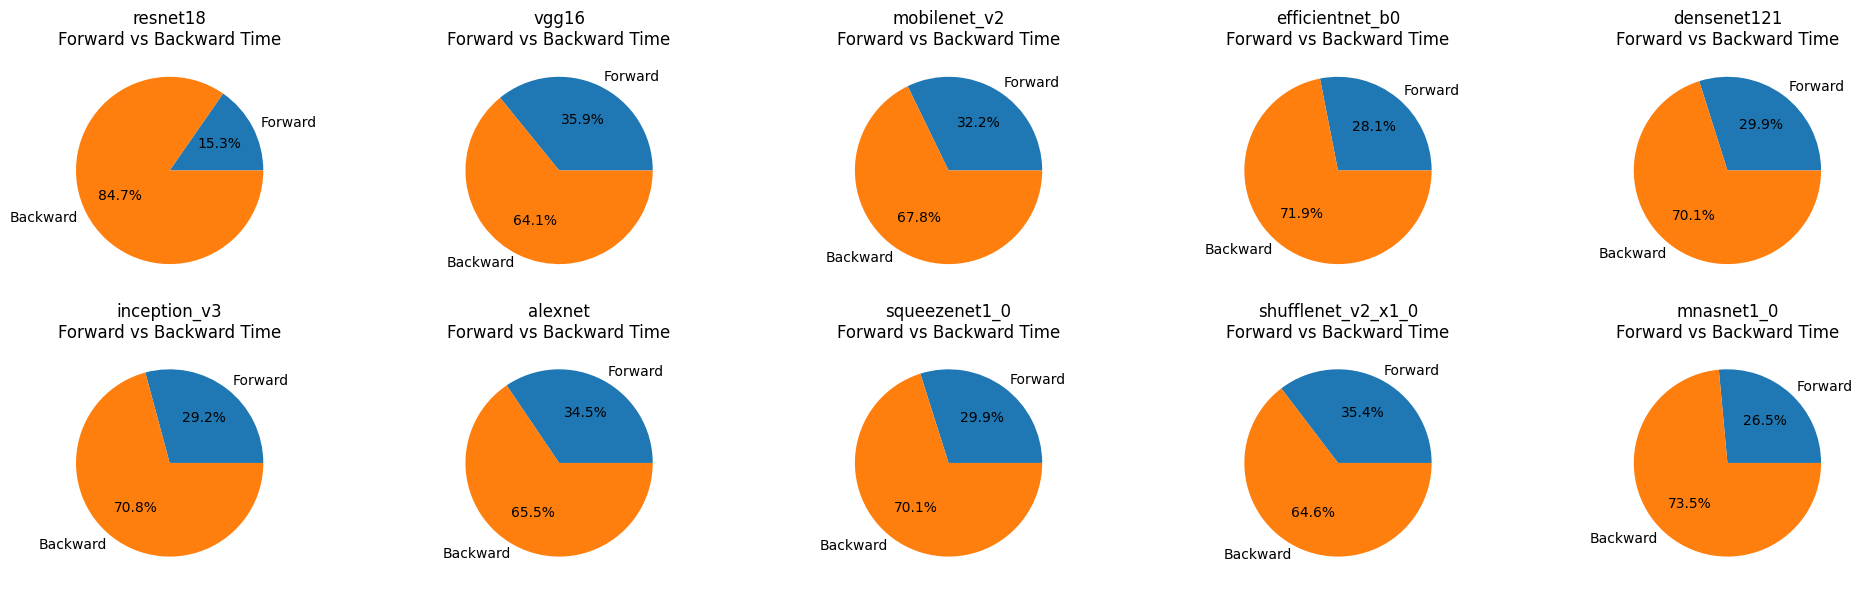

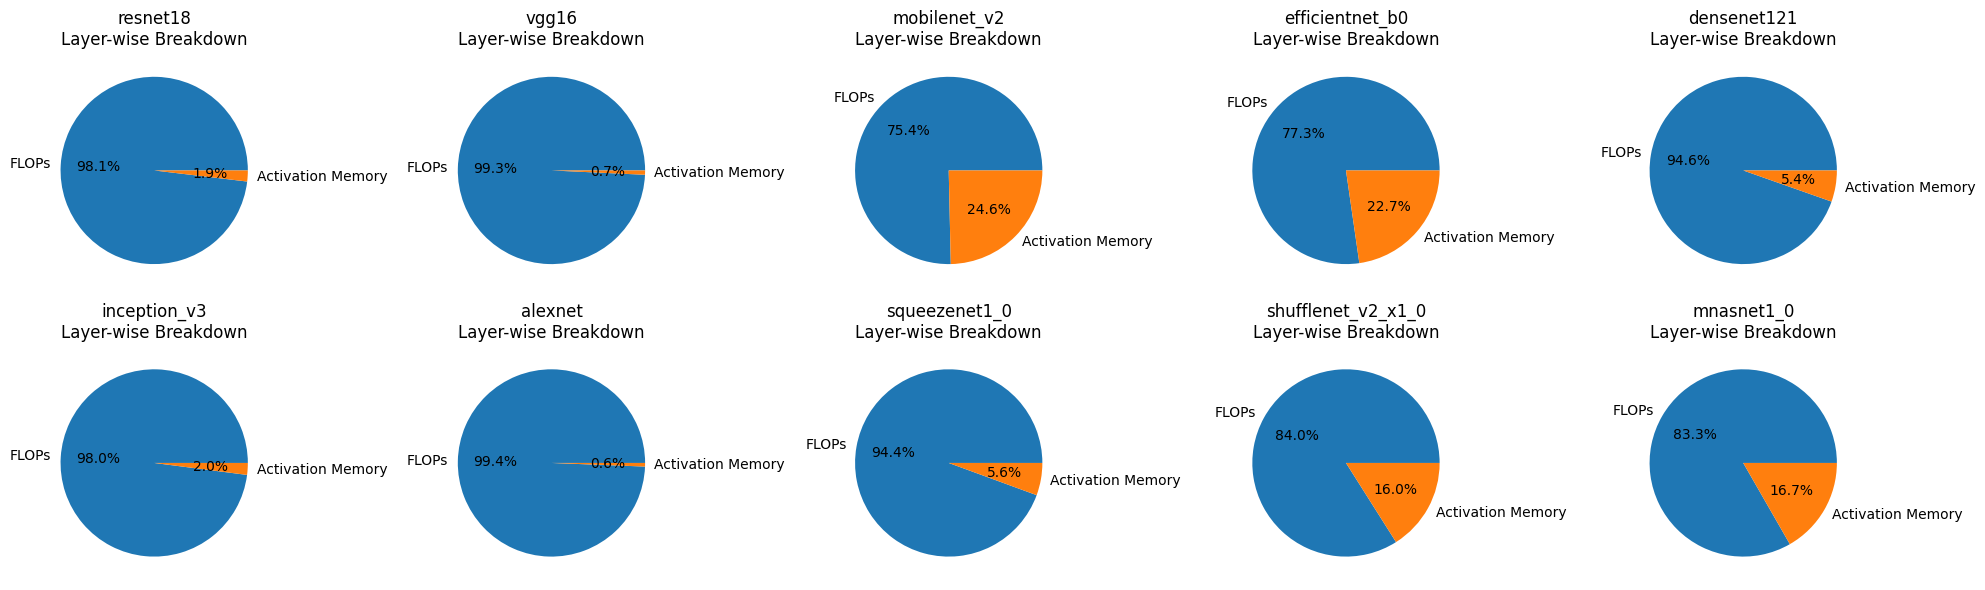

In [ ]:
import torch
import torchvision.models as models
import time
import matplotlib.pyplot as plt
from ptflops import get_model_complexity_info
from thop import profile
import gc
import numpy as np

# List of models to test
model_names = [
    "resnet18", "vgg16", "mobilenet_v2", "efficientnet_b0",
    "densenet121", "inception_v3", "alexnet", "squeezenet1_0",
    "shufflenet_v2_x1_0", "mnasnet1_0"
]

batch_sizes = [64, 32, 16, 8, 4, 2, 1]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

forward_backward_analysis = {}

for name in model_names:
    print(f"Processing model: {name}")

    input_size = 299 if name == "inception_v3" else 224

    batch_size = None
    for bs in batch_sizes:
        try:
            input_tensor = torch.randn(bs, 3, input_size, input_size, device=device, requires_grad=True)
            target = torch.randn(bs, 1000, device=device, requires_grad=True)  # Ensure target requires gradients
            batch_size = bs
            break
        except RuntimeError:
            torch.cuda.empty_cache()
            gc.collect()

    if batch_size is None:
        print(f"Skipping {name}: Not enough memory even for batch size 1!")
        continue

    # Load model
    model = getattr(models, name)(pretrained=False).train().to(device)
    for param in model.parameters():
        param.requires_grad = True

    macs, params = get_model_complexity_info(model, (3, input_size, input_size),
                                             as_strings=False, print_per_layer_stat=False)


    torch.cuda.synchronize()
    start_time = time.time()
    output = model(input_tensor)
    torch.cuda.synchronize()
    forward_time = time.time() - start_time
    output.requires_grad_(True)
    loss_fn = torch.nn.MSELoss()
    loss = loss_fn(output, target)
    loss = loss.mean()
    torch.cuda.synchronize()
    start_time = time.time()
    loss.backward()
    torch.cuda.synchronize()
    backward_time = time.time() - start_time
    backward_flops = 2 * macs
    param_memory = sum(p.numel() * p.element_size() for p in model.parameters())
    activation_sizes = []

    def memory_hook(module, input, output):
        if isinstance(output, tuple):
            for o in output:
                if isinstance(o, torch.Tensor):
                    activation_sizes.append(o.element_size() * o.numel())
        elif isinstance(output, torch.Tensor):
            activation_sizes.append(output.element_size() * output.numel())

    for module in model.modules():
        module.register_forward_hook(memory_hook)

    with torch.no_grad():
        _ = model(input_tensor)

    activation_memory = sum(activation_sizes)

    # Compute per-layer FLOPs and memory usage
    layer_flops, layer_memory = profile(model, inputs=(input_tensor,), verbose=False)

    # Store results
    forward_backward_analysis[name] = {
        "params": params,
        "flops_estimate": macs,
        "backward_flops": backward_flops,
        "param_memory": param_memory,
        "activation_memory": activation_memory,
        "total_memory": param_memory + activation_memory,
        "forward_time": forward_time,
        "backward_time": backward_time,
        "time_ratio": backward_time / forward_time,
        "flop_ratio": backward_flops / macs,
        "layer_flops": layer_flops,
        "layer_memory": max(layer_memory, 1e-6)
    }

    # Cleanup memory
    del model, input_tensor, target, output, loss
    torch.cuda.empty_cache()
    gc.collect()

for name, data in forward_backward_analysis.items():
    print(f"\nModel: {name}")
    print(f"  Batch Size Used: {batch_size}")
    print(f"  Parameters: {data['params']:,}")
    print(f"  Estimated FLOPs (Forward): {data['flops_estimate']:,}")
    print(f"  Estimated FLOPs (Backward): {data['backward_flops']:,}")
    print(f"  Parameter Memory: {data['param_memory'] / 1e6:.2f} MB")
    print(f"  Activation Memory: {data['activation_memory'] / 1e6:.2f} MB")
    print(f"  Total Memory: {data['total_memory'] / 1e6:.2f} MB")
    print(f"  Forward Latency: {data['forward_time']:.4f} s")
    print(f"  Backward Latency: {data['backward_time']:.4f} s")
    print(f"  Time Ratio (Backward/Forward): {data['time_ratio']:.2f}")
    print(f"  FLOPs Ratio (Backward/Forward): {data['flop_ratio']:.2f}\n")

# ---- Plot Results ----
# Forward vs. Backward Latency Pie Charts
plt.figure(figsize=(20, 6))
for i, (name, data) in enumerate(forward_backward_analysis.items(), 1):
    plt.subplot(2, 5, i)
    plt.pie([data['forward_time'], data['backward_time']],
            labels=['Forward', 'Backward'],
            autopct='%1.1f%%')
    plt.title(f"{name}\nForward vs Backward Time")

plt.tight_layout()
plt.savefig("5.2_Time_Distribution.png", dpi=300, bbox_inches='tight')
plt.show()

# Layer-wise FLOPs vs. Memory Breakdown Pie Charts

plt.figure(figsize=(20, 6))
for i, (name, data) in enumerate(forward_backward_analysis.items(), 1):
    plt.subplot(2, 5, i)

    activation_memory = max(data['activation_memory'], 1e-6)  # Avoid near-zero values

    plt.pie([data['layer_flops'], activation_memory],
            labels=['FLOPs', 'Activation Memory'],
            autopct='%1.1f%%')
    plt.title(f"{name}\nLayer-wise Breakdown")

plt.tight_layout()
plt.savefig("5.2_Layer_Breakdown.png", dpi=300, bbox_inches='tight')
plt.show()

Processing model: resnet18


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Processing model: vgg16
Processing model: mobilenet_v2
Processing model: efficientnet_b0
Processing model: densenet121
Processing model: inception_v3


/usr/local/lib/python3.11/dist-packages/torchvision/models/inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


Processing model: alexnet
Processing model: squeezenet1_0
Processing model: shufflenet_v2_x1_0
Processing model: mnasnet1_0

Model: resnet18
  Batch Size Used: 64
  Parameters: 11,689,512
  Estimated FLOPs (Forward): 1,825,313,768
  Estimated FLOPs (Backward): 3,650,627,536
  Parameter Memory: 46.76 MB
  Activation Memory: 2248.53 MB
  Total Memory: 2295.29 MB
  Forward Latency: 0.0686 s
  Backward Latency: 0.3990 s
  Time Ratio (Backward/Forward): 5.82
  FLOPs Ratio (Backward/Forward): 2.00


Model: vgg16
  Batch Size Used: 64
  Parameters: 138,357,544
  Estimated FLOPs (Forward): 15,523,225,576
  Estimated FLOPs (Backward): 31,046,451,152
  Parameter Memory: 553.43 MB
  Activation Memory: 7348.01 MB
  Total Memory: 7901.44 MB
  Forward Latency: 0.2908 s
  Backward Latency: 0.5240 s
  Time Ratio (Backward/Forward): 1.80
  FLOPs Ratio (Backward/Forward): 2.00


Model: mobilenet_v2
  Batch Size Used: 64
  Parameters: 3,504,872
  Estimated FLOPs (Forward): 320,300,008
  Estimated FLOPs (

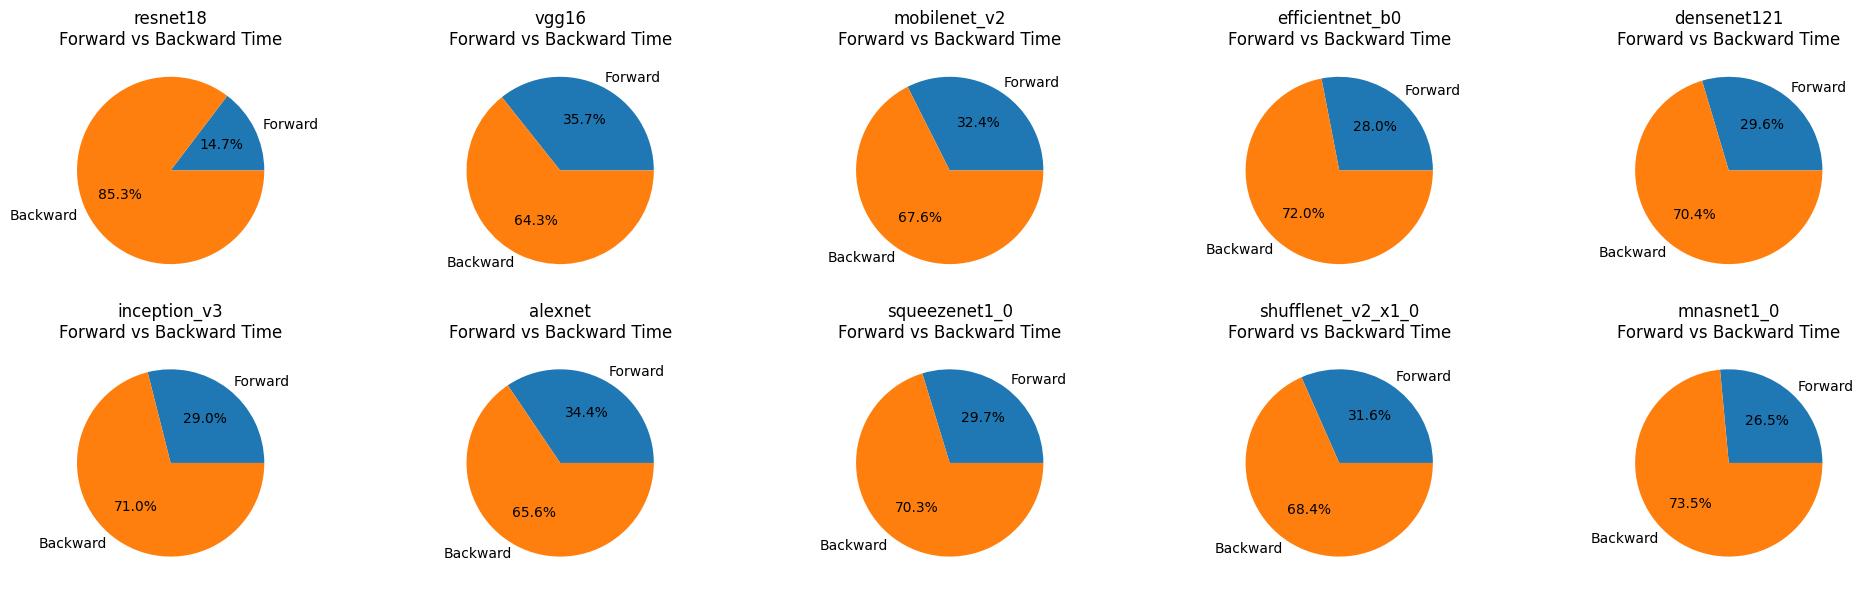

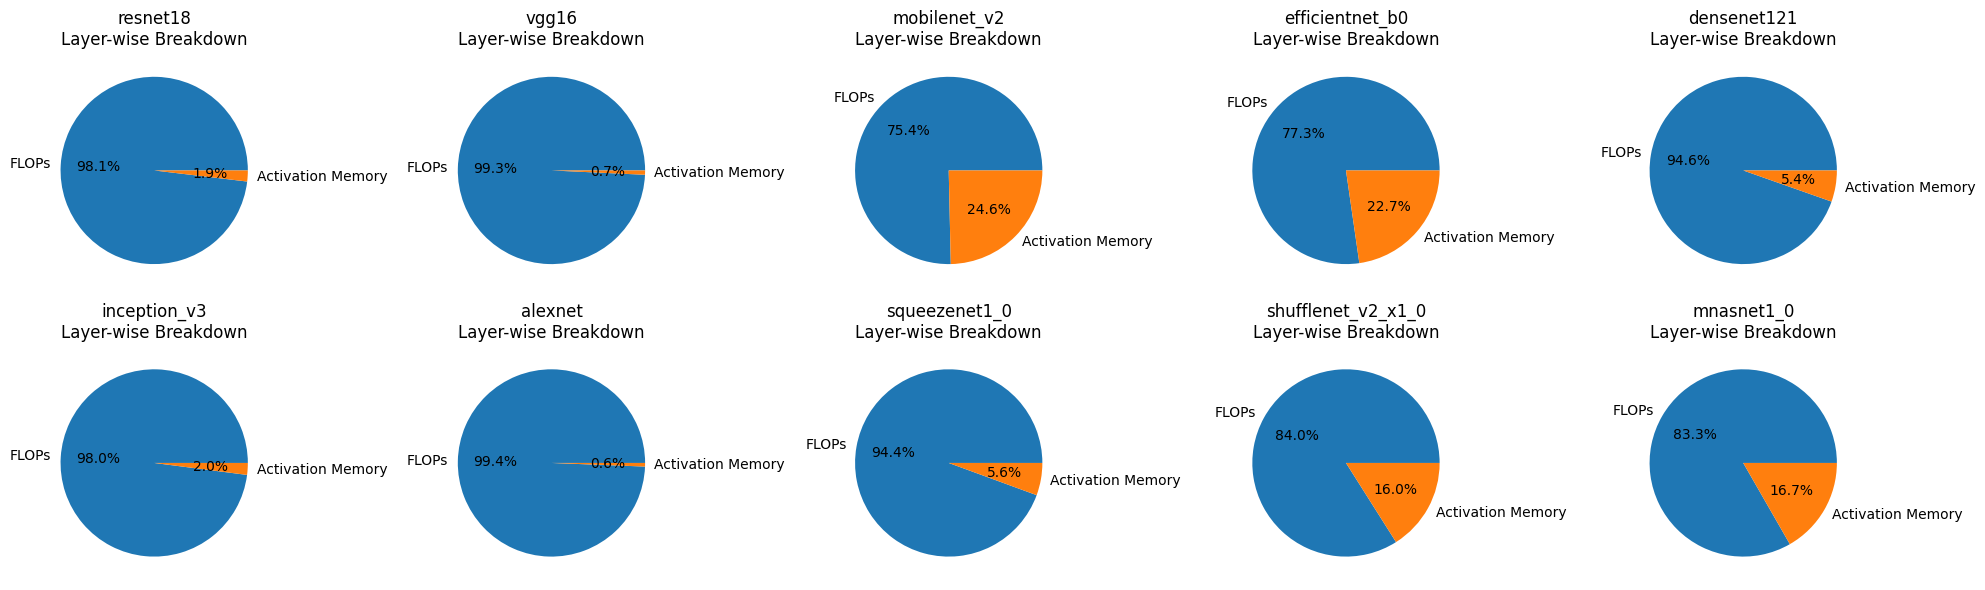

In [ ]:
import torch
import torchvision.models as models
import time
import matplotlib.pyplot as plt
from ptflops import get_model_complexity_info
from thop import profile
import gc
import numpy as np

# List of models to test
model_names = [
    "resnet18", "vgg16", "mobilenet_v2", "efficientnet_b0",
    "densenet121", "inception_v3", "alexnet", "squeezenet1_0",
    "shufflenet_v2_x1_0", "mnasnet1_0"
]

batch_sizes = [64, 32, 16, 8, 4, 2, 1]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

forward_backward_analysis = {}

for name in model_names:
    print(f"Processing model: {name}")

    input_size = 299 if name == "inception_v3" else 224

    batch_size = None
    for bs in batch_sizes:
        try:
            input_tensor = torch.randn(bs, 3, input_size, input_size, device=device, requires_grad=True)
            target = torch.randn(bs, 1000, device=device, requires_grad=True)  # Ensure target requires gradients
            batch_size = bs
            break
        except RuntimeError:
            torch.cuda.empty_cache()
            gc.collect()

    if batch_size is None:
        print(f"Skipping {name}: Not enough memory even for batch size 1!")
        continue

    # Load model
    model = getattr(models, name)(pretrained=False).train().to(device)
    for param in model.parameters():
        param.requires_grad = True

    # Compute MACs (Multiply-Accumulate Operations) and Parameters
    macs, params = get_model_complexity_info(model, (3, input_size, input_size),
                                             as_strings=False, print_per_layer_stat=False)

    # Compute parameter memory (in bytes)
    param_memory = sum(p.numel() * p.element_size() for p in model.parameters())

    # Activation memory tracking
    activation_sizes = []

    def memory_hook(module, input, output):
        """ Capture activation memory usage """
        if isinstance(output, tuple):
            for o in output:
                if isinstance(o, torch.Tensor):
                    activation_sizes.append(o.element_size() * o.numel())
        elif isinstance(output, torch.Tensor):
            activation_sizes.append(output.element_size() * output.numel())

    # Register hooks BEFORE the forward pass
    for module in model.modules():
        module.register_forward_hook(memory_hook)

    # Perform forward pass
    torch.cuda.synchronize()
    start_time = time.time()
    output = model(input_tensor)
    torch.cuda.synchronize()
    forward_time = time.time() - start_time

    # Compute activation memory (sum of all activations stored in forward pass)
    activation_memory = sum(activation_sizes)

    # Compute memory required for gradients (backward pass)
    output.requires_grad_(True)
    loss_fn = torch.nn.MSELoss()
    loss = loss_fn(output, target).mean()

    torch.cuda.synchronize()
    start_time = time.time()
    loss.backward(retain_graph=True)  # Retain graph to track activation memory during backward pass
    torch.cuda.synchronize()
    backward_time = time.time() - start_time

    # Compute backward FLOPs (usually 2x forward FLOPs)
    backward_flops = 2 * macs

    # Compute total memory footprint
    total_memory = param_memory + activation_memory  # Excludes optimizer states

    # Compute per-layer FLOPs and memory usage using THOP
    layer_flops, layer_memory = profile(model, inputs=(input_tensor,), verbose=False)

    # Store results
    forward_backward_analysis[name] = {
        "batch_size": batch_size,
        "params": params,
        "flops_estimate": macs,
        "backward_flops": backward_flops,
        "param_memory": param_memory,
        "activation_memory": activation_memory,
        "total_memory": total_memory,
        "forward_time": forward_time,
        "backward_time": backward_time,
        "time_ratio": backward_time / forward_time,
        "flop_ratio": backward_flops / macs,
        "layer_flops": layer_flops,
        "layer_memory": max(layer_memory, 1e-6)  # Avoid near-zero values
    }

    # Cleanup memory
    del model, input_tensor, target, output, loss
    torch.cuda.empty_cache()
    gc.collect()

# Print results
for name, data in forward_backward_analysis.items():
    print(f"\nModel: {name}")
    print(f"  Batch Size Used: {data['batch_size']}")
    print(f"  Parameters: {data['params']:,}")
    print(f"  Estimated FLOPs (Forward): {data['flops_estimate']:,}")
    print(f"  Estimated FLOPs (Backward): {data['backward_flops']:,}")
    print(f"  Parameter Memory: {data['param_memory'] / 1e6:.2f} MB")
    print(f"  Activation Memory: {data['activation_memory'] / 1e6:.2f} MB")
    print(f"  Total Memory: {data['total_memory'] / 1e6:.2f} MB")
    print(f"  Forward Latency: {data['forward_time']:.4f} s")
    print(f"  Backward Latency: {data['backward_time']:.4f} s")
    print(f"  Time Ratio (Backward/Forward): {data['time_ratio']:.2f}")
    print(f"  FLOPs Ratio (Backward/Forward): {data['flop_ratio']:.2f}\n")

# ---- Plot Results ----
# Forward vs. Backward Latency Pie Charts
plt.figure(figsize=(20, 6))
for i, (name, data) in enumerate(forward_backward_analysis.items(), 1):
    plt.subplot(2, 5, i)
    plt.pie([data['forward_time'], data['backward_time']],
            labels=['Forward', 'Backward'],
            autopct='%1.1f%%')
    plt.title(f"{name}\nForward vs Backward Time")

plt.tight_layout()
plt.savefig("5.2_Time_Distribution.png", dpi=300, bbox_inches='tight')
plt.show()

# Layer-wise FLOPs vs. Memory Breakdown Pie Charts
plt.figure(figsize=(20, 6))
for i, (name, data) in enumerate(forward_backward_analysis.items(), 1):
    plt.subplot(2, 5, i)

    plt.pie([data['layer_flops'], max(data['activation_memory'], 1e-6)],
            labels=['FLOPs', 'Activation Memory'],
            autopct='%1.1f%%')
    plt.title(f"{name}\nLayer-wise Breakdown")

plt.tight_layout()
plt.savefig("5.2_Layer_Breakdown.png", dpi=300, bbox_inches='tight')
plt.show()

Processing model: shufflenet_v2_x1_0
Processing model: vgg16
Processing model: mnasnet1_0
Processing model: densenet121
Processing model: alexnet


<Figure size 1200x600 with 0 Axes>

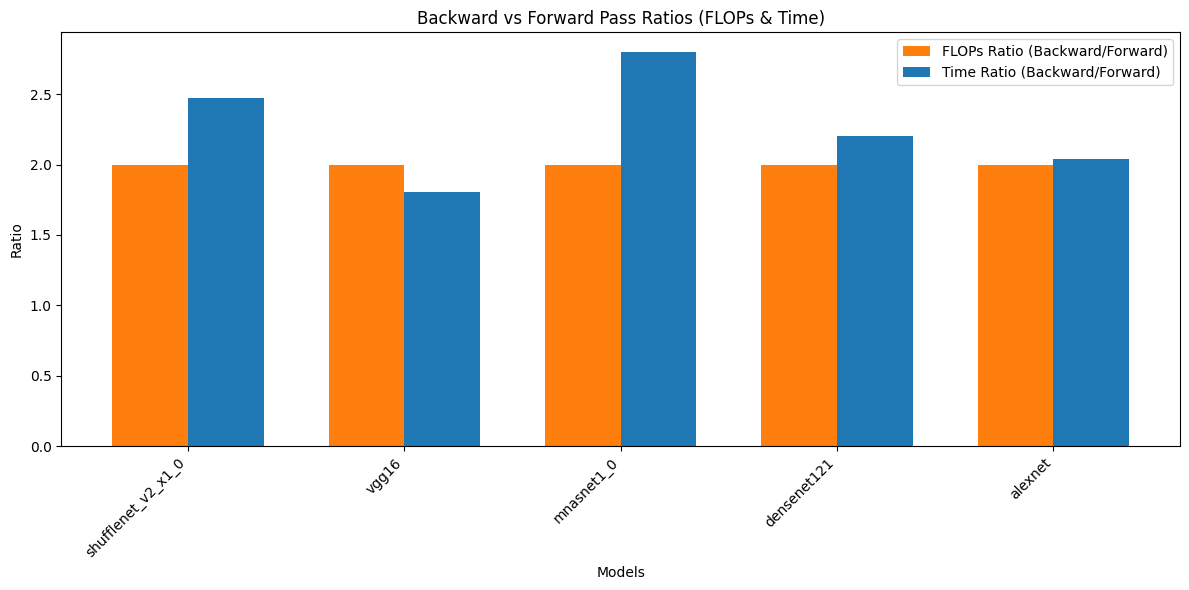

In [ ]:
import torch
import torchvision.models as models
import time
import matplotlib.pyplot as plt
from ptflops import get_model_complexity_info
from thop import profile
import gc
import numpy as np

# List of models to test
model_names = ["shufflenet_v2_x1_0", "vgg16", "mnasnet1_0", "densenet121", "alexnet"]

batch_sizes = [64, 32, 16, 8, 4, 2, 1]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

forward_backward_analysis = {}

for name in model_names:
    print(f"Processing model: {name}")

    input_size = 299 if name == "inception_v3" else 224

    batch_size = None
    for bs in batch_sizes:
        try:
            input_tensor = torch.randn(bs, 3, input_size, input_size, device=device, requires_grad=True)
            target = torch.randn(bs, 1000, device=device, requires_grad=True)
            batch_size = bs
            break
        except RuntimeError:
            torch.cuda.empty_cache()
            gc.collect()

    if batch_size is None:
        print(f"Skipping {name}: Not enough memory even for batch size 1!")
        continue

    model = getattr(models, name)(pretrained=False).train().to(device)
    for param in model.parameters():
        param.requires_grad = True

    # Compute MACs and Parameters
    macs, params = get_model_complexity_info(model, (3, input_size, input_size),
                                             as_strings=False, print_per_layer_stat=False)

    # Compute parameter memory (in bytes)
    param_memory = sum(p.numel() * p.element_size() for p in model.parameters())

    # Activation memory tracking
    activation_sizes = []

    def memory_hook(module, input, output):
        """ Capture activation memory usage """
        if isinstance(output, tuple):
            for o in output:
                if isinstance(o, torch.Tensor):
                    activation_sizes.append(o.element_size() * o.numel())
        elif isinstance(output, torch.Tensor):
            activation_sizes.append(output.element_size() * output.numel())

    # Register hooks BEFORE the first forward pass
    for module in model.modules():
        module.register_forward_hook(memory_hook)

    # Perform forward pass
    torch.cuda.synchronize()
    start_time = time.time()
    output = model(input_tensor)
    torch.cuda.synchronize()
    forward_time = time.time() - start_time

    # Compute activation memory (sum of all activations stored in forward pass)
    activation_memory = sum(activation_sizes)

    # Compute memory required for gradients (backward pass)
    output.requires_grad_(True)
    loss_fn = torch.nn.MSELoss()
    loss = loss_fn(output, target).mean()

    torch.cuda.synchronize()
    start_time = time.time()
    loss.backward(retain_graph=True)  # Retain graph to track activation memory during backward pass
    torch.cuda.synchronize()
    backward_time = time.time() - start_time

    # Compute backward FLOPs (corrected to 2x forward FLOPs)
    backward_flops = 2 * macs

    # Compute total memory footprint
    total_memory = param_memory + activation_memory  # Excludes optimizer states

    # Compute per-layer FLOPs and memory usage using THOP
    layer_flops, layer_memory = profile(model, inputs=(input_tensor,), verbose=False)

    # Store results
    forward_backward_analysis[name] = {
        "batch_size": batch_size,
        "params": params,
        "flops_estimate": macs,
        "backward_flops": backward_flops,
        "param_memory": param_memory,
        "activation_memory": activation_memory,
        "total_memory": total_memory,
        "forward_time": forward_time,
        "backward_time": backward_time,
        "time_ratio": backward_time / forward_time,
        "flop_ratio": backward_flops / macs,
        "layer_flops": layer_flops,
        "layer_memory": max(layer_memory, 1e-6)  # Avoid near-zero values
    }

    # Cleanup memory
    del model, input_tensor, target, output, loss
    torch.cuda.empty_cache()
    gc.collect()

# ---- Plot Results ----
plt.figure(figsize=(12, 6))
model_labels = list(forward_backward_analysis.keys())
flops_ratios = [data['flop_ratio'] for data in forward_backward_analysis.values()]
time_ratios = [data['time_ratio'] for data in forward_backward_analysis.values()]

x = np.arange(len(model_labels))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
flops_bars = ax.bar(x - width/2, flops_ratios, width, label="FLOPs Ratio (Backward/Forward)", color="#ff7f0e")
time_bars = ax.bar(x + width/2, time_ratios, width, label="Time Ratio (Backward/Forward)", color="#1f77b4")

ax.set_xlabel("Models")
ax.set_ylabel("Ratio")
ax.set_title("Backward vs Forward Pass Ratios (FLOPs & Time)")
ax.set_xticks(x)
ax.set_xticklabels(model_labels, rotation=45, ha="right")
ax.legend()
ax.set_yscale("linear")

plt.tight_layout()
plt.savefig("5.2_FLOPs_Time_Ratio.png", dpi=300, bbox_inches='tight')
plt.show()

Processing model: shufflenet_v2_x1_0


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Processing model: vgg16
Processing model: mnasnet1_0
Processing model: densenet121
Processing model: alexnet


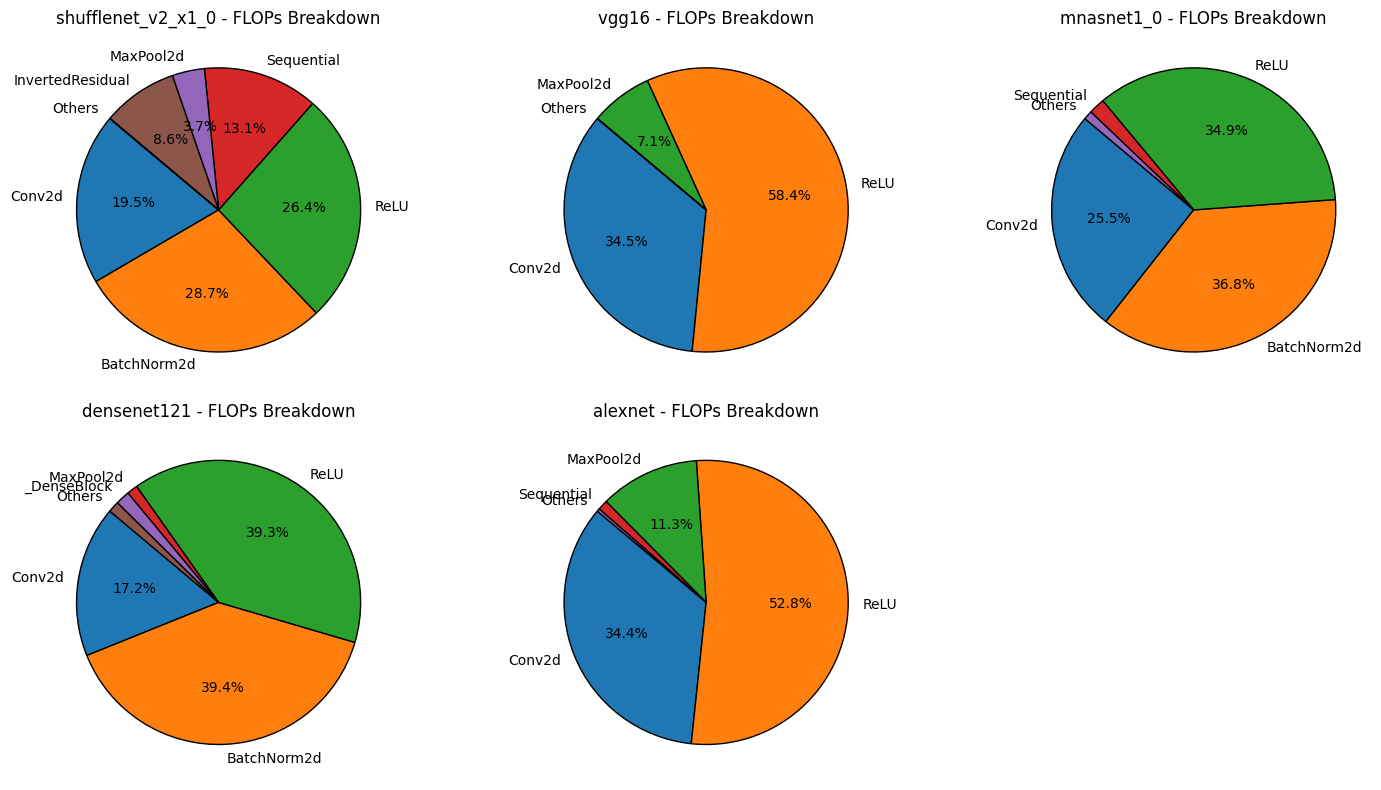

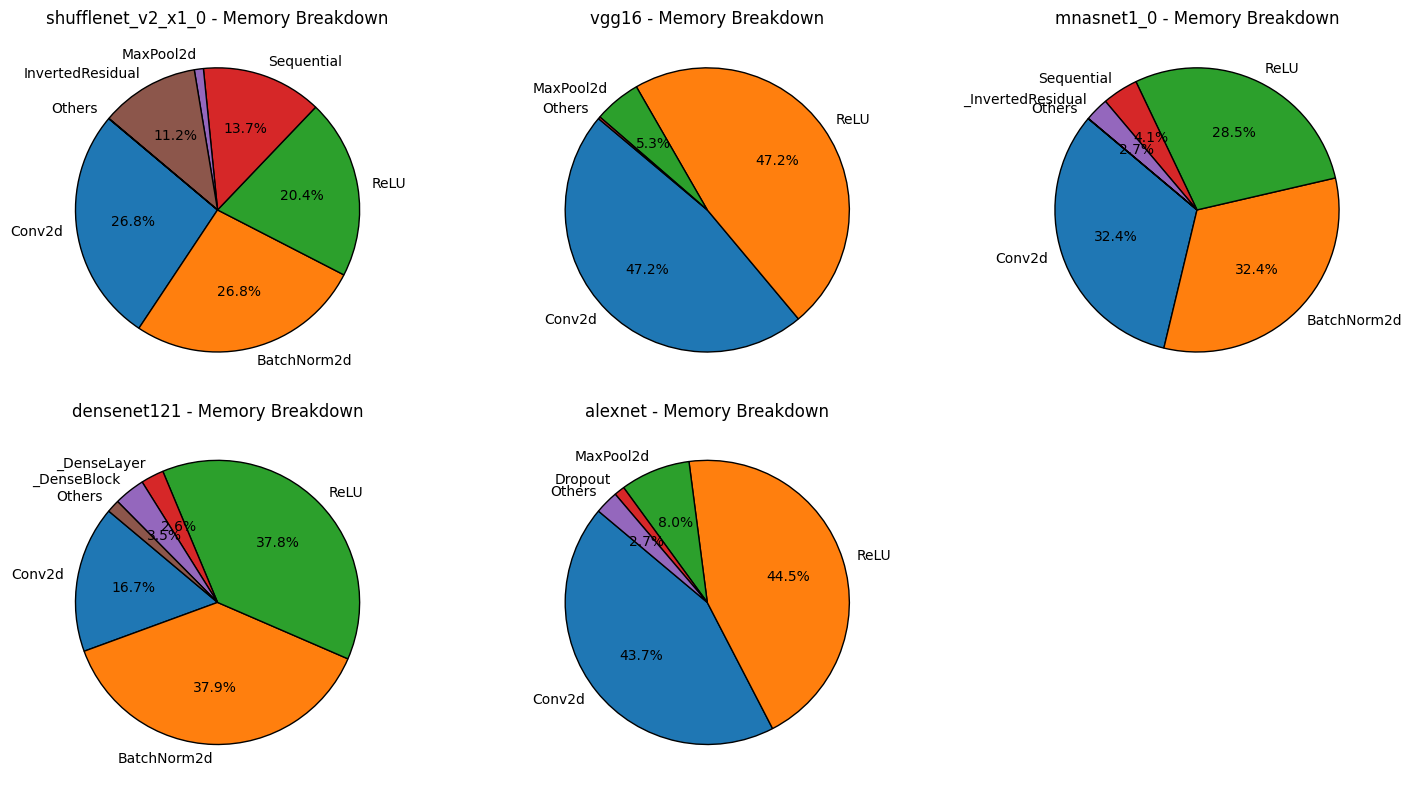

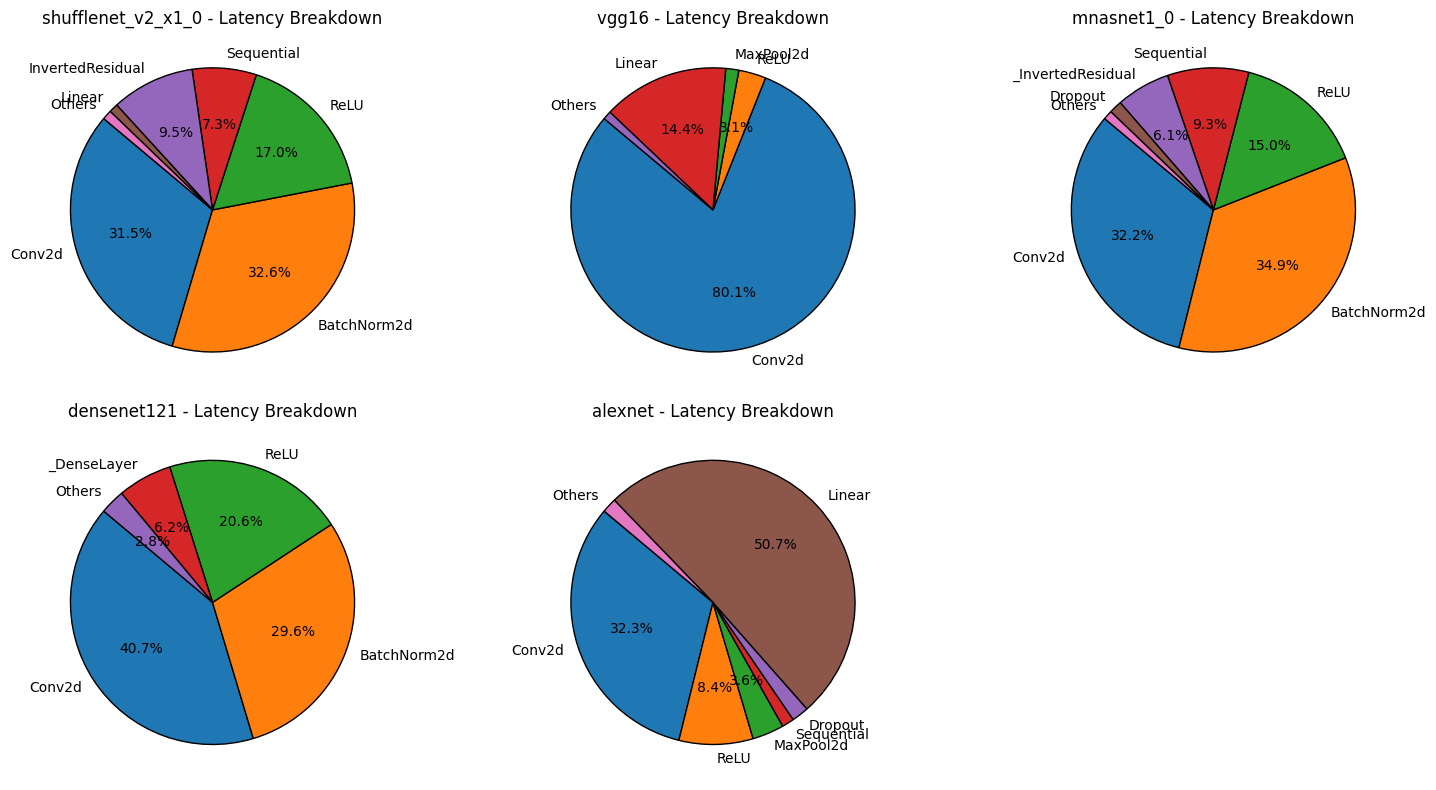

In [ ]:
import torch
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np
import time
import gc
from collections import defaultdict

# Define model names
model_names = ["shufflenet_v2_x1_0", "vgg16", "mnasnet1_0", "densenet121", "alexnet"]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Store results for different metrics
layer_flops_data = {}
layer_memory_data = {}
layer_latency_data = {}

for name in model_names:
    print(f"Processing model: {name}")

    input_size = 299 if name == "inception_v3" else 224
    model = getattr(models, name)(pretrained=False).eval().to(device)

    flops_per_layer = defaultdict(float)
    memory_per_layer = defaultdict(float)
    latency_per_layer = defaultdict(float)

    def flops_hook(module, input, output):
        inp_tensor = input[0] if isinstance(input, (tuple, list)) and isinstance(input[0], torch.Tensor) else input
        if not isinstance(inp_tensor, torch.Tensor):
            return
        if isinstance(output, (tuple, list)):
            out_tensor = sum(np.prod(o.shape) for o in output if isinstance(o, torch.Tensor))
        elif isinstance(output, torch.Tensor):
            out_tensor = np.prod(output.shape)
        else:
            return

        num_operations = out_tensor * np.prod(inp_tensor.shape[1:])
        flops_per_layer[type(module).__name__] += num_operations


    def memory_hook(module, input, output):
        if isinstance(output, (tuple, list)):
            out_memory = sum(o.element_size() * o.numel() for o in output if isinstance(o, torch.Tensor))
        elif isinstance(output, torch.Tensor):
            out_memory = output.element_size() * output.numel()
        else:
            return

        memory_per_layer[type(module).__name__] += out_memory


    def latency_hook(module, input, output):
        start_time = time.time()
        torch.cuda.synchronize()  # Ensure accurate timing
        end_time = time.time()
        latency_per_layer[type(module).__name__] += (end_time - start_time) * 1000  # Convert to milliseconds

    # Register hooks
    for module in model.modules():
        module.register_forward_hook(flops_hook)
        module.register_forward_hook(memory_hook)
        module.register_forward_hook(latency_hook)

    # Run forward pass
    input_tensor = torch.randn(1, 3, input_size, input_size, device=device)
    with torch.no_grad():
        torch.cuda.synchronize()
        _ = model(input_tensor)
        torch.cuda.synchronize()

    # Compute backward pass impact
    model.train()
    input_tensor.requires_grad = True
    output = model(input_tensor)
    loss = output.sum()
    loss.backward()  # Backpropagation to measure backward FLOPs & memory

    # Normalize and store the results
    total_flops = sum(flops_per_layer.values())
    total_memory = sum(memory_per_layer.values())
    total_latency = sum(latency_per_layer.values())

    if total_flops > 0:
        layer_flops_data[name] = {
            k: (v / total_flops) * 100 for k, v in flops_per_layer.items() if (v / total_flops) * 100 > 1
        }
        layer_flops_data[name]["Others"] = 100 - sum(layer_flops_data[name].values())

    if total_memory > 0:
        layer_memory_data[name] = {
            k: (v / total_memory) * 100 for k, v in memory_per_layer.items() if (v / total_memory) * 100 > 1
        }
        layer_memory_data[name]["Others"] = 100 - sum(layer_memory_data[name].values())

    if total_latency > 0:
        layer_latency_data[name] = {
            k: (v / total_latency) * 100 for k, v in latency_per_layer.items() if (v / total_latency) * 100 > 1
        }
        layer_latency_data[name]["Others"] = 100 - sum(layer_latency_data[name].values())

    # Cleanup
    del model, input_tensor
    torch.cuda.empty_cache()
    gc.collect()

# ---- Plot Results ----
def plot_pie_charts(data, title, filename):
    num_models = len(data)
    rows = (num_models + 2) // 3
    fig, axes = plt.subplots(rows, 3, figsize=(15, 8))
    axes = axes.flatten()

    for i, (model_name, layer_data) in enumerate(data.items()):
        ax = axes[i]
        labels, values = zip(*layer_data.items())
        ax.pie(values, labels=labels, autopct=lambda p: f'{p:.1f}%' if p > 2 else '', startangle=140, wedgeprops={'edgecolor': 'black'})
        ax.set_title(f"{model_name} - {title}")

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.subplots_adjust(hspace=0.4, wspace=0.4)
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

# Plot FLOPs breakdown
plot_pie_charts(layer_flops_data, "FLOPs Breakdown", "5.3_Layer_FLOPs_Breakdown.png")

# Plot Memory breakdown
plot_pie_charts(layer_memory_data, "Memory Breakdown", "5.3_Layer_Memory_Breakdown.png")

# Plot Latency breakdown
plot_pie_charts(layer_latency_data, "Latency Breakdown", "5.3_Layer_Latency_Breakdown.png")

Processing model: shufflenet_v2_x1_0


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Processing model: vgg16
Processing model: mnasnet1_0
Processing model: densenet121
Processing model: alexnet


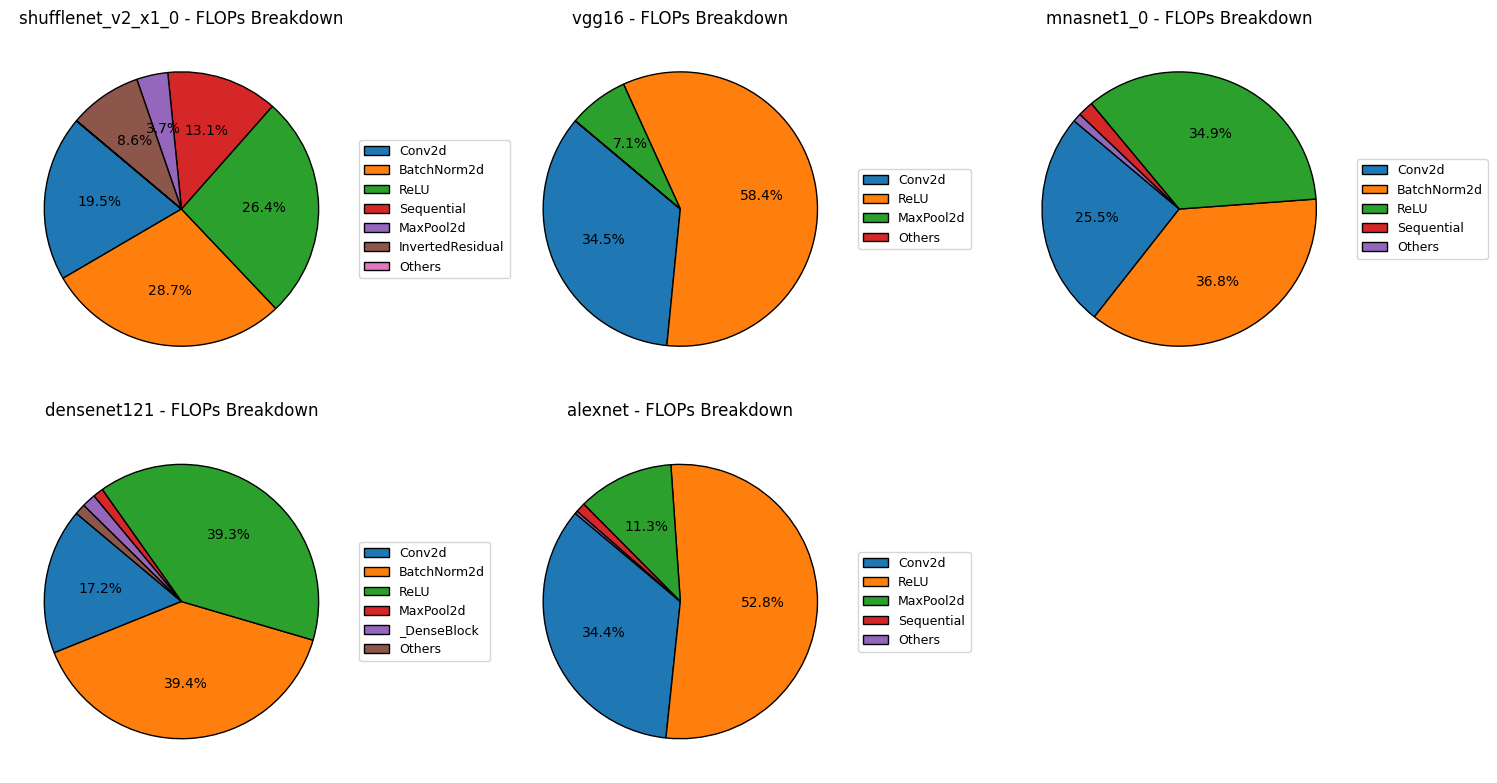

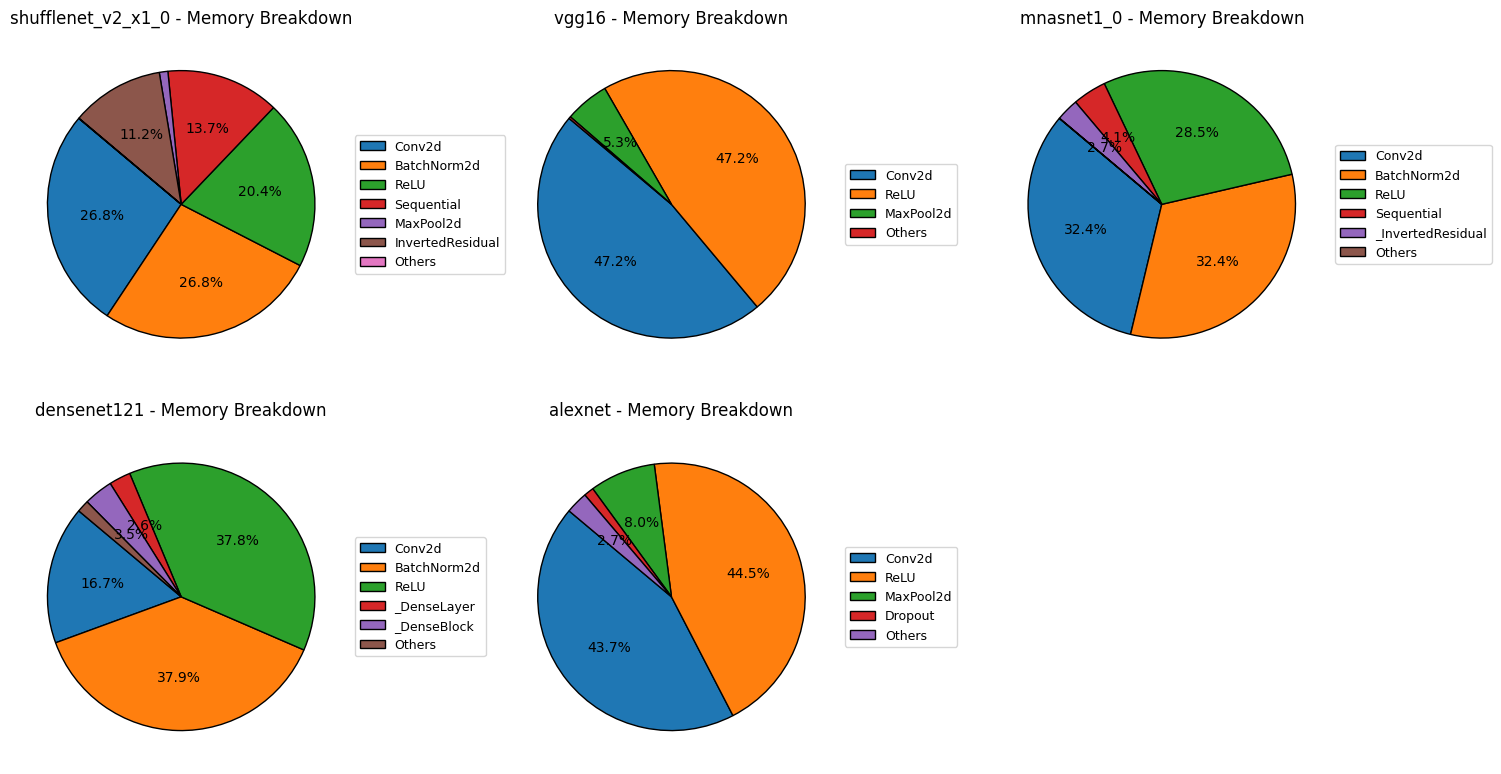

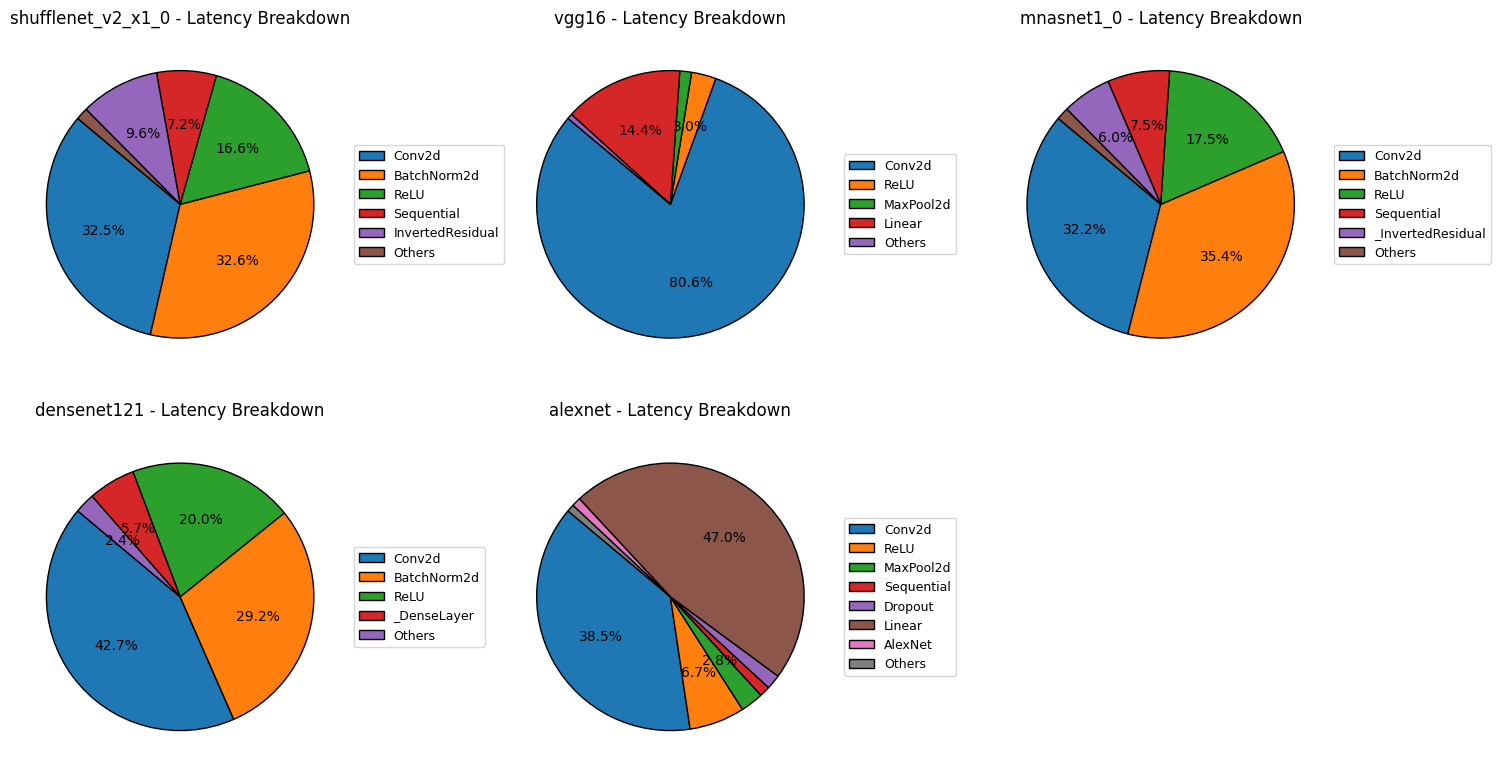

In [ ]:
import torch
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np
import time
import gc
from collections import defaultdict

from adjustText import adjust_text

# Define model names
model_names = ["shufflenet_v2_x1_0", "vgg16", "mnasnet1_0", "densenet121", "alexnet"]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Store results for different metrics
layer_flops_data = {}
layer_memory_data = {}
layer_latency_data = {}

for name in model_names:
    print(f"Processing model: {name}")

    input_size = 299 if name == "inception_v3" else 224
    model = getattr(models, name)(pretrained=False).eval().to(device)

    flops_per_layer = defaultdict(float)
    memory_per_layer = defaultdict(float)
    latency_per_layer = defaultdict(float)

    # Hook for FLOPs calculation
    def flops_hook(module, input, output):
        inp_tensor = input[0] if isinstance(input, (tuple, list)) and isinstance(input[0], torch.Tensor) else input
        if not isinstance(inp_tensor, torch.Tensor):
            return
        if isinstance(output, (tuple, list)):
            out_tensor = sum(np.prod(o.shape) for o in output if isinstance(o, torch.Tensor))
        elif isinstance(output, torch.Tensor):
            out_tensor = np.prod(output.shape)
        else:
            return

        num_operations = out_tensor * np.prod(inp_tensor.shape[1:])
        flops_per_layer[type(module).__name__] += num_operations

    # Hook for memory measurement
    def memory_hook(module, input, output):
        if isinstance(output, (tuple, list)):
            out_memory = sum(o.element_size() * o.numel() for o in output if isinstance(o, torch.Tensor))
        elif isinstance(output, torch.Tensor):
            out_memory = output.element_size() * output.numel()
        else:
            return

        memory_per_layer[type(module).__name__] += out_memory

    # Hook for latency measurement
    def latency_hook(module, input, output):
        start_time = time.time()
        torch.cuda.synchronize()
        end_time = time.time()
        latency_per_layer[type(module).__name__] += (end_time - start_time) * 1000  # Convert to milliseconds

    # Register hooks
    for module in model.modules():
        module.register_forward_hook(flops_hook)
        module.register_forward_hook(memory_hook)
        module.register_forward_hook(latency_hook)

    # Run forward pass
    input_tensor = torch.randn(1, 3, input_size, input_size, device=device)
    with torch.no_grad():
        torch.cuda.synchronize()
        _ = model(input_tensor)
        torch.cuda.synchronize()

    # Compute backward pass impact
    model.train()
    input_tensor.requires_grad = True
    output = model(input_tensor)
    loss = output.sum()
    loss.backward()  # Backpropagation to measure backward FLOPs & memory

    # Normalize and store the results
    total_flops = sum(flops_per_layer.values())
    total_memory = sum(memory_per_layer.values())
    total_latency = sum(latency_per_layer.values())

    if total_flops > 0:
        layer_flops_data[name] = {
            k: (v / total_flops) * 100 for k, v in flops_per_layer.items() if (v / total_flops) * 100 > 1
        }
        layer_flops_data[name]["Others"] = 100 - sum(layer_flops_data[name].values())

    if total_memory > 0:
        layer_memory_data[name] = {
            k: (v / total_memory) * 100 for k, v in memory_per_layer.items() if (v / total_memory) * 100 > 1
        }
        layer_memory_data[name]["Others"] = 100 - sum(layer_memory_data[name].values())

    if total_latency > 0:
        layer_latency_data[name] = {
            k: (v / total_latency) * 100 for k, v in latency_per_layer.items() if (v / total_latency) * 100 > 1
        }
        layer_latency_data[name]["Others"] = 100 - sum(layer_latency_data[name].values())

    # Cleanup
    del model, input_tensor
    torch.cuda.empty_cache()
    gc.collect()

# ---- Plot Results ----
def plot_pie_charts(data, title, filename):
    num_models = len(data)
    rows = (num_models + 2) // 3
    fig, axes = plt.subplots(rows, 3, figsize=(15, 8))
    axes = axes.flatten()

    for i, (model_name, layer_data) in enumerate(data.items()):
        ax = axes[i]
        labels, values = zip(*layer_data.items())

        # Generate Pie Chart WITHOUT labels to avoid clutter
        wedges, texts, autotexts = ax.pie(
            values,
            startangle=140,
            wedgeprops={'edgecolor': 'black'},
            textprops={'fontsize': 10},
            labeldistance=None,
            autopct=lambda p: f'{p:.1f}%' if p > 2 else ''
        )

        # Add a legend to the side for better readability
        ax.legend(
            wedges, labels,
            loc="center left",
            bbox_to_anchor=(1, 0.5),  # Move legend outside the plot
            fontsize=9
        )

        ax.set_title(f"{model_name} - {title}", fontsize=12, pad=10)


    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.subplots_adjust(hspace=0.6, wspace=0.8)  # Increase spacing between subplots
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

# Plot FLOPs breakdown
plot_pie_charts(layer_flops_data, "FLOPs Breakdown", "5.3_Layer_FLOPs_Breakdown.png")

# Plot Memory breakdown
plot_pie_charts(layer_memory_data, "Memory Breakdown", "5.3_Layer_Memory_Breakdown.png")

# Plot Latency breakdown
plot_pie_charts(layer_latency_data, "Latency Breakdown", "5.3_Layer_Latency_Breakdown.png")